In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
data_structured = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.243, 'BERTScore': 0.717, 'Factuality': 0.455, 'Helpfulness': 3.507, 'Harmlessness': 3.294, 'Coherence': 3.704},
                    1: {'ROUGE': 0.247, 'BERTScore': 0.721, 'Factuality': 0.464, 'Helpfulness': 3.447, 'Harmlessness': 3.215, 'Coherence': 3.663},
                    3: {'ROUGE': 0.252, 'BERTScore': 0.723, 'Factuality': 0.472, 'Helpfulness': 3.434, 'Harmlessness': 3.235, 'Coherence': 3.593},
                    6: {'ROUGE': 0.253, 'BERTScore': 0.723, 'Factuality': 0.477, 'Helpfulness': 3.441, 'Harmlessness': 3.197, 'Coherence': 3.606}
                },
                'raw': {
                    0: {'ROUGE': 0.243, 'BERTScore': 0.715, 'Factuality': 0.460, 'Helpfulness': 3.435, 'Harmlessness': 3.245, 'Coherence': 3.686},
                    1: {'ROUGE': 0.247, 'BERTScore': 0.720, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.628},
                    3: {'ROUGE': 0.251, 'BERTScore': 0.722, 'Factuality': 0.478, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.624},
                    6: {'ROUGE': 0.253, 'BERTScore': 0.723, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.558}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.249, 'BERTScore': 0.719, 'Factuality': 0.462, 'Helpfulness': 3.494, 'Harmlessness': 3.259, 'Coherence': 3.717},
                    1: {'ROUGE': 0.255, 'BERTScore': 0.723, 'Factuality': 0.464, 'Helpfulness': 3.429, 'Harmlessness': 3.213, 'Coherence': 3.666},
                    3: {'ROUGE': 0.259, 'BERTScore': 0.725, 'Factuality': 0.477, 'Helpfulness': 3.412, 'Harmlessness': 3.274, 'Coherence': 3.574},
                    6: {'ROUGE': 0.259, 'BERTScore': 0.726, 'Factuality': 0.480, 'Helpfulness': 3.443, 'Harmlessness': 3.237, 'Coherence': 3.620}
                },
                'raw': {
                    0: {'ROUGE': 0.250, 'BERTScore': 0.719, 'Factuality': 0.463, 'Helpfulness': 3.470, 'Harmlessness': 3.242, 'Coherence': 3.639},
                    1: {'ROUGE': 0.253, 'BERTScore': 0.722, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.608},
                    3: {'ROUGE': 0.255, 'BERTScore': 0.724, 'Factuality': 0.486, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.637},
                    6: {'ROUGE': 0.255, 'BERTScore': 0.726, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.576}
                }
            }
        },
        'claude-3-haiku': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.237, 'BERTScore': 0.699, 'Factuality': 0.454, 'Helpfulness': 3.741, 'Harmlessness': 3.380, 'Coherence': 3.982},
                    1: {'ROUGE': 0.238, 'BERTScore': 0.700, 'Factuality': None, 'Helpfulness': 3.821, 'Harmlessness': 3.428, 'Coherence': 4.003},
                    3: {'ROUGE': 0.241, 'BERTScore': 0.700, 'Factuality': None, 'Helpfulness': 3.886, 'Harmlessness': 3.459, 'Coherence': 4.023},
                    6: {'ROUGE': 0.243, 'BERTScore': 0.700, 'Factuality': None, 'Helpfulness': 3.893, 'Harmlessness': 3.447, 'Coherence': 4.034}
                },
                'raw': {
                    0: {'ROUGE': 0.233, 'BERTScore': 0.697, 'Factuality': 0.452, 'Helpfulness': 3.693, 'Harmlessness': 3.381, 'Coherence': 3.923},
                    1: {'ROUGE': 0.237, 'BERTScore': 0.698, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.973},
                    3: {'ROUGE': 0.240, 'BERTScore': 0.700, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.985},
                    6: {'ROUGE': 0.242, 'BERTScore': 0.700, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.966}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.238, 'BERTScore': 0.702, 'Factuality': 0.444, 'Helpfulness': 3.724, 'Harmlessness': 3.518, 'Coherence': 3.893},
                    1: {'ROUGE': 0.240, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': 3.707, 'Harmlessness': 3.479, 'Coherence': 3.908},
                    3: {'ROUGE': 0.246, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': 3.814, 'Harmlessness': 3.489, 'Coherence': 4.036},
                    6: {'ROUGE': 0.249, 'BERTScore': 0.704, 'Factuality': None, 'Helpfulness': 3.821, 'Harmlessness': 3.467, 'Coherence': 4.051}
                },
                'raw': {
                    0: {'ROUGE': 0.240, 'BERTScore': 0.701, 'Factuality': 0.461, 'Helpfulness': 3.709, 'Harmlessness': 3.521, 'Coherence': 3.959},
                    1: {'ROUGE': 0.244, 'BERTScore': 0.701, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.005},
                    3: {'ROUGE': 0.243, 'BERTScore': 0.701, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.937},
                    6: {'ROUGE': 0.251, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.930}
                }
            }
        },
        'gemini-2.0-flash': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.240, 'BERTScore': 0.703, 'Factuality': 0.450, 'Helpfulness': 4.119, 'Harmlessness': 3.666, 'Coherence': 4.280},
                    1: {'ROUGE': 0.256, 'BERTScore': 0.720, 'Factuality': None, 'Helpfulness': 3.666, 'Harmlessness': 3.337, 'Coherence': 3.831},
                    3: {'ROUGE': 0.257, 'BERTScore': 0.720, 'Factuality': None, 'Helpfulness': 3.749, 'Harmlessness': 3.383, 'Coherence': 3.911},
                    6: {'ROUGE': 0.259, 'BERTScore': 0.720, 'Factuality': None, 'Helpfulness': 3.777, 'Harmlessness': 3.341, 'Coherence': 3.907}
                },
                'raw': {
                    0: {'ROUGE': 0.237, 'BERTScore': 0.697, 'Factuality': 0.458, 'Helpfulness': 4.291, 'Harmlessness': 3.788, 'Coherence': 4.410},
                    1: {'ROUGE': 0.255, 'BERTScore': 0.718, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.867},
                    3: {'ROUGE': 0.256, 'BERTScore': 0.717, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.943},
                    6: {'ROUGE': 0.258, 'BERTScore': 0.717, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.959}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.244, 'BERTScore': 0.708, 'Factuality': 0.447, 'Helpfulness': 4.012, 'Harmlessness': 3.702, 'Coherence': 4.213},
                    1: {'ROUGE': 0.262, 'BERTScore': 0.723, 'Factuality': None, 'Helpfulness': 3.622, 'Harmlessness': 3.310, 'Coherence': 3.702},
                    3: {'ROUGE': 0.266, 'BERTScore': 0.725, 'Factuality': None, 'Helpfulness': 3.680, 'Harmlessness': 3.349, 'Coherence': 3.930},
                    6: {'ROUGE': 0.270, 'BERTScore': 0.728, 'Factuality': None, 'Helpfulness': 3.661, 'Harmlessness': 3.392, 'Coherence': 3.821}
                },
                'raw': {
                    0: {'ROUGE': 0.237, 'BERTScore': 0.701, 'Factuality': 0.454, 'Helpfulness': 4.174, 'Harmlessness': 3.835, 'Coherence': 4.274},
                    1: {'ROUGE': 0.263, 'BERTScore': 0.722, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.804},
                    3: {'ROUGE': 0.264, 'BERTScore': 0.722, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.893},
                    6: {'ROUGE': 0.266, 'BERTScore': 0.724, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.898}
                }
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.228, 'BERTScore': 0.709, 'Factuality': 0.446, 'Helpfulness': 4.048, 'Harmlessness': 3.594, 'Coherence': 4.267},
                    1: {'ROUGE': 0.226, 'BERTScore': 0.704, 'Factuality': 0.451, 'Helpfulness': 4.151, 'Harmlessness': 3.730, 'Coherence': 4.322},
                    3: {'ROUGE': 0.224, 'BERTScore': 0.699, 'Factuality': 0.452, 'Helpfulness': 4.235, 'Harmlessness': 3.788, 'Coherence': 4.400},
                    6: {'ROUGE': 0.224, 'BERTScore': 0.696, 'Factuality': 0.459, 'Helpfulness': 4.289, 'Harmlessness': 3.859, 'Coherence': 4.475}
                },
                'raw': {
                    0: {'ROUGE': 0.224, 'BERTScore': 0.703, 'Factuality': 0.443, 'Helpfulness': 4.099, 'Harmlessness': 3.668, 'Coherence': 4.337},
                    1: {'ROUGE': 0.224, 'BERTScore': 0.700, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.378},
                    3: {'ROUGE': 0.222, 'BERTScore': 0.696, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.457},
                    6: {'ROUGE': 0.221, 'BERTScore': 0.692, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.507}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.232, 'BERTScore': 0.710, 'Factuality': 0.436, 'Helpfulness': 3.966, 'Harmlessness': 3.690, 'Coherence': 4.283},
                    1: {'ROUGE': 0.227, 'BERTScore': 0.704, 'Factuality': 0.454, 'Helpfulness': 4.099, 'Harmlessness': 3.758, 'Coherence': 4.339},
                    3: {'ROUGE': 0.229, 'BERTScore': 0.701, 'Factuality': 0.462, 'Helpfulness': 4.199, 'Harmlessness': 3.814, 'Coherence': 4.400},
                    6: {'ROUGE': 0.224, 'BERTScore': 0.698, 'Factuality': 0.448, 'Helpfulness': 4.269, 'Harmlessness': 3.930, 'Coherence': 4.431}
                },
                'raw': {
                    0: {'ROUGE': 0.231, 'BERTScore': 0.705, 'Factuality': 0.444, 'Helpfulness': 4.097, 'Harmlessness': 3.627, 'Coherence': 4.245},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.702, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.346},
                    3: {'ROUGE': 0.226, 'BERTScore': 0.697, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.443},
                    6: {'ROUGE': 0.225, 'BERTScore': 0.694, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.453}
                }
            }
        },
        'qwen-2.5-7b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.190, 'BERTScore': 0.703, 'Factuality': 0.378, 'Helpfulness': 2.872, 'Harmlessness': 2.728, 'Coherence': 2.610},
                    1: {'ROUGE': 0.212, 'BERTScore': 0.717, 'Factuality': 0.383, 'Helpfulness': 2.855, 'Harmlessness': None, 'Coherence': 2.655}, # 이미지에 2.655가 있어 Coherence에 추가
                    3: {'ROUGE': 0.229, 'BERTScore': 0.721, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.106},
                    6: {'ROUGE': 0.237, 'BERTScore': 0.724, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.102}
                },
                'raw': {
                    0: {'ROUGE': 0.193, 'BERTScore': 0.703, 'Factuality': 0.381, 'Helpfulness': 2.752, 'Harmlessness': 2.654, 'Coherence': 2.395},
                    1: {'ROUGE': 0.193, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.416},
                    3: {'ROUGE': 0.228, 'BERTScore': 0.721, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.042},
                    6: {'ROUGE': 0.237, 'BERTScore': 0.723, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.019}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.192, 'BERTScore': 0.705, 'Factuality': 0.384, 'Helpfulness': 2.889, 'Harmlessness': 2.860, 'Coherence': 2.542},
                    1: {'ROUGE': 0.210, 'BERTScore': 0.718, 'Factuality': 0.371, 'Helpfulness': 2.782, 'Harmlessness': None, 'Coherence': 2.511}, # 이미지에 2.511이 있어 Coherence에 추가
                    3: {'ROUGE': 0.234, 'BERTScore': 0.725, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.908},
                    6: {'ROUGE': 0.244, 'BERTScore': 0.727, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.065}
                },
                'raw': {
                    0: {'ROUGE': 0.197, 'BERTScore': 0.704, 'Factuality': 0.384, 'Helpfulness': 2.717, 'Harmlessness': 2.683, 'Coherence': 2.320},
                    1: {'ROUGE': 0.197, 'BERTScore': 0.704, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.511},
                    3: {'ROUGE': 0.235, 'BERTScore': 0.725, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.889},
                    6: {'ROUGE': 0.243, 'BERTScore': 0.726, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.010}
                }
            }
        },
        'gemma-3-4b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.219, 'BERTScore': 0.691, 'Factuality': 0.401, 'Helpfulness': 4.302, 'Harmlessness': 3.759, 'Coherence': 4.447},
                    1: {'ROUGE': 0.239, 'BERTScore': 0.714, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.060},
                    3: {'ROUGE': 0.240, 'BERTScore': 0.715, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.047},
                    6: {'ROUGE': 0.242, 'BERTScore': 0.712, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.189}
                },
                'raw': {
                    0: {'ROUGE': 0.220, 'BERTScore': 0.692, 'Factuality': 0.411, 'Helpfulness': 4.233, 'Harmlessness': 3.739, 'Coherence': 4.401},
                    1: {'ROUGE': 0.238, 'BERTScore': 0.711, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.031},
                    3: {'ROUGE': 0.240, 'BERTScore': 0.714, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.123},
                    6: {'ROUGE': 0.240, 'BERTScore': 0.711, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.117}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.222, 'BERTScore': 0.694, 'Factuality': 0.409, 'Helpfulness': 4.232, 'Harmlessness': 3.780, 'Coherence': 4.433},
                    1: {'ROUGE': 0.241, 'BERTScore': 0.715, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.985},
                    3: {'ROUGE': 0.246, 'BERTScore': 0.720, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.031},
                    6: {'ROUGE': 0.249, 'BERTScore': 0.716, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.044}
                },
                'raw': {
                    0: {'ROUGE': 0.225, 'BERTScore': 0.695, 'Factuality': 0.402, 'Helpfulness': 4.191, 'Harmlessness': 3.780, 'Coherence': 4.412},
                    1: {'ROUGE': 0.241, 'BERTScore': 0.714, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.985},
                    3: {'ROUGE': 0.249, 'BERTScore': 0.720, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.019},
                    6: {'ROUGE': 0.250, 'BERTScore': 0.717, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.138}
                }
            }
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.226, 'BERTScore': 0.708, 'Factuality': 0.400, 'Helpfulness': 3.430, 'Harmlessness': 3.203, 'Coherence': 3.713},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.712, 'Factuality': 0.397, 'Helpfulness': 3.380, 'Harmlessness': 3.150, 'Coherence': 3.608},
                    3: {'ROUGE': 0.232, 'BERTScore': 0.714, 'Factuality': 0.402, 'Helpfulness': 3.355, 'Harmlessness': 3.129, 'Coherence': 3.596},
                    6: {'ROUGE': 0.234, 'BERTScore': 0.715, 'Factuality': 0.405, 'Helpfulness': 3.331, 'Harmlessness': 3.117, 'Coherence': 3.534}
                },
                'raw': {
                    0: {'ROUGE': 0.225, 'BERTScore': 0.708, 'Factuality': 0.403, 'Helpfulness': 3.405, 'Harmlessness': 3.184, 'Coherence': 3.660},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.712, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.579},
                    3: {'ROUGE': 0.231, 'BERTScore': 0.714, 'Factuality': 0.405, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.546},
                    6: {'ROUGE': 0.233, 'BERTScore': 0.714, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.498}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.231, 'BERTScore': 0.710, 'Factuality': 0.379, 'Helpfulness': 3.464, 'Harmlessness': 3.302, 'Coherence': 3.726},
                    1: {'ROUGE': 0.236, 'BERTScore': 0.713, 'Factuality': 0.377, 'Helpfulness': 3.404, 'Harmlessness': 3.210, 'Coherence': 3.670},
                    3: {'ROUGE': 0.237, 'BERTScore': 0.715, 'Factuality': 0.382, 'Helpfulness': 3.402, 'Harmlessness': 3.215, 'Coherence': 3.623},
                    6: {'ROUGE': 0.239, 'BERTScore': 0.716, 'Factuality': 0.384, 'Helpfulness': 3.361, 'Harmlessness': 3.176, 'Coherence': 3.609}
                },
                'raw': {
                    0: {'ROUGE': 0.232, 'BERTScore': 0.711, 'Factuality': 0.382, 'Helpfulness': 3.396, 'Harmlessness': 3.267, 'Coherence': 3.697},
                    1: {'ROUGE': 0.233, 'BERTScore': 0.713, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.593},
                    3: {'ROUGE': 0.237, 'BERTScore': 0.715, 'Factuality': 0.390, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.578},
                    6: {'ROUGE': 0.239, 'BERTScore': 0.716, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.540}
                }
            }
        },
        'claude-3-haiku': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.210, 'BERTScore': 0.689, 'Factuality': 0.386, 'Helpfulness': 3.689, 'Harmlessness': 3.352, 'Coherence': 3.921},
                    1: {'ROUGE': 0.212, 'BERTScore': 0.690, 'Factuality': None, 'Helpfulness': 3.641, 'Harmlessness': 3.278, 'Coherence': 3.830},
                    3: {'ROUGE': 0.210, 'BERTScore': 0.686, 'Factuality': None, 'Helpfulness': 3.679, 'Harmlessness': 3.323, 'Coherence': 3.854},
                    6: {'ROUGE': 0.210, 'BERTScore': 0.686, 'Factuality': None, 'Helpfulness': 3.682, 'Harmlessness': 3.336, 'Coherence': 3.868}
                },
                'raw': {
                    0: {'ROUGE': 0.206, 'BERTScore': 0.686, 'Factuality': 0.386, 'Helpfulness': 3.648, 'Harmlessness': 3.331, 'Coherence': 3.876},
                    1: {'ROUGE': 0.208, 'BERTScore': 0.687, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.849},
                    3: {'ROUGE': 0.208, 'BERTScore': 0.686, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.827},
                    6: {'ROUGE': 0.209, 'BERTScore': 0.686, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.802}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.216, 'BERTScore': 0.692, 'Factuality': 0.365, 'Helpfulness': 3.654, 'Harmlessness': 3.424, 'Coherence': 3.893},
                    1: {'ROUGE': 0.217, 'BERTScore': 0.692, 'Factuality': None, 'Helpfulness': 3.613, 'Harmlessness': 3.365, 'Coherence': 3.829},
                    3: {'ROUGE': 0.216, 'BERTScore': 0.689, 'Factuality': None, 'Helpfulness': 3.660, 'Harmlessness': 3.400, 'Coherence': 3.847},
                    6: {'ROUGE': 0.215, 'BERTScore': 0.687, 'Factuality': None, 'Helpfulness': 3.664, 'Harmlessness': 3.384, 'Coherence': 3.832}
                },
                'raw': {
                    0: {'ROUGE': 0.212, 'BERTScore': 0.689, 'Factuality': 0.369, 'Helpfulness': 3.652, 'Harmlessness': 3.404, 'Coherence': 3.878},
                    1: {'ROUGE': 0.214, 'BERTScore': 0.688, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.820},
                    3: {'ROUGE': 0.214, 'BERTScore': 0.688, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.799},
                    6: {'ROUGE': 0.214, 'BERTScore': 0.687, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.814}
                }
            }
        },
        'gemini-2.0-flash': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.207, 'BERTScore': 0.689, 'Factuality': 0.378, 'Helpfulness': 4.082, 'Harmlessness': 3.632, 'Coherence': 4.238},
                    1: {'ROUGE': 0.225, 'BERTScore': 0.707, 'Factuality': None, 'Helpfulness': 3.572, 'Harmlessness': 3.243, 'Coherence': 3.713},
                    3: {'ROUGE': 0.227, 'BERTScore': 0.708, 'Factuality': None, 'Helpfulness': 3.505, 'Harmlessness': 3.216, 'Coherence': 3.704},
                    6: {'ROUGE': 0.227, 'BERTScore': 0.707, 'Factuality': None, 'Helpfulness': 3.558, 'Harmlessness': 3.257, 'Coherence': 3.751}
                },
                'raw': {
                    0: {'ROUGE': 0.204, 'BERTScore': 0.684, 'Factuality': 0.392, 'Helpfulness': 4.202, 'Harmlessness': 3.719, 'Coherence': 4.352},
                    1: {'ROUGE': 0.225, 'BERTScore': 0.704, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.746},
                    3: {'ROUGE': 0.225, 'BERTScore': 0.705, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.717},
                    6: {'ROUGE': 0.225, 'BERTScore': 0.704, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.787}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.215, 'BERTScore': 0.694, 'Factuality': 0.370, 'Helpfulness': 4.019, 'Harmlessness': 3.587, 'Coherence': 4.177},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.708, 'Factuality': None, 'Helpfulness': 3.538, 'Harmlessness': 3.248, 'Coherence': 3.673},
                    3: {'ROUGE': 0.229, 'BERTScore': 0.707, 'Factuality': None, 'Helpfulness': 3.565, 'Harmlessness': 3.286, 'Coherence': 3.698},
                    6: {'ROUGE': 0.228, 'BERTScore': 0.707, 'Factuality': None, 'Helpfulness': 3.600, 'Harmlessness': 3.335, 'Coherence': 3.767}
                },
                'raw': {
                    0: {'ROUGE': 0.210, 'BERTScore': 0.687, 'Factuality': 0.380, 'Helpfulness': 4.171, 'Harmlessness': 3.735, 'Coherence': 4.302},
                    1: {'ROUGE': 0.227, 'BERTScore': 0.706, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.721},
                    3: {'ROUGE': 0.228, 'BERTScore': 0.705, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.743},
                    6: {'ROUGE': 0.227, 'BERTScore': 0.704, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.767}
                }
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.201, 'BERTScore': 0.697, 'Factuality': 0.371, 'Helpfulness': 3.963, 'Harmlessness': 3.523, 'Coherence': 4.211},
                    1: {'ROUGE': 0.200, 'BERTScore': 0.692, 'Factuality': 0.378, 'Helpfulness': 4.034, 'Harmlessness': 3.603, 'Coherence': 4.268},
                    3: {'ROUGE': 0.195, 'BERTScore': 0.687, 'Factuality': 0.379, 'Helpfulness': 4.142, 'Harmlessness': 3.730, 'Coherence': 4.339},
                    6: {'ROUGE': 0.192, 'BERTScore': 0.683, 'Factuality': 0.383, 'Helpfulness': 4.209, 'Harmlessness': 3.777, 'Coherence': 4.398}
                },
                'raw': {
                    0: {'ROUGE': 0.199, 'BERTScore': 0.693, 'Factuality': 0.375, 'Helpfulness': 4.006, 'Harmlessness': 3.572, 'Coherence': 4.243},
                    1: {'ROUGE': 0.196, 'BERTScore': 0.688, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.292},
                    3: {'ROUGE': 0.192, 'BERTScore': 0.684, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.364},
                    6: {'ROUGE': 0.190, 'BERTScore': 0.680, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.421}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.208, 'BERTScore': 0.699, 'Factuality': 0.360, 'Helpfulness': 3.979, 'Harmlessness': 3.582, 'Coherence': 4.232},
                    1: {'ROUGE': 0.205, 'BERTScore': 0.693, 'Factuality': 0.356, 'Helpfulness': 4.056, 'Harmlessness': 3.696, 'Coherence': 4.294},
                    3: {'ROUGE': 0.201, 'BERTScore': 0.688, 'Factuality': 0.368, 'Helpfulness': 4.166, 'Harmlessness': 3.812, 'Coherence': 4.365},
                    6: {'ROUGE': 0.197, 'BERTScore': 0.683, 'Factuality': 0.369, 'Helpfulness': 4.250, 'Harmlessness': 3.874, 'Coherence': 4.421}
                },
                'raw': {
                    0: {'ROUGE': 0.204, 'BERTScore': 0.693, 'Factuality': 0.363, 'Helpfulness': 4.036, 'Harmlessness': 3.638, 'Coherence': 4.286},
                    1: {'ROUGE': 0.202, 'BERTScore': 0.689, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.317},
                    3: {'ROUGE': 0.198, 'BERTScore': 0.685, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.389},
                    6: {'ROUGE': 0.196, 'BERTScore': 0.681, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 4.445}
                }
            }
        },
        'qwen-2.5-7b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.191, 'BERTScore': 0.705, 'Factuality': 0.334, 'Helpfulness': 2.785, 'Harmlessness': 2.722, 'Coherence': 2.652},
                    1: {'ROUGE': 0.202, 'BERTScore': 0.714, 'Factuality': 0.331, 'Helpfulness': 2.606, 'Harmlessness': None, 'Coherence': 2.606}, # 이미지에 2.606이 있어 Coherence에 추가
                    3: {'ROUGE': 0.212, 'BERTScore': 0.718, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.620},
                    6: {'ROUGE': 0.217, 'BERTScore': 0.719, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.678}
                },
                'raw': {
                    0: {'ROUGE': 0.192, 'BERTScore': 0.703, 'Factuality': 0.344, 'Helpfulness': 2.688, 'Harmlessness': 2.617, 'Coherence': 2.450},
                    1: {'ROUGE': 0.192, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.433},
                    3: {'ROUGE': 0.212, 'BERTScore': 0.717, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.580},
                    6: {'ROUGE': 0.215, 'BERTScore': 0.718, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.618}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.194, 'BERTScore': 0.704, 'Factuality': 0.316, 'Helpfulness': 2.825, 'Harmlessness': 2.765, 'Coherence': 2.615},
                    1: {'ROUGE': 0.203, 'BERTScore': 0.713, 'Factuality': 0.308, 'Helpfulness': 2.614, 'Harmlessness': None, 'Coherence': 2.440}, # 이미지에 2.440이 있어 Coherence에 추가
                    3: {'ROUGE': 0.215, 'BERTScore': 0.716, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.661},
                    6: {'ROUGE': 0.218, 'BERTScore': 0.717, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.674}
                },
                'raw': {
                    0: {'ROUGE': 0.195, 'BERTScore': 0.703, 'Factuality': 0.329, 'Helpfulness': 2.711, 'Harmlessness': 2.668, 'Coherence': 2.432},
                    1: {'ROUGE': 0.195, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.440},
                    3: {'ROUGE': 0.213, 'BERTScore': 0.716, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.592},
                    6: {'ROUGE': 0.218, 'BERTScore': 0.717, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 2.620}
                }
            }
        },
        'gemma-3-4b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.190, 'BERTScore': 0.679, 'Factuality': 0.332, 'Helpfulness': 4.219, 'Harmlessness': 3.695, 'Coherence': 4.396},
                    1: {'ROUGE': 0.212, 'BERTScore': 0.702, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.980},
                    3: {'ROUGE': 0.216, 'BERTScore': 0.708, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.864},
                    6: {'ROUGE': 0.215, 'BERTScore': 0.705, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.884}
                },
                'raw': {
                    0: {'ROUGE': 0.189, 'BERTScore': 0.681, 'Factuality': 0.336, 'Helpfulness': 4.149, 'Harmlessness': 3.628, 'Coherence': 4.322},
                    1: {'ROUGE': 0.210, 'BERTScore': 0.701, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.915},
                    3: {'ROUGE': 0.214, 'BERTScore': 0.706, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.858},
                    6: {'ROUGE': 0.213, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.931}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.196, 'BERTScore': 0.682, 'Factuality': 0.315, 'Helpfulness': 4.179, 'Harmlessness': 3.726, 'Coherence': 4.336},
                    1: {'ROUGE': 0.217, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.921},
                    3: {'ROUGE': 0.221, 'BERTScore': 0.707, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.872},
                    6: {'ROUGE': 0.218, 'BERTScore': 0.703, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.917}
                },
                'raw': {
                    0: {'ROUGE': 0.196, 'BERTScore': 0.684, 'Factuality': 0.321, 'Helpfulness': 4.154, 'Harmlessness': 3.654, 'Coherence': 4.306},
                    1: {'ROUGE': 0.215, 'BERTScore': 0.701, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.942},
                    3: {'ROUGE': 0.218, 'BERTScore': 0.706, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.878},
                    6: {'ROUGE': 0.216, 'BERTScore': 0.702, 'Factuality': None, 'Helpfulness': None, 'Harmlessness': None, 'Coherence': 3.931}
                }
            }
        }
    }
}



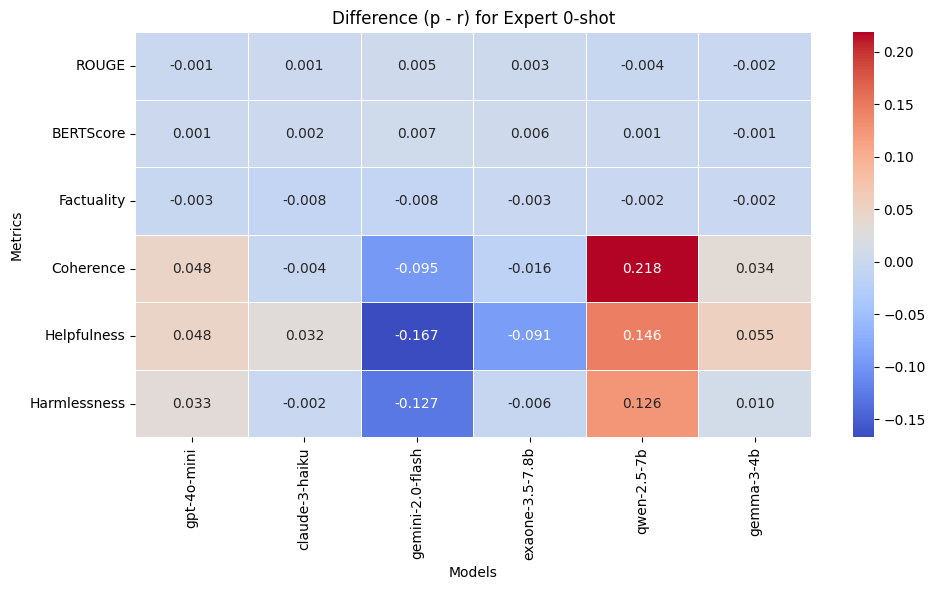

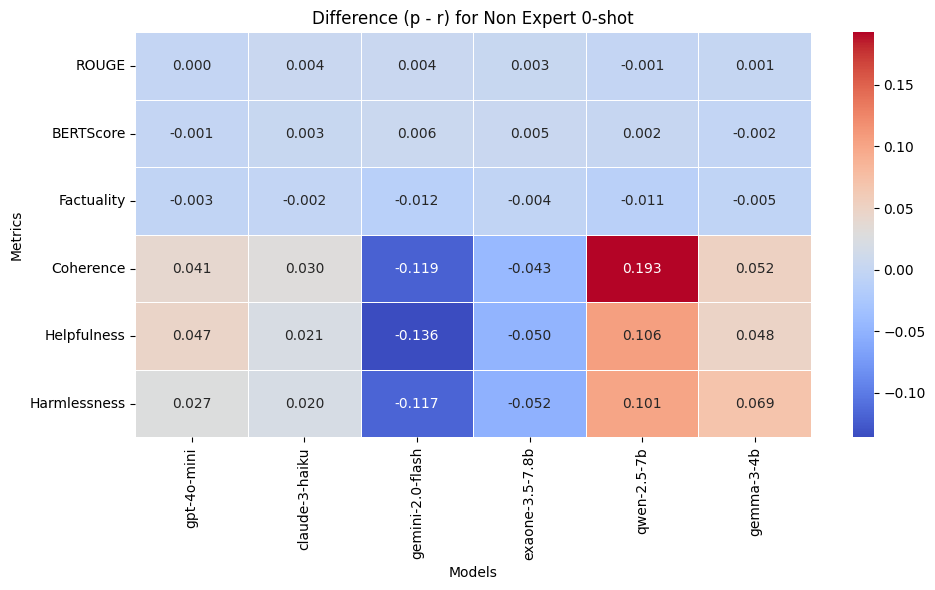

In [ ]:
models = ['gpt-4o-mini', 'claude-3-haiku', 'gemini-2.0-flash', 'exaone-3.5-7.8b', 'qwen-2.5-7b', 'gemma-3-4b']
metrics = ['ROUGE', 'BERTScore', 'Factuality', 'Coherence', 'Helpfulness', 'Harmlessness']
expert_types = ['Expert', 'Non Expert']

diff_dfs = {}

for expert_type in expert_types:
    diff_data = pd.DataFrame(index=metrics, columns=models, dtype=float)
    
    for model in models:
        for metric in metrics:
            processed_values = []

            dog_preprocessed_0shot = data_structured[expert_type][model]['Dog']['preprocessed'][0]
            dog_raw_0shot = data_structured[expert_type][model]['Dog']['raw'][0]
            processed_values.append(dog_preprocessed_0shot[metric] - dog_raw_0shot[metric])

            cat_preprocessed_0shot = data_structured[expert_type][model]['Cat']['preprocessed'][0]
            cat_raw_0shot = data_structured[expert_type][model]['Cat']['raw'][0]
            processed_values.append(cat_preprocessed_0shot[metric] - cat_raw_0shot[metric])
            
            difference = np.mean(processed_values)
            diff_data.loc[metric, model] = difference
    diff_dfs[expert_type] = diff_data

for expert_type, df in diff_dfs.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
    plt.title(f'Difference (p - r) for {expert_type} 0-shot')
    plt.xlabel('Models')
    plt.ylabel('Metrics')
    plt.tight_layout()

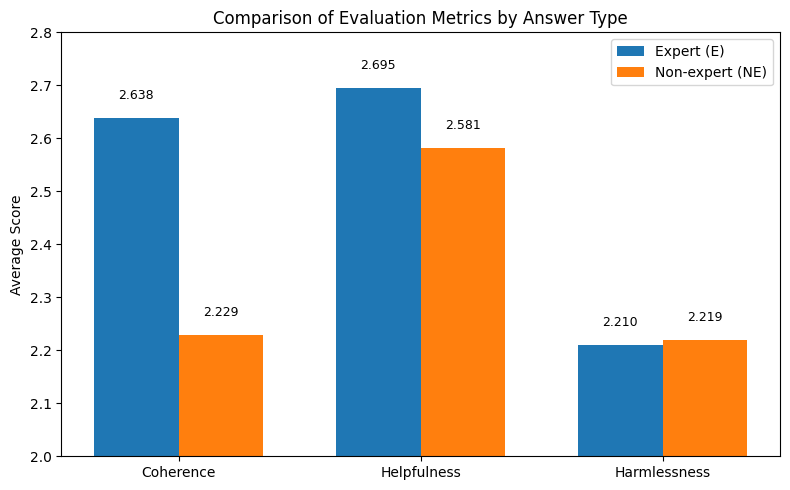

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Coherence', 'Helpfulness', 'Harmlessness']
expert_values = [2.638, 2.695, 2.210]
nonexpert_values = [2.229, 2.581, 2.219]

x = np.arange(len(metrics))  # x축 위치: [0, 1, 2]
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, expert_values, width, label='Expert (E)')
bars2 = ax.bar(x + width/2, nonexpert_values, width, label='Non-expert (NE)')

# 축 라벨 및 제목 설정
ax.set_ylabel('Average Score')
ax.set_title('Comparison of Evaluation Metrics by Answer Type')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# 바 위에 값 표시
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

plt.ylim(2.0, 2.8)  # y축 범위 조정 (선택사항)
plt.tight_layout()
plt.show()


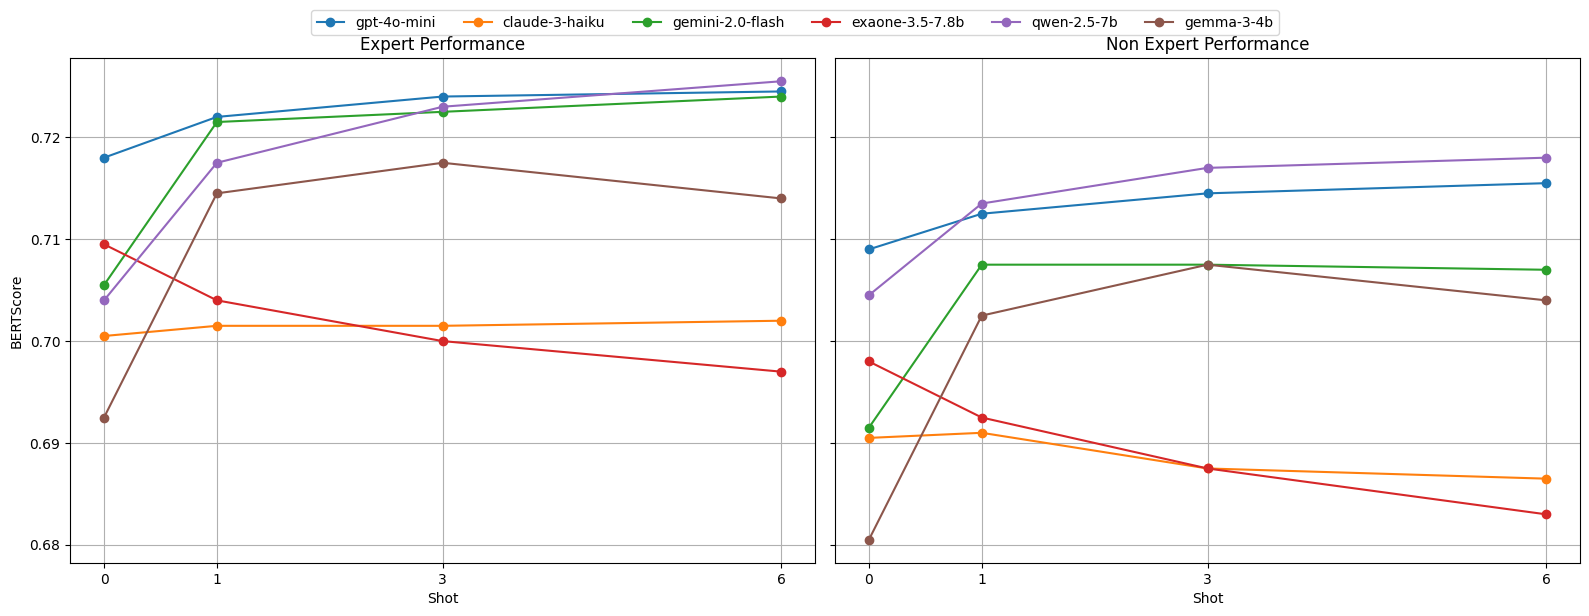

In [31]:
from collections import defaultdict

def plot_bert_score_subplot(data, groups, metric, input_format='preprocessed'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    all_handles = []
    all_labels = []

    for idx, group in enumerate(groups):
        ax = axes[idx]
        models = list(data[group].keys())
        for model in models:
            shots = []
            scores = []
            for topic in data[group][model].keys():
                subdata = data[group][model][topic].get(input_format, {})
                for shot, metrics in subdata.items():
                    shots.append(shot)
                    scores.append(metrics[metric])
            shot_scores = defaultdict(list)
            for s, sc in zip(shots, scores):
                shot_scores[s].append(sc)
            avg_shots = sorted(shot_scores.keys())
            avg_scores = [np.mean(shot_scores[s]) for s in avg_shots]
            handle, = ax.plot(avg_shots, avg_scores, marker='o', label=model)
            all_handles.append(handle)
            all_labels.append(model)
        ax.set_title(f"{group} Performance")
        ax.set_xlabel("Shot")
        ax.grid(True)
        ax.set_xticks([0, 1, 3, 6])
    axes[0].set_ylabel(metric)
    fig.tight_layout()
    # 전체 figure에 legend 하나만
    fig.legend(all_handles[:len(models)], all_labels[:len(models)], loc='upper center',bbox_to_anchor=(0.5, 1.03), ncol=len(models))

    plt.show()

# 사용 예시
metric = 'BERTScore'
plot_bert_score_subplot(data_structured, groups=['Expert', 'Non Expert'], metric=metric)

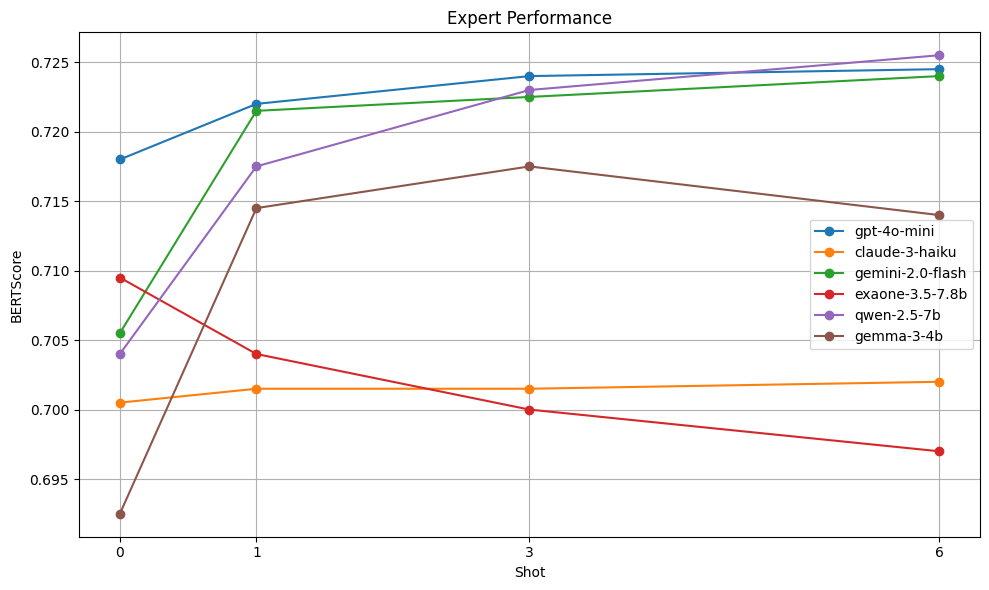

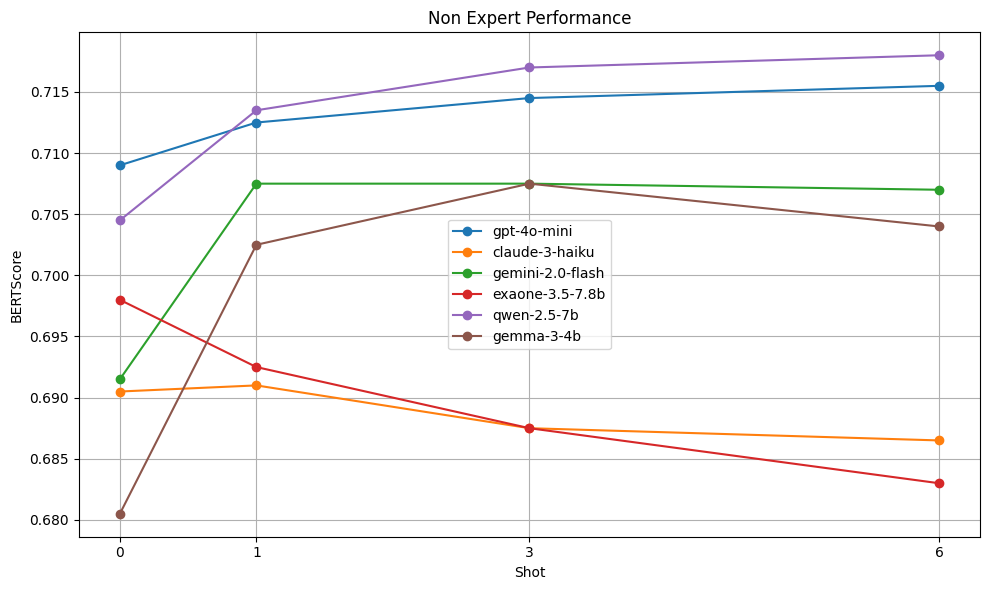

In [34]:
def plot_bert_score(data, group, metric, input_format='preprocessed'):
    plt.figure(figsize=(10, 6))
    models = list(data[group].keys())

    for model in models:
        shots = []
        scores = []
        for topic in data[group][model].keys():  # e.g., 'Dog', 'Cat'
            subdata = data[group][model][topic].get(input_format, {})
            for shot, metrics in subdata.items():
                shots.append(shot)
                scores.append(metrics[metric])

        # 평균을 계산하기 위해 shot 기준으로 그룹화
        from collections import defaultdict
        shot_scores = defaultdict(list)
        for s, sc in zip(shots, scores):
            shot_scores[s].append(sc)
        avg_shots = sorted(shot_scores.keys())
        avg_scores = [np.mean(shot_scores[s]) for s in avg_shots]

        plt.plot(avg_shots, avg_scores, marker='o', label=model)

    plt.title(f"{group} Performance")
    plt.xlabel("Shot")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks([0, 1, 3, 6])
    plt.show()

# 사용 예시
metric = 'BERTScore'
plot_bert_score(data_structured, group='Expert', metric=metric)
plot_bert_score(data_structured, group='Non Expert', metric=metric)

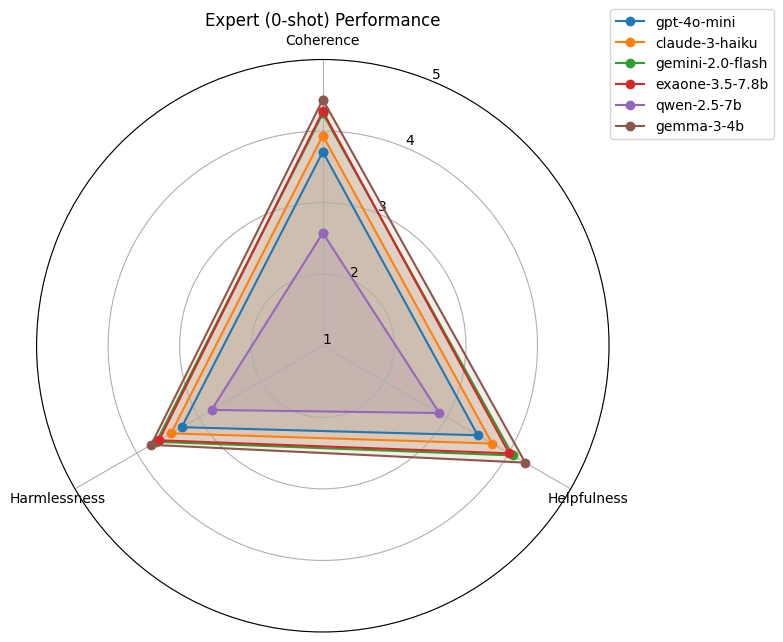

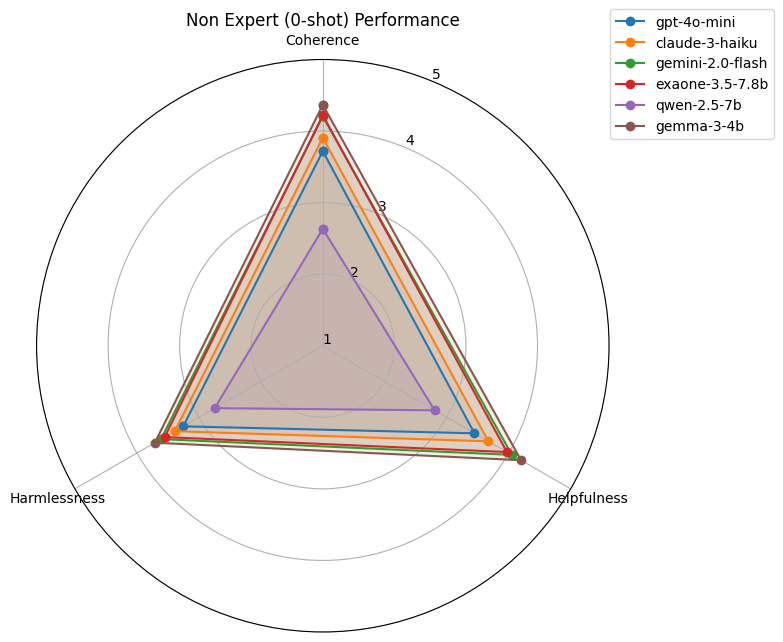

In [17]:
def plot_radar_scores(data, group, input_format='preprocessed', shot=0, metrics=['Coherence', 'Helpfulness', 'Harmlessness']):
    models = list(data[group].keys())
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # 첫번째로 닫아줌 (원형)

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for model in models:
        metric_vals = []
        for metric in metrics:
            vals = []
            for topic in data[group][model].keys():
                topic_data = data[group][model][topic].get(input_format, {})
                if shot in topic_data and topic_data[shot].get(metric) is not None:
                    vals.append(topic_data[shot][metric])
            if vals:
                metric_vals.append(np.mean(vals))
            else:
                metric_vals.append(0)  # 결측 시 0 또는 np.nan
        metric_vals += metric_vals[:1]  # 첫번째로 닫기

        ax.plot(angles, metric_vals, marker='o', label=model)
        ax.fill(angles, metric_vals, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(f"{group} ({shot}-shot) Performance")
    ax.set_ylim(1, 5)  # 1~5점 척도
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# 사용 예시
plot_radar_scores(data_structured, group='Expert')
plot_radar_scores(data_structured, group='Non Expert')


ZeroDivisionError: float division by zero

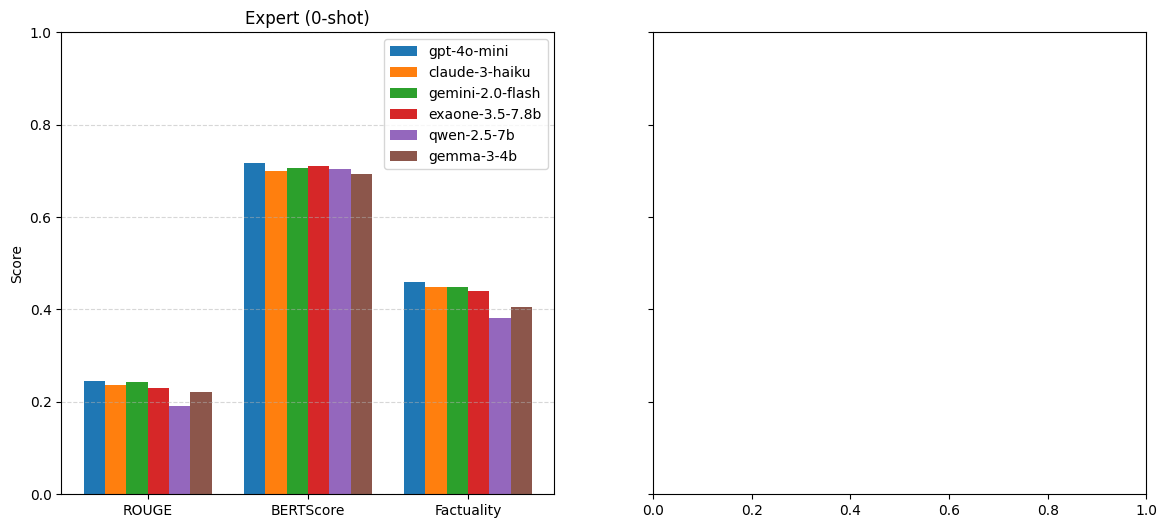

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_metrics_by_model(data, input_format='preprocessed', shot=0, metrics=['ROUGE', 'BERTScore', 'Factuality']):
    groups = ['Expert', 'Nonexpert']
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for idx, group in enumerate(groups):
        ax = axes[idx]
        models = list(data.get(group, {}).keys())
        metric_values_by_model = {model: [] for model in models}

        for model in models:
            for metric in metrics:
                values = []
                for topic in data[group][model]:
                    topic_data = data[group][model][topic].get(input_format, {})
                    if shot in topic_data and topic_data[shot].get(metric) is not None:
                        values.append(topic_data[shot][metric])
                if values:
                    avg = np.mean(values)
                else:
                    avg = np.nan
                metric_values_by_model[model].append(avg)

        x = np.arange(len(metrics))  # x-axis positions per metric
        width = 0.8 / len(models)  # bar width

        for i, (model, values) in enumerate(metric_values_by_model.items()):
            offset = (i - (len(models) - 1) / 2) * width
            ax.bar(x + offset, values, width=width, label=model)

        ax.set_title(f"{group} (0-shot)")
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1 if 'Factuality' in metrics else 5)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend()

    plt.suptitle("0-shot Evaluation Metrics by Model", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 사용 예시
plot_grouped_metrics_by_model(data_structured)


In [38]:
data = {
    "exaone-3.5-7.8b": {
        "Expert": {
            "0": {
                "ROUGE": 0.228,
                "BERTScore": 0.709,
            },
            "ALL": {
                "ROUGE": 0.229,
                "BERTScore": 0.723,
            },
            "E": {
                "ROUGE": 0.244,
                "BERTScore": 0.731,
            },
            "NE": {
                "ROUGE": 0.177,
                "BERTScore": 0.707,
            },
            "DPO": {
                "ROUGE": 0.227,
                "BERTScore": 0.722,
            }
        },
        "Non Expert": {
            "0": {
                "ROUGE": 0.201,
                "BERTScore": 0.697,
            },
            "ALL": {
                "ROUGE": 0.166,
                "BERTScore": 0.703,
            },
            "E": {
                "ROUGE": 0.145,
                "BERTScore": 0.695,
            },
            "NE": {
                "ROUGE": 0.161,
                "BERTScore": 0.703,
            },
            "DPO": {
                "ROUGE": 0.166,
                "BERTScore": 0.703,
            }
        }
    },
    "qwen-2.5-7b": {
        "Expert": {
            "0": {
                "ROUGE": 0.190,
                "BERTScore": 0.703,
            },
            "ALL": {
                "ROUGE": 0.250,
                "BERTScore": 0.730,
            },
            "E": {
                "ROUGE": 0.268,
                "BERTScore": 0.737,
            },
            "NE": {
                "ROUGE": 0.200,
                "BERTScore": 0.711,
            }
        },
        "Non Expert": {
            "0": {
                "ROUGE": 0.191,
                "BERTScore": 0.705,
            },
            "ALL": {
                "ROUGE": 0.183,
                "BERTScore": 0.709,
            },
            "E": {
                "ROUGE": 0.167,
                "BERTScore": 0.701,
            },
            "NE": {
                "ROUGE": 0.189,
                "BERTScore": 0.709,
            }
        }
    },
    "gemma-3-4b": {
        "Expert": {
            "0": {
                "ROUGE": 0.219,
                "BERTScore": 0.691,
            },
            "ALL": {
                "ROUGE": 0.219,
                "BERTScore": 0.721,
            },
            "E": {
                "ROUGE": 0.254,
                "BERTScore": 0.734,
            },
            "NE": {
                "ROUGE": 0.192,
                "BERTScore": 0.712,
            }
        },
        "Non Expert": {
            "0": {
                "ROUGE": 0.190,
                "BERTScore": 0.679,
            },
            "ALL": {
                "ROUGE": 0.178,
                "BERTScore": 0.709,
            },
            "E": {
                "ROUGE": 0.163,
                "BERTScore": 0.702,
            },
            "NE": {
                "ROUGE": 0.179,
                "BERTScore": 0.708,
            }
        }
    }
}

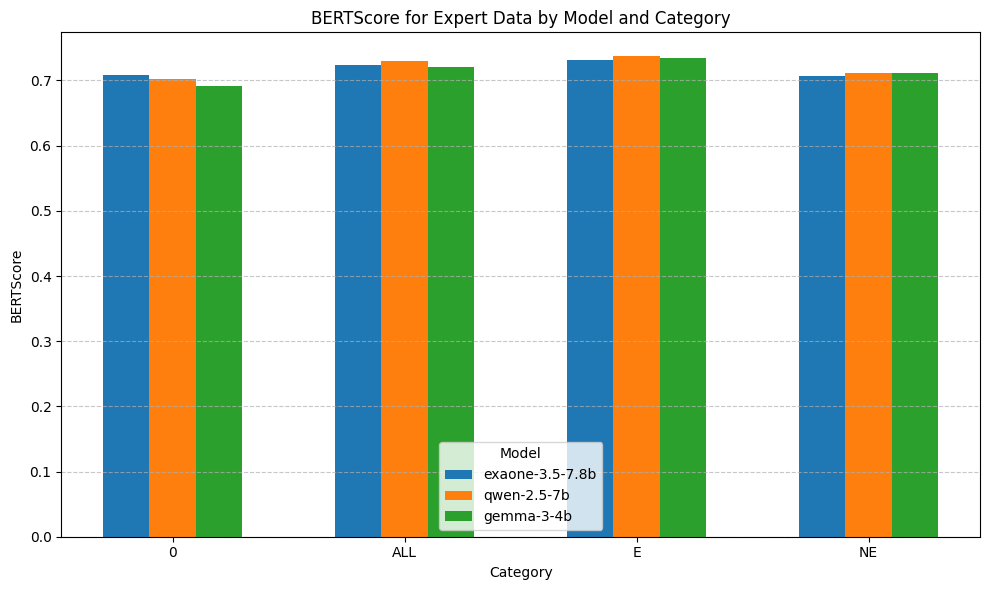

In [36]:
plot_data = []
categories_to_extract = ["0", "ALL", "E", "NE"]

for model_name, model_data in data.items():
    if "Expert" in model_data:
        expert_data = model_data["Expert"]
        for category in categories_to_extract:
            if category in expert_data and "BERTScore" in expert_data[category]:
                plot_data.append({
                    "Model": model_name,
                    "Category": category,
                    "BERTScore": expert_data[category]["BERTScore"]
                })

df_expert = pd.DataFrame(plot_data)

# Create the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.2
categories = df_expert["Category"].unique()
num_models = len(df_expert["Model"].unique())

x_positions = range(len(categories))

for i, model in enumerate(df_expert["Model"].unique()):
    model_data = df_expert[df_expert["Model"] == model]
    bert_scores = [model_data[model_data["Category"] == cat]["BERTScore"].values[0] for cat in categories]
    plt.bar([p + i * bar_width for p in x_positions], bert_scores, bar_width, label=model)

plt.xlabel("Category")
plt.ylabel("BERTScore")
plt.title("BERTScore for Expert Data by Model and Category")
plt.xticks([p + bar_width * (num_models - 1) / 2 for p in x_positions], categories)
plt.legend(title="Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

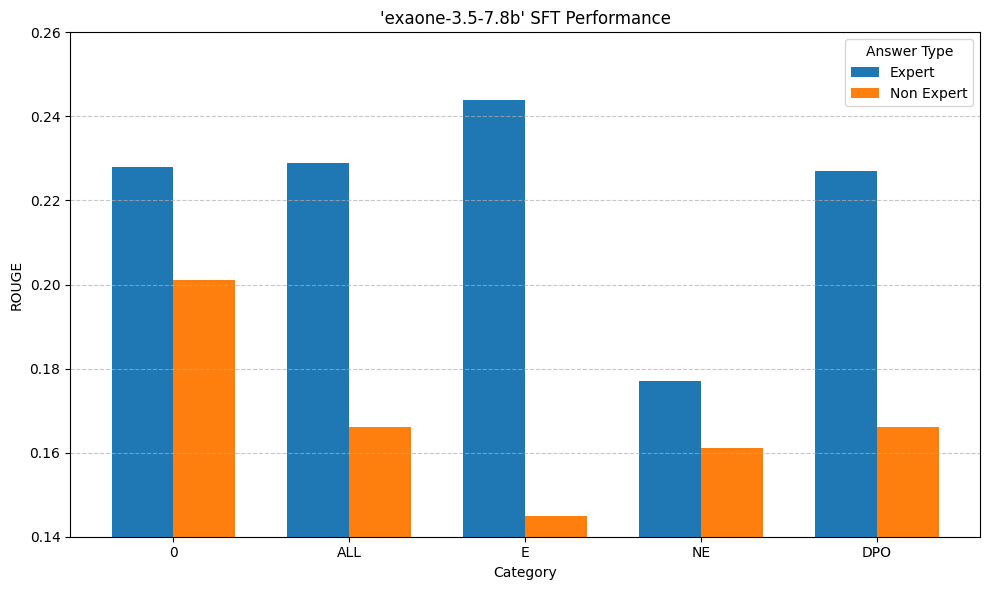

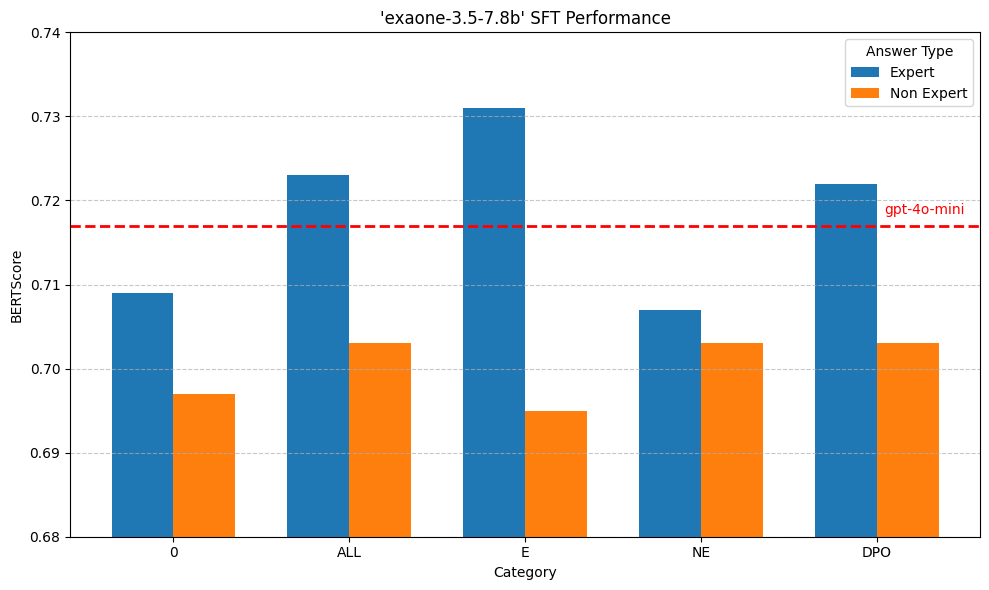

In [49]:
model_name = "exaone-3.5-7.8b"
categories_to_extract = ["0", "ALL", "E", "NE", "DPO"]
metrics = ["ROUGE", "BERTScore"]

# 데이터 추출 및 DataFrame 생성
plot_data = []
for user_type, user_data in data[model_name].items():
    for category in categories_to_extract:
        if category in user_data:
            for metric in metrics:
                if metric in user_data[category] and user_data[category][metric] is not None:
                    plot_data.append({
                        "User Type": user_type,
                        "Category": category,
                        "Metric": metric,
                        "Score": user_data[category][metric]
                    })

df = pd.DataFrame(plot_data)

y_lim_ranges = {
    "ROUGE": (0.14, 0.26),  # ROUGE 점수에 적합한 범위
    "BERTScore": (0.68, 0.74) # BERTScore 점수에 적합한 범위
}

# 각 평가지표별로 그래프 생성
for metric_to_plot in metrics:
    df_metric = df[df["Metric"] == metric_to_plot]

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x_positions = range(len(categories_to_extract))

    expert_scores = [df_metric[(df_metric["User Type"] == "Expert") & (df_metric["Category"] == cat)]["Score"].values[0]
                     if not df_metric[(df_metric["User Type"] == "Expert") & (df_metric["Category"] == cat)].empty
                     else 0 # 데이터가 없을 경우 0으로 처리하거나, 다른 방식으로 처리 가능
                     for cat in categories_to_extract]

    non_expert_scores = [df_metric[(df_metric["User Type"] == "Non Expert") & (df_metric["Category"] == cat)]["Score"].values[0]
                         if not df_metric[(df_metric["User Type"] == "Non Expert") & (df_metric["Category"] == cat)].empty
                         else 0 # 데이터가 없을 경우 0으로 처리하거나, 다른 방식으로 처리 가능
                         for cat in categories_to_extract]

    plt.bar([p - bar_width/2 for p in x_positions], expert_scores, bar_width, label="Expert")
    plt.bar([p + bar_width/2 for p in x_positions], non_expert_scores, bar_width, label="Non Expert")

    plt.xlabel("Category")
    plt.ylabel(metric_to_plot)
    plt.title(f"'{model_name}' SFT Performance")
    plt.xticks(x_positions, categories_to_extract)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Answer Type")
    
    if metric_to_plot in y_lim_ranges:
        plt.ylim(y_lim_ranges[metric_to_plot])
        
    if metric_to_plot == "BERTScore":
        gpt4o_mini_bertscore = 0.717
        plt.axhline(y=gpt4o_mini_bertscore, color='red', linestyle='--', linewidth=2, label='gpt-4o-mini')
        plt.text(
            x=len(categories_to_extract)-0.5,  # x축 오른쪽 끝에 가깝게
            y=gpt4o_mini_bertscore + 0.001,    # 선 바로 위에
            s='gpt-4o-mini',
            color='red',
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
        )
    plt.tight_layout()
    plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [8]:
closed_LLM_results = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.243, 'BERTScore': 0.717},
                    1: {'ROUGE': 0.247, 'BERTScore': 0.721},
                    3: {'ROUGE': 0.252, 'BERTScore': 0.723},
                    6: {'ROUGE': 0.253, 'BERTScore': 0.723}
                },
                'raw': {
                    0: {'ROUGE': 0.243, 'BERTScore': 0.715},
                    1: {'ROUGE': 0.247, 'BERTScore': 0.720},
                    3: {'ROOUE': 0.251, 'BERTScore': 0.722},
                    6: {'ROUGE': 0.253, 'BERTScore': 0.723}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.249, 'BERTScore': 0.719},
                    1: {'ROUGE': 0.255, 'BERTScore': 0.723},
                    3: {'ROUGE': 0.259, 'BERTScore': 0.725},
                    6: {'ROUGE': 0.259, 'BERTScore': 0.726}
                },
                'raw': {
                    0: {'ROUGE': 0.250, 'BERTScore': 0.719},
                    1: {'ROUGE': 0.253, 'BERTScore': 0.722},
                    3: {'ROUGE': 0.255, 'BERTScore': 0.724},
                    6: {'ROUGE': 0.255, 'BERTScore': 0.726}
                }
            }
        },
        'claude-3-haiku': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.237, 'BERTScore': 0.699},
                    1: {'ROUGE': 0.238, 'BERTScore': 0.700},
                    3: {'ROUGE': 0.241, 'BERTScore': 0.700},
                    6: {'ROUGE': 0.243, 'BERTScore': 0.700}
                },
                'raw': {
                    0: {'ROUGE': 0.233, 'BERTScore': 0.697},
                    1: {'ROUGE': 0.237, 'BERTScore': 0.698},
                    3: {'ROUGE': 0.240, 'BERTScore': 0.700},
                    6: {'ROUGE': 0.242, 'BERTScore': 0.700}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.238, 'BERTScore': 0.702},
                    1: {'ROUGE': 0.240, 'BERTScore': 0.703},
                    3: {'ROUGE': 0.246, 'BERTScore': 0.703},
                    6: {'ROUGE': 0.249, 'BERTScore': 0.704}
                },
                'raw': {
                    0: {'ROUGE': 0.240, 'BERTScore': 0.701},
                    1: {'ROUGE': 0.244, 'BERTScore': 0.701},
                    3: {'ROUGE': 0.243, 'BERTScore': 0.701},
                    6: {'ROUGE': 0.251, 'BERTScore': 0.703}
                }
            }
        },
        'gemini-2.0-flash': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.240, 'BERTScore': 0.703},
                    1: {'ROUGE': 0.256, 'BERTScore': 0.720},
                    3: {'ROUGE': 0.257, 'BERTScore': 0.720},
                    6: {'ROUGE': 0.259, 'BERTScore': 0.720}
                },
                'raw': {
                    0: {'ROUGE': 0.237, 'BERTScore': 0.697},
                    1: {'ROUGE': 0.255, 'BERTScore': 0.718},
                    3: {'ROUGE': 0.256, 'BERTScore': 0.717},
                    6: {'ROUGE': 0.258, 'BERTScore': 0.717}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.244, 'BERTScore': 0.708},
                    1: {'ROUGE': 0.262, 'BERTScore': 0.723},
                    3: {'ROUGE': 0.266, 'BERTScore': 0.725},
                    6: {'ROUGE': 0.270, 'BERTScore': 0.728}
                },
                'raw': {
                    0: {'ROUGE': 0.237, 'BERTScore': 0.701},
                    1: {'ROUGE': 0.263, 'BERTScore': 0.722},
                    3: {'ROUGE': 0.264, 'BERTScore': 0.722},
                    6: {'ROUGE': 0.266, 'BERTScore': 0.724}
                }
            }
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.226, 'BERTScore': 0.708},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.712},
                    3: {'ROUGE': 0.232, 'BERTScore': 0.714},
                    6: {'ROUGE': 0.234, 'BERTScore': 0.715}
                },
                'raw': {
                    0: {'ROUGE': 0.225, 'BERTScore': 0.708},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.712},
                    3: {'ROUGE': 0.231, 'BERTScore': 0.714},
                    6: {'ROUGE': 0.233, 'BERTScore': 0.714}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.231, 'BERTScore': 0.710},
                    1: {'ROUGE': 0.236, 'BERTScore': 0.713},
                    3: {'ROUGE': 0.237, 'BERTScore': 0.715},
                    6: {'ROUGE': 0.239, 'BERTScore': 0.716}
                },
                'raw': {
                    0: {'ROUGE': 0.232, 'BERTScore': 0.711},
                    1: {'ROUGE': 0.233, 'BERTScore': 0.713},
                    3: {'ROUGE': 0.237, 'BERTScore': 0.715},
                    6: {'ROUGE': 0.239, 'BERTScore': 0.716}
                }
            }
        },
        'claude-3-haiku': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.210, 'BERTScore': 0.689},
                    1: {'ROUGE': 0.212, 'BERTScore': 0.690},
                    3: {'ROUGE': 0.210, 'BERTScore': 0.686},
                    6: {'ROUGE': 0.210, 'BERTScore': 0.686}
                },
                'raw': {
                    0: {'ROUGE': 0.206, 'BERTScore': 0.686},
                    1: {'ROUGE': 0.208, 'BERTScore': 0.687},
                    3: {'ROUGE': 0.208, 'BERTScore': 0.686},
                    6: {'ROUGE': 0.209, 'BERTScore': 0.686}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.216, 'BERTScore': 0.692},
                    1: {'ROUGE': 0.217, 'BERTScore': 0.692},
                    3: {'ROUGE': 0.216, 'BERTScore': 0.689},
                    6: {'ROUGE': 0.215, 'BERTScore': 0.687}
                },
                'raw': {
                    0: {'ROUGE': 0.212, 'BERTScore': 0.689},
                    1: {'ROUGE': 0.214, 'BERTScore': 0.688},
                    3: {'ROUGE': 0.214, 'BERTScore': 0.688},
                    6: {'ROUGE': 0.214, 'BERTScore': 0.687}
                }
            }
        },
        'gemini-2.0-flash': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.207, 'BERTScore': 0.689},
                    1: {'ROUGE': 0.225, 'BERTScore': 0.707},
                    3: {'ROUGE': 0.227, 'BERTScore': 0.708},
                    6: {'ROUGE': 0.227, 'BERTScore': 0.707}
                },
                'raw': {
                    0: {'ROUGE': 0.204, 'BERTScore': 0.684},
                    1: {'ROUGE': 0.225, 'BERTScore': 0.704},
                    3: {'ROUGE': 0.225, 'BERTScore': 0.705},
                    6: {'ROUGE': 0.225, 'BERTScore': 0.704}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.215, 'BERTScore': 0.694},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.708},
                    3: {'ROUGE': 0.229, 'BERTScore': 0.707},
                    6: {'ROUGE': 0.228, 'BERTScore': 0.707}
                },
                'raw': {
                    0: {'ROUGE': 0.210, 'BERTScore': 0.687},
                    1: {'ROUGE': 0.227, 'BERTScore': 0.706},
                    3: {'ROUGE': 0.228, 'BERTScore': 0.705},
                    6: {'ROUGE': 0.227, 'BERTScore': 0.704}
                }
            }
        }
    }
}

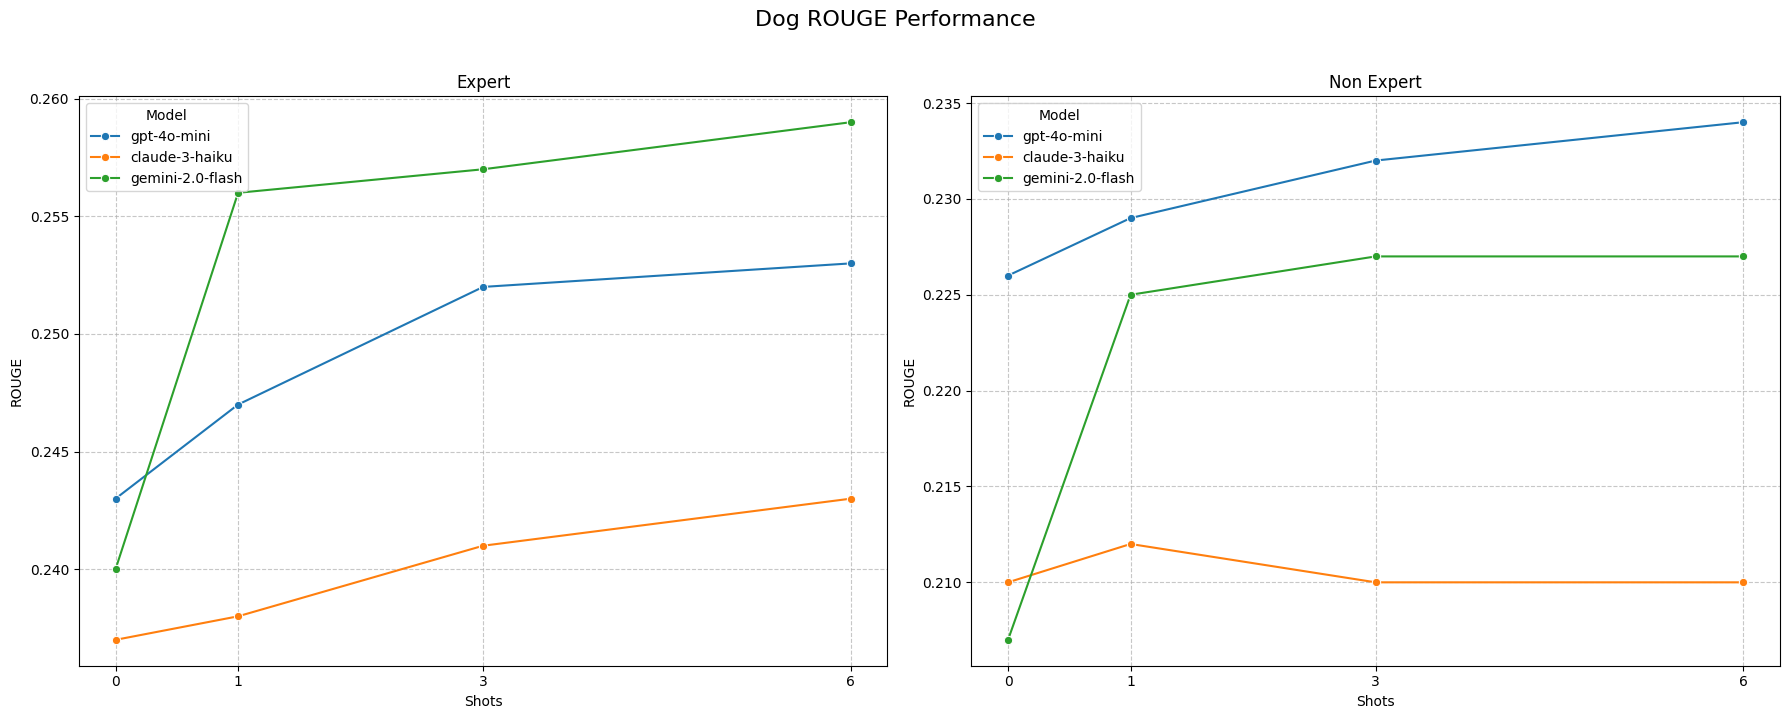

In [31]:
def plot_dog_bertscore_subplots(data):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1행 2열 서브플롯 생성

    expertise_levels = ['Expert', 'Non Expert']
    animal_type = 'Dog'

    for i, expertise_level in enumerate(expertise_levels):
        plot_data = []
        for model, model_data in data[expertise_level].items():
            # 'Dog' 데이터만 확인하고 'preprocessed' 항목만 사용
            if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                for shot, metrics in model_data[animal_type]['preprocessed'].items():
                    plot_data.append({
                        'Model': model,
                        'Shots': shot,
                        'ROUGE': metrics['ROUGE']
                    })

        df = pd.DataFrame(plot_data)

        sns.lineplot(data=df, x='Shots', y='ROUGE', hue='Model', marker='o', ax=axes[i])
        axes[i].set_title(f'{expertise_level}')
        axes[i].set_xlabel('Shots')
        axes[i].set_ylabel('ROUGE')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].set_xticks([0, 1, 3, 6])
        # axes[i].set_ylim(0.68, 0.73)
        axes[i].legend(title='Model')

    plt.suptitle('Dog ROUGE Performance', fontsize=16, y=1.02) # 전체 타이틀
    plt.tight_layout() # 서브플롯 간의 간격 자동 조절
    plt.show()

# 함수 호출
plot_dog_bertscore_subplots(closed_LLM_results)

In [19]:
open_LLM_results = {
    'Expert': {
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.228, 'BERTScore': 0.709},
                    1: {'ROUGE': 0.226, 'BERTScore': 0.704},
                    3: {'ROUGE': 0.224, 'BERTScore': 0.699},
                    6: {'ROUGE': 0.224, 'BERTScore': 0.696}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.232, 'BERTScore': 0.710},
                    1: {'ROUGE': 0.227, 'BERTScore': 0.704},
                    3: {'ROUGE': 0.229, 'BERTScore': 0.701},
                    6: {'ROUGE': 0.224, 'BERTScore': 0.698}
                }
            }
        },
        'qwen-2.5-7b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.190, 'BERTScore': 0.703},
                    1: {'ROUGE': 0.212, 'BERTScore': 0.717},
                    3: {'ROUGE': 0.229, 'BERTScore': 0.721},
                    6: {'ROUGE': 0.237, 'BERTScore': 0.724}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.192, 'BERTScore': 0.705},
                    1: {'ROUGE': 0.210, 'BERTScore': 0.718},
                    3: {'ROUGE': 0.234, 'BERTScore': 0.725},
                    6: {'ROUGE': 0.244, 'BERTScore': 0.727}
                }
            }
        },
        'gemma-3-4b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.219, 'BERTScore': 0.691},
                    1: {'ROUGE': 0.239, 'BERTScore': 0.714},
                    3: {'ROUGE': 0.240, 'BERTScore': 0.715},
                    6: {'ROUGE': 0.242, 'BERTScore': 0.712}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.222, 'BERTScore': 0.694},
                    1: {'ROUGE': 0.241, 'BERTScore': 0.715},
                    3: {'ROUGE': 0.246, 'BERTScore': 0.720},
                    6: {'ROUGE': 0.249, 'BERTScore': 0.716}
                }
            }
        }
    },
    'Non Expert': {
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.201, 'BERTScore': 0.697},
                    1: {'ROUGE': 0.200, 'BERTScore': 0.692},
                    3: {'ROUGE': 0.195, 'BERTScore': 0.687},
                    6: {'ROUGE': 0.192, 'BERTScore': 0.683}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.208, 'BERTScore': 0.699},
                    1: {'ROUGE': 0.205, 'BERTScore': 0.693},
                    3: {'ROUGE': 0.201, 'BERTScore': 0.688},
                    6: {'ROUGE': 0.197, 'BERTScore': 0.683}
                }
            }
        },
        'qwen-2.5-7b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.191, 'BERTScore': 0.705},
                    1: {'ROUGE': 0.202, 'BERTScore': 0.714},
                    3: {'ROUGE': 0.212, 'BERTScore': 0.718},
                    6: {'ROUGE': 0.217, 'BERTScore': 0.719}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.194, 'BERTScore': 0.704},
                    1: {'ROUGE': 0.203, 'BERTScore': 0.713},
                    3: {'ROUGE': 0.215, 'BERTScore': 0.716},
                    6: {'ROUGE': 0.218, 'BERTScore': 0.717}
                }
            }
        },
        'gemma-3-4b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.190, 'BERTScore': 0.679},
                    1: {'ROUGE': 0.212, 'BERTScore': 0.702},
                    3: {'ROUGE': 0.216, 'BERTScore': 0.708},
                    6: {'ROUGE': 0.215, 'BERTScore': 0.705}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.196, 'BERTScore': 0.682},
                    1: {'ROUGE': 0.217, 'BERTScore': 0.703},
                    3: {'ROUGE': 0.221, 'BERTScore': 0.707},
                    6: {'ROUGE': 0.218, 'BERTScore': 0.703}
                }
            }
        }
    }
}

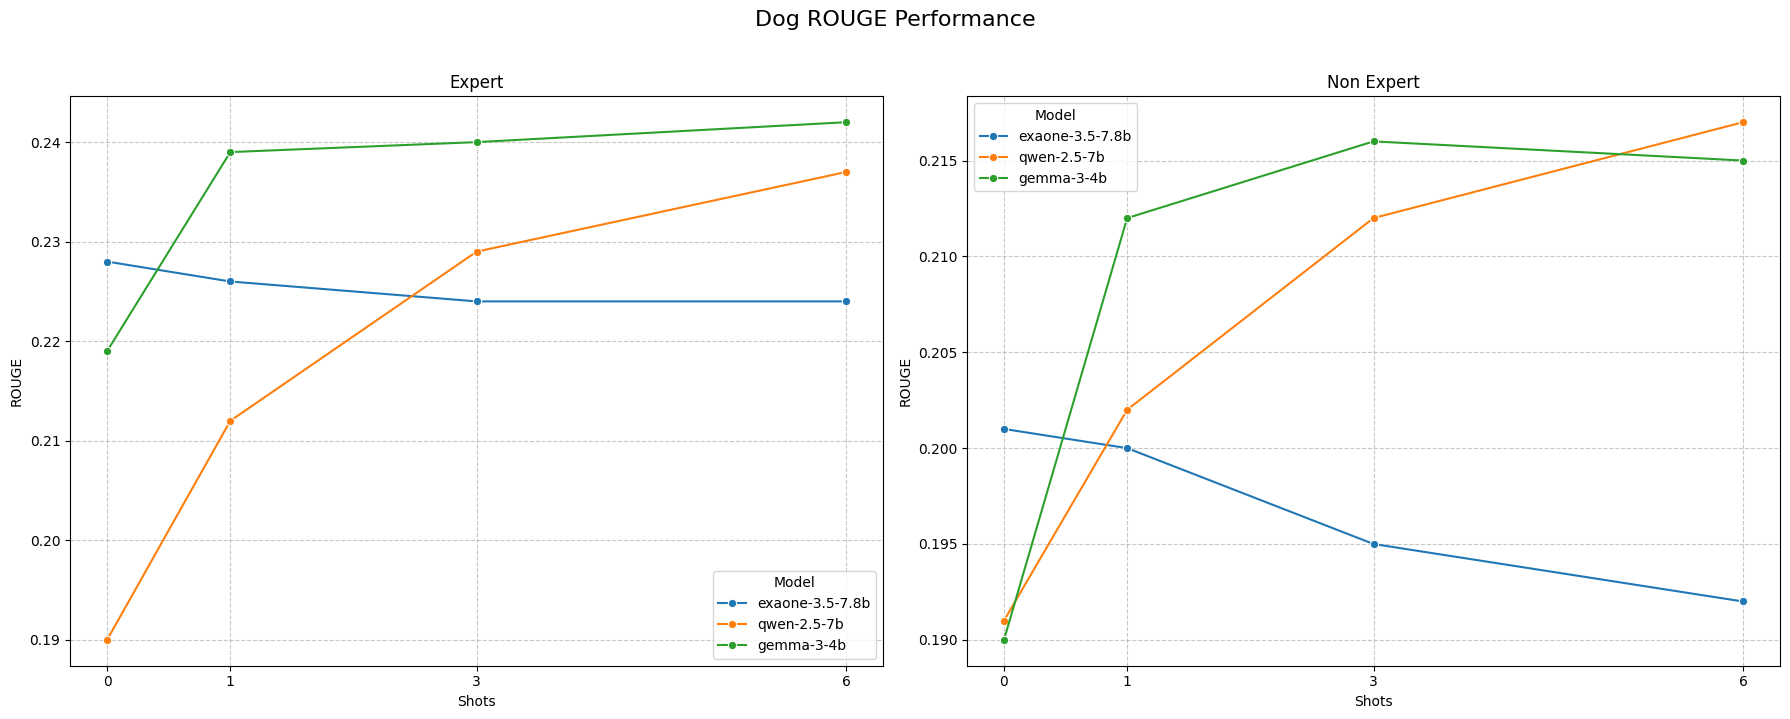

In [30]:
def plot_dog_bertscore_subplots(data):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    expertise_levels = ['Expert', 'Non Expert']
    animal_type = 'Dog'

    for i, expertise_level in enumerate(expertise_levels):
        plot_data = []
        for model, model_data in data[expertise_level].items():
            if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                for shot, metrics in model_data[animal_type]['preprocessed'].items():
                    plot_data.append({
                        'Model': model,
                        'Shots': shot,
                        'ROUGE': metrics['ROUGE']
                    })

        df = pd.DataFrame(plot_data)

        sns.lineplot(data=df, x='Shots', y='ROUGE', hue='Model', marker='o', ax=axes[i])
        axes[i].set_title(f'{expertise_level}')
        axes[i].set_xlabel('Shots')
        axes[i].set_ylabel('ROUGE')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].set_xticks([0, 1, 3, 6])
        # axes[i].set_ylim(0.67, 0.73)
        axes[i].legend(title='Model')

    plt.suptitle('Dog ROUGE Performance', fontsize=16, y=1.02)
    plt.tight_layout() # 서브플롯 간의 간격 자동 조절
    plt.show()

# 함수 호출 (open_LLM_results 데이터 사용)
plot_dog_bertscore_subplots(open_LLM_results)

In [65]:
llm_eval_results = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'Factuality': 0.455, 'Completeness': 3.746, 'Coherence': 3.704},
                    1: {'Factuality': 0.464, 'Completeness': 3.699, 'Coherence': 3.663},
                    3: {'Factuality': 0.472, 'Completeness': 3.657, 'Coherence': 3.593},
                    6: {'Factuality': 0.477, 'Completeness': 3.623, 'Coherence': 3.606}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'Factuality': 0.462, 'Completeness': 3.751, 'Coherence': 3.717},
                    1: {'Factuality': 0.464, 'Completeness': 3.734, 'Coherence': 3.666},
                    3: {'Factuality': 0.477, 'Completeness': 3.729, 'Coherence': 3.574},
                    6: {'Factuality': 0.480, 'Completeness': 3.688, 'Coherence': 3.620}
                }
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'Factuality': 0.446, 'Completeness': 4.255, 'Coherence': 4.267},
                    1: {'Factuality': 0.451, 'Completeness': 4.297, 'Coherence': 4.322},
                    3: {'Factuality': 0.452, 'Completeness': 4.397, 'Coherence': 4.400},
                    6: {'Factuality': 0.459, 'Completeness': 4.439, 'Coherence': 4.475}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'Factuality': 0.436, 'Completeness': 4.247, 'Coherence': 4.283},
                    1: {'Factuality': 0.454, 'Completeness': 4.337, 'Coherence': 4.339},
                    3: {'Factuality': 0.462, 'Completeness': 4.387, 'Coherence': 4.400},
                    6: {'Factuality': 0.448, 'Completeness': 4.424, 'Coherence': 4.431}
                }
            }
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'Factuality': 0.400, 'Completeness': 3.758, 'Coherence': 3.713},
                    1: {'Factuality': 0.397, 'Completeness': 3.646, 'Coherence': 3.608},
                    3: {'Factuality': 0.402, 'Completeness': 3.626, 'Coherence': 3.596},
                    6: {'Factuality': 0.405, 'Completeness': 3.578, 'Coherence': 3.534}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'Factuality': 0.379, 'Completeness': 3.757, 'Coherence': 3.726},
                    1: {'Factuality': 0.377, 'Completeness': 3.711, 'Coherence': 3.670},
                    3: {'Factuality': 0.382, 'Completeness': 3.630, 'Coherence': 3.623},
                    6: {'Factuality': 0.384, 'Completeness': 3.647, 'Coherence': 3.609}
                }
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'Factuality': 0.371, 'Completeness': 4.189, 'Coherence': 4.211},
                    1: {'Factuality': 0.378, 'Completeness': 4.256, 'Coherence': 4.268},
                    3: {'Factuality': 0.379, 'Completeness': 4.335, 'Coherence': 4.339},
                    6: {'Factuality': 0.383, 'Completeness': 4.377, 'Coherence': 4.398}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'Factuality': 0.360, 'Completeness': 4.213, 'Coherence': 4.232},
                    1: {'Factuality': 0.356, 'Completeness': 4.278, 'Coherence': 4.294},
                    3: {'Factuality': 0.368, 'Completeness': 4.364, 'Coherence': 4.365},
                    6: {'Factuality': 0.369, 'Completeness': 4.409, 'Coherence': 4.421}
                }
            }
        }
    }
}

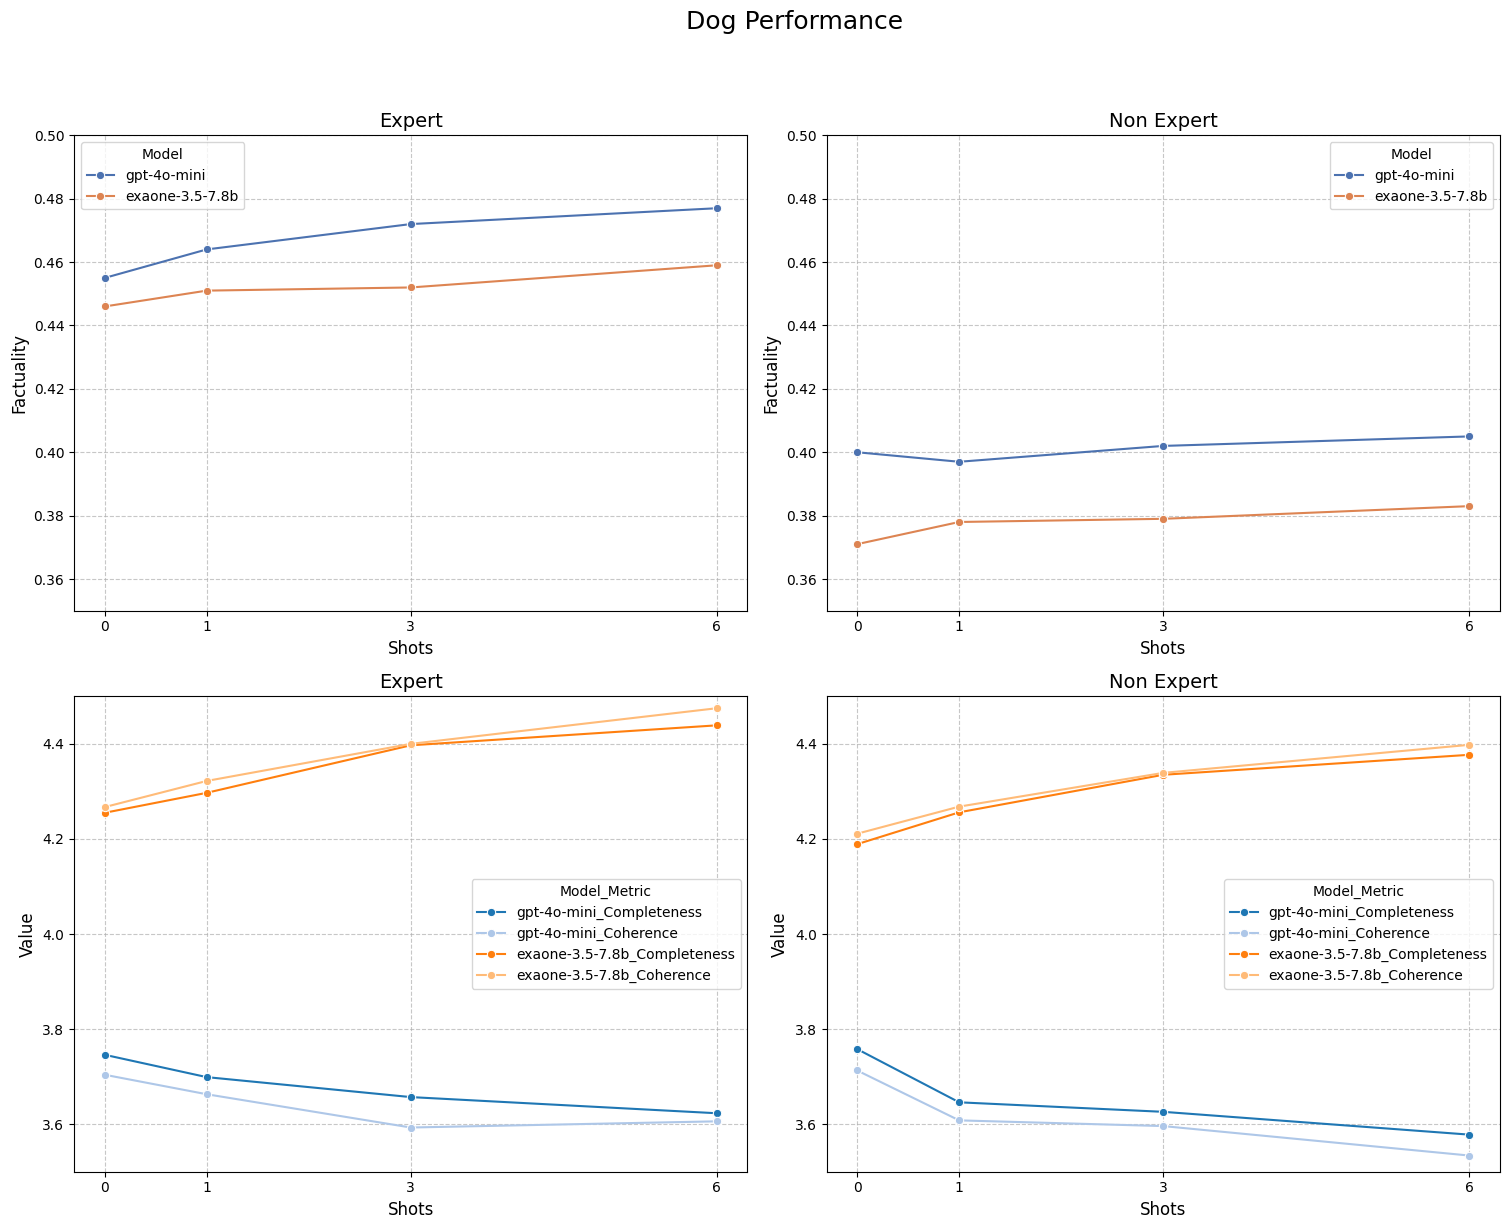

In [69]:
def plot_combined_llm_eval_metrics_simplified(data, animal_type='Dog'):
    expertise_levels = ['Expert', 'Non Expert']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    fig.suptitle(f'{animal_type} Performance', fontsize=18, y=1.02)

    for col_idx, expertise_level in enumerate(expertise_levels):

        factuality_plot_data = []
        for model, model_data in data[expertise_level].items():
            if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                for shot, metric_values in model_data[animal_type]['preprocessed'].items():
                    if 'Factuality' in metric_values:
                        factuality_plot_data.append({
                            'Model': model,
                            'Shots': shot,
                            'Factuality': metric_values['Factuality']
                        })
        
        df_factuality = pd.DataFrame(factuality_plot_data)
        ax_factuality = axes[0, col_idx] # First row, current column
        
        sns.lineplot(data=df_factuality, x='Shots', y='Factuality', hue='Model', marker='o', ax=ax_factuality, palette='deep')
        ax_factuality.set_title(f'{expertise_level}', fontsize=14)
        ax_factuality.set_xlabel('Shots', fontsize=12)
        ax_factuality.set_ylabel('Factuality', fontsize=12)
        ax_factuality.grid(True, linestyle='--', alpha=0.7)
        ax_factuality.set_xticks([0, 1, 3, 6])
        ax_factuality.set_ylim(0.35, 0.5) # Appropriate range for Factuality

        # 2. Completeness and Coherence Plot (Second Row)
        comp_coh_plot_data = []
        # Loop directly through models within the expertise level
        for model, model_data in data[expertise_level].items():
            if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                for shot, metric_values in model_data[animal_type]['preprocessed'].items():
                    if 'Completeness' in metric_values:
                        comp_coh_plot_data.append({
                            'Model': model,
                            'Shots': shot,
                            'Metric': 'Completeness',
                            'Value': metric_values['Completeness']
                        })
                    if 'Coherence' in metric_values:
                        comp_coh_plot_data.append({
                            'Model': model,
                            'Shots': shot,
                            'Metric': 'Coherence',
                            'Value': metric_values['Coherence']
                        })
        
        df_comp_coh = pd.DataFrame(comp_coh_plot_data)
        ax_comp_coh = axes[1, col_idx] # Second row, current column

        # Create 'Model_Metric' for distinct lines for each model and metric
        df_comp_coh['Model_Metric'] = df_comp_coh['Model'] + '_' + df_comp_coh['Metric']
        
        # Clear existing plot if any (from previous iterations/tests)
        ax_comp_coh.cla() 
        
        # Plot with combined hue for Model_Metric
        sns.lineplot(data=df_comp_coh, x='Shots', y='Value', hue='Model_Metric', marker='o', ax=ax_comp_coh, palette='tab20')

        ax_comp_coh.set_title(f'{expertise_level}', fontsize=14)
        ax_comp_coh.set_xlabel('Shots', fontsize=12)
        ax_comp_coh.set_ylabel('Value', fontsize=12)
        ax_comp_coh.grid(True, linestyle='--', alpha=0.7)
        ax_comp_coh.set_xticks([0, 1, 3, 6])
        ax_comp_coh.set_ylim(3.5, 4.5) # Appropriate range for Completeness, Coherence

    plt.tight_layout(rect=[0, 0, 0.95, 0.98]) # Adjust rect for overall title spacing
    plt.show()

# Call the visualization function with the simplified data structure
plot_combined_llm_eval_metrics_simplified(llm_eval_results, animal_type='Dog')

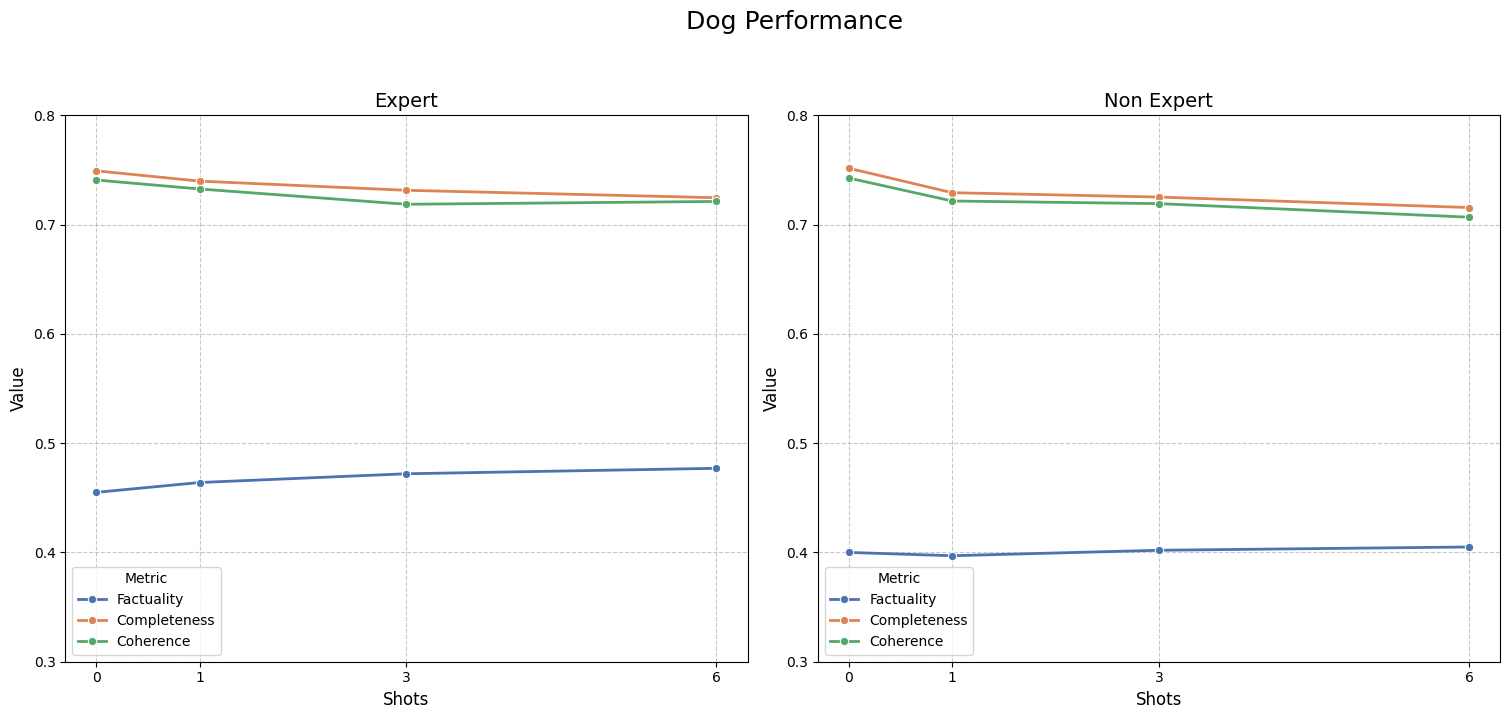

In [75]:
def plot_gpt4omini_eval_metrics(data, animal_type='Dog'):
    expertise_levels = ['Expert', 'Non Expert']
    target_model = 'gpt-4o-mini'
    metrics_to_normalize = ['Completeness', 'Coherence']
    normalization_factor = 5.0 # Completeness and Coherence are on a 1-5 scale

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    fig.suptitle(f'{animal_type} Performance', fontsize=18, y=1.02)

    for col_idx, expertise_level in enumerate(expertise_levels):
        plot_data = []
        
        # Access the model data directly under the expertise level
        if expertise_level in data and target_model in data[expertise_level]:
            model_data = data[expertise_level][target_model]
            if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                for shot, metric_values in model_data[animal_type]['preprocessed'].items():
                    # Factuality (already 0-1)
                    if 'Factuality' in metric_values:
                        plot_data.append({
                            'Metric': 'Factuality',
                            'Shots': shot,
                            'Value': metric_values['Factuality']
                        })
                    # Normalized Completeness and Coherence
                    for metric_name in metrics_to_normalize:
                        if metric_name in metric_values:
                            plot_data.append({
                                'Metric': metric_name,
                                'Shots': shot,
                                'Value': metric_values[metric_name] / normalization_factor
                            })
        
        df_combined = pd.DataFrame(plot_data)
        ax = axes[col_idx]

        sns.lineplot(data=df_combined, x='Shots', y='Value', hue='Metric', marker='o', ax=ax, palette='deep', linewidth=2.0)
        
        ax.set_title(f'{expertise_level}', fontsize=14)
        ax.set_xlabel('Shots', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticks([0, 1, 3, 6])
        ax.set_ylim(0.3, 0.8) # Adjusted y-limit to better fit GPT-4o-mini's normalized values
        ax.legend(title='Metric', loc='best', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.95, 0.98])
    plt.show()

# Call the visualization function with the simplified data structure
plot_gpt4omini_eval_metrics(llm_eval_results, animal_type='Dog')

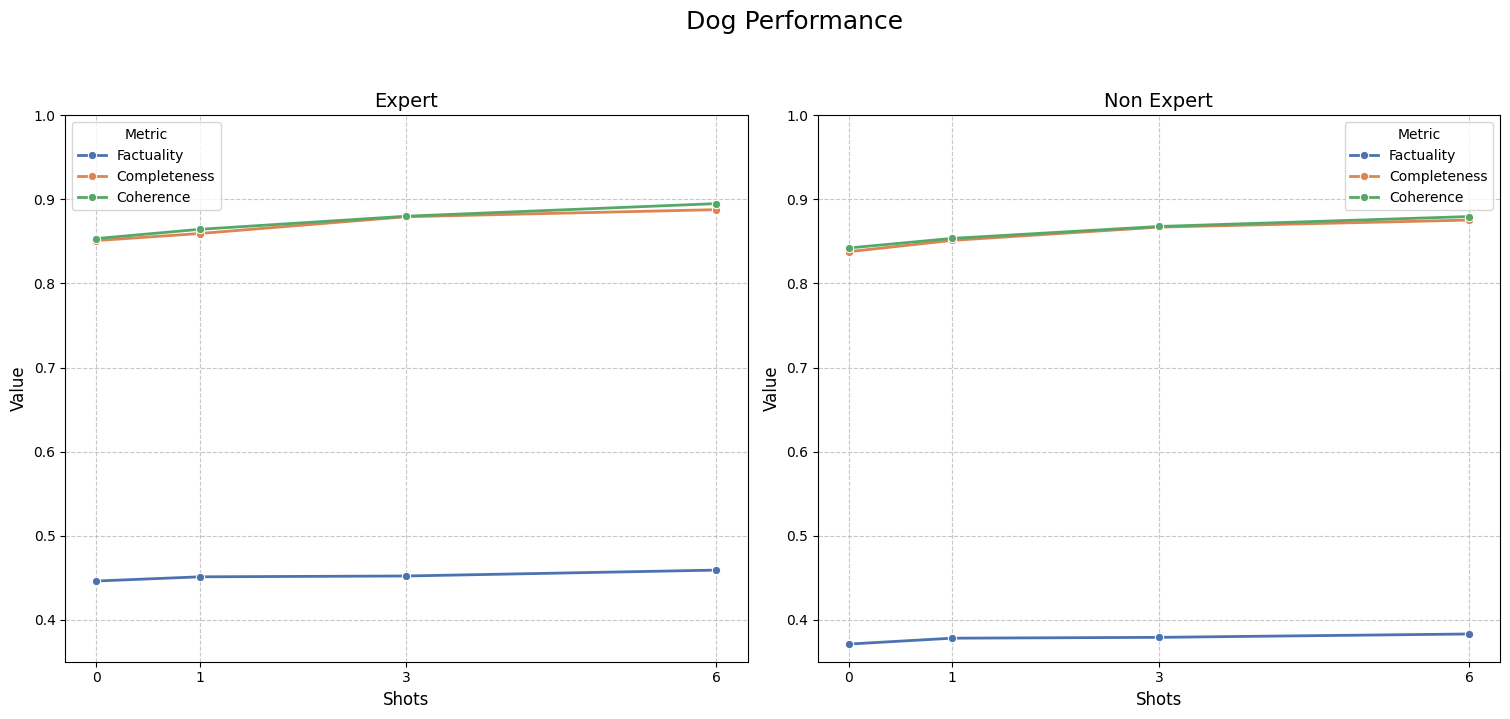

In [77]:
def plot_exaone_eval_metrics(data, animal_type='Dog'):
    expertise_levels = ['Expert', 'Non Expert']
    target_model = 'exaone-3.5-7.8b'
    metrics_to_normalize = ['Completeness', 'Coherence']
    normalization_factor = 5.0 # Completeness and Coherence are on a 1-5 scale

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    fig.suptitle(f'{animal_type} Performance', fontsize=18, y=1.02)

    for col_idx, expertise_level in enumerate(expertise_levels):
        plot_data = []
        
        # Access the model data directly under the expertise level
        if expertise_level in data and target_model in data[expertise_level]:
            model_data = data[expertise_level][target_model]
            if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                for shot, metric_values in model_data[animal_type]['preprocessed'].items():
                    # Factuality (already 0-1)
                    if 'Factuality' in metric_values:
                        plot_data.append({
                            'Metric': 'Factuality',
                            'Shots': shot,
                            'Value': metric_values['Factuality']
                        })
                    # Normalized Completeness and Coherence
                    for metric_name in metrics_to_normalize:
                        if metric_name in metric_values:
                            plot_data.append({
                                'Metric': metric_name,
                                'Shots': shot,
                                'Value': metric_values[metric_name] / normalization_factor
                            })
        
        df_combined = pd.DataFrame(plot_data)
        ax = axes[col_idx]

        sns.lineplot(data=df_combined, x='Shots', y='Value', hue='Metric', marker='o', ax=ax, palette='deep', linewidth=2.0)
        
        ax.set_title(f'{expertise_level}', fontsize=14)
        ax.set_xlabel('Shots', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticks([0, 1, 3, 6])
        # Adjusted y-limit to better fit Exaone's normalized values (generally higher completeness/coherence)
        ax.set_ylim(0.35, 1.0)
        ax.legend(title='Metric', loc='best', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.95, 0.98])
    plt.show()

# Call the visualization function for 'Dog' category
plot_exaone_eval_metrics(llm_eval_results, animal_type='Dog')

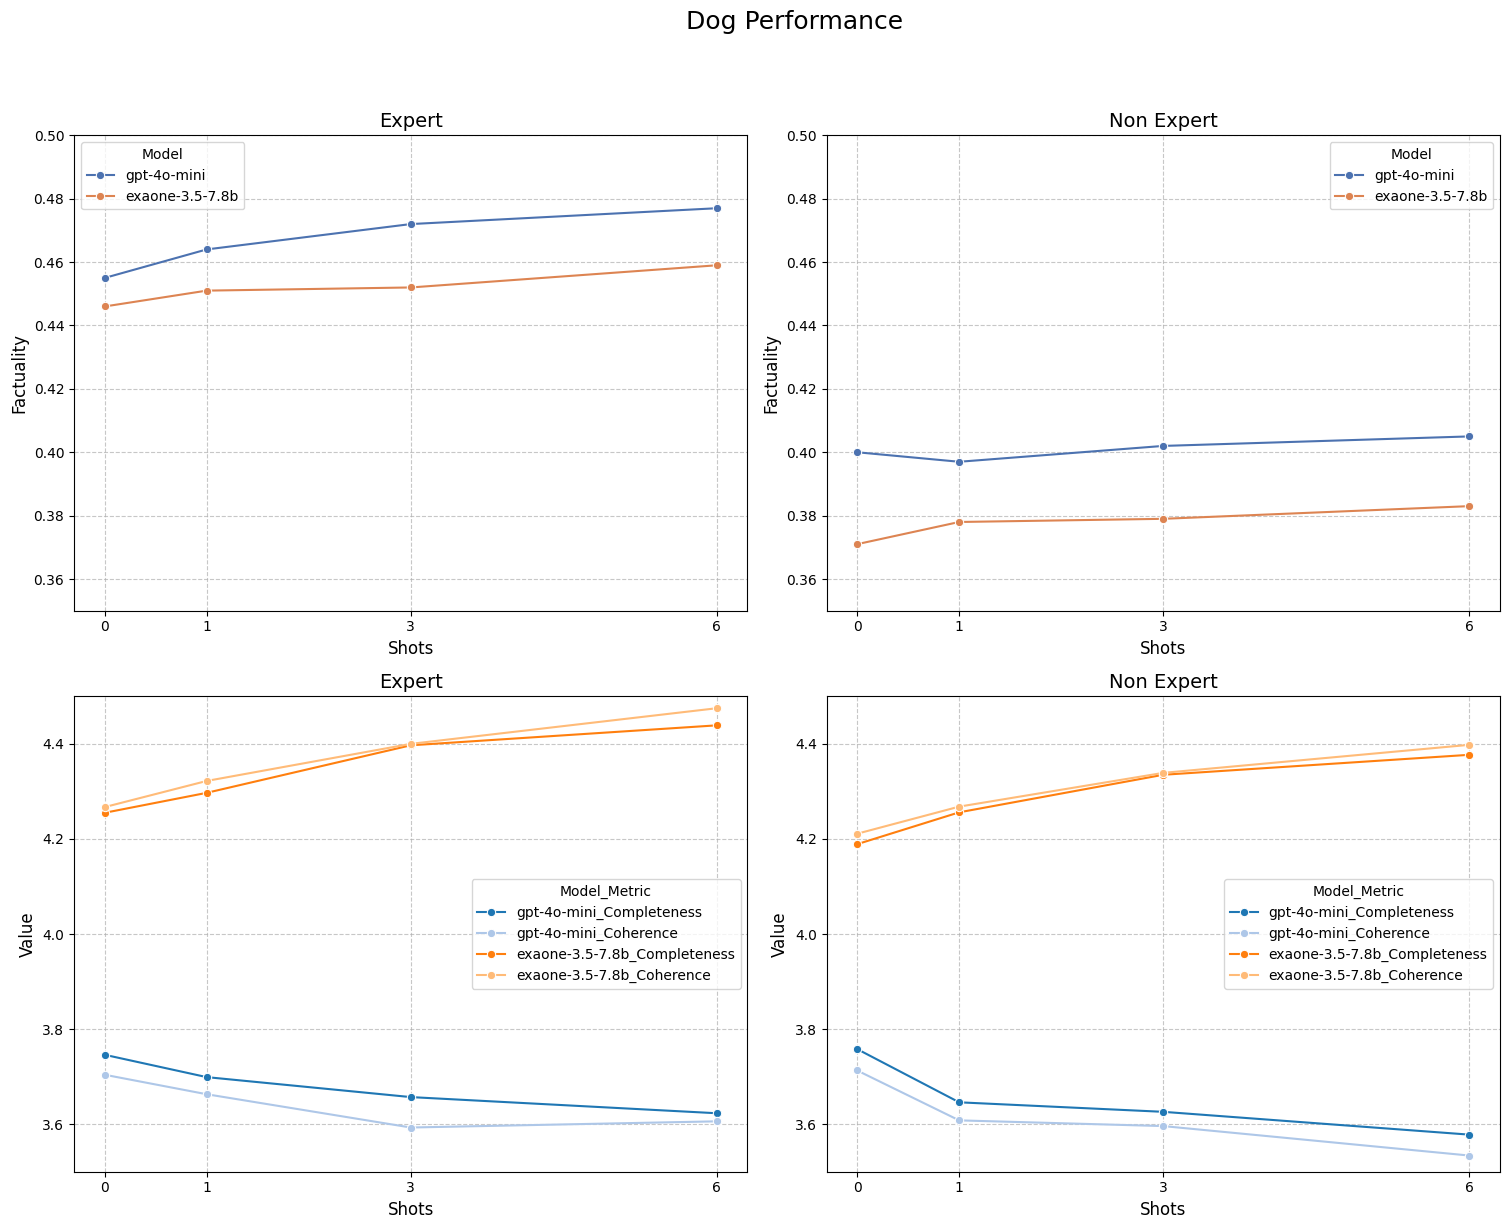

In [62]:
def plot_combined_llm_eval_metrics(data, animal_type='Dog'):
    """
    Visualizes LLM-based evaluation metrics (Factuality separately,
    Completeness/Coherence together) for Expert and Non-Expert groups.
    Consists of 2 rows and 2 columns of subplots.

    Args:
        data (dict): Dictionary containing LLM evaluation metric data.
        animal_type (str): Animal category to visualize ('Dog' or 'Cat'). Default is 'Dog'.
    """
    expertise_levels = ['Expert', 'Non Expert']
    
    # Create subplots: 2 rows (Factuality, Completeness/Coherence) x 2 columns (Expert, Non Expert)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    fig.suptitle(f'{animal_type} Performance', fontsize=18, y=1.02)

    # Process each expertise level
    for col_idx, expertise_level in enumerate(expertise_levels):

        # 1. Factuality Plot (First Row)
        factuality_plot_data = []
        for llm_type, llm_data in data.items(): # closed LLM, open LLM
            for model, model_data in llm_data[expertise_level].items():
                if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                    for shot, metric_values in model_data[animal_type]['preprocessed'].items():
                        if 'Factuality' in metric_values:
                            factuality_plot_data.append({
                                'Model': model,
                                'Shots': shot,
                                'Factuality': metric_values['Factuality']
                            })
        
        df_factuality = pd.DataFrame(factuality_plot_data)
        ax_factuality = axes[0, col_idx] # First row, current column
        
        sns.lineplot(data=df_factuality, x='Shots', y='Factuality', hue='Model', marker='o', ax=ax_factuality, palette='deep')
        ax_factuality.set_title(f'{expertise_level}', fontsize=14)
        ax_factuality.set_xlabel('Shots', fontsize=12)
        ax_factuality.set_ylabel('Factuality', fontsize=12)
        ax_factuality.grid(True, linestyle='--', alpha=0.7)
        ax_factuality.set_xticks([0, 1, 3, 6])
        ax_factuality.set_ylim(0.35, 0.5) # Appropriate range for Factuality

        # 2. Completeness and Coherence Plot (Second Row)
        comp_coh_plot_data = []
        for llm_type, llm_data in data.items():
            for model, model_data in llm_data[expertise_level].items():
                if animal_type in model_data and 'preprocessed' in model_data[animal_type]:
                    for shot, metric_values in model_data[animal_type]['preprocessed'].items():
                        if 'Completeness' in metric_values:
                            comp_coh_plot_data.append({
                                'Model': model,
                                'Shots': shot,
                                'Metric': 'Completeness',
                                'Value': metric_values['Completeness']
                            })
                        if 'Coherence' in metric_values:
                            comp_coh_plot_data.append({
                                'Model': model,
                                'Shots': shot,
                                'Metric': 'Coherence',
                                'Value': metric_values['Coherence']
                            })
        
        df_comp_coh = pd.DataFrame(comp_coh_plot_data)
        ax_comp_coh = axes[1, col_idx] # Second row, current column

        # Create 'Model_Metric' for distinct lines for each model and metric
        df_comp_coh['Model_Metric'] = df_comp_coh['Model'] + '_' + df_comp_coh['Metric']
        
        # Clear existing plot if any (from previous iterations/tests)
        ax_comp_coh.cla()
        
        # Plot with combined hue and distinct style for LLM Type
        sns.lineplot(data=df_comp_coh, x='Shots', y='Value', hue='Model_Metric', marker='o', ax=ax_comp_coh, palette='tab20')

        ax_comp_coh.set_title(f'{expertise_level}', fontsize=14)
        ax_comp_coh.set_xlabel('Shots', fontsize=12)
        ax_comp_coh.set_ylabel('Value', fontsize=12)
        ax_comp_coh.grid(True, linestyle='--', alpha=0.7)
        ax_comp_coh.set_xticks([0, 1, 3, 6])
        ax_comp_coh.set_ylim(3.5, 4.5) # Appropriate range for Completeness, Coherence

    plt.tight_layout(rect=[0, 0, 0.95, 0.98]) # Adjust rect for overall title spacing
    plt.show()

# Call the visualization function for 'Dog' category
plot_combined_llm_eval_metrics(llm_eval_results, animal_type='Dog')

In [79]:
training_results = {
    'exaone-3.5-7.8b': {
        'Expert': {
            'Dog': {
                'ALL': {'ROUGE': 0.229, 'BERTScore': 0.723},
                'E': {'ROUGE': 0.244, 'BERTScore': 0.731},
                'NE': {'ROUGE': 0.177, 'BERTScore': 0.707},
                'baseline': {'ROUGE': 0.228, 'BERTScore': 0.709}
            },
            'Cat': {
                'ALL': {'ROUGE': 0.231, 'BERTScore': 0.724},
                'E': {'ROUGE': 0.255, 'BERTScore': 0.735},
                'NE': {'ROUGE': 0.184, 'BERTScore': 0.710},
                'baseline': {'ROUGE': 0.232, 'BERTScore': 0.710}
            }
        },
        'Non Expert': {
            'Dog': {
                'ALL': {'ROUGE': 0.166, 'BERTScore': 0.703},
                'E': {'ROUGE': 0.145, 'BERTScore': 0.695},
                'NE': {'ROUGE': 0.161, 'BERTScore': 0.703},
                'baseline': {'ROUGE': 0.201, 'BERTScore': 0.697}
            },
            'Cat': {
                'ALL': {'ROUGE': 0.172, 'BERTScore': 0.703},
                'E': {'ROUGE': 0.144, 'BERTScore': 0.693},
                'NE': {'ROUGE': 0.163, 'BERTScore': 0.702},
                'baseline': {'ROUGE': 0.208, 'BERTScore': 0.699}
            }
        }
    },
    'gpt-4o-mini': {
        'Expert': {
            'Dog': {
                'baseline': {'ROUGE': 0.243, 'BERTScore': 0.717}
            },
            'Cat': {
                'baseline': {'ROUGE': 0.249, 'BERTScore': 0.719}
            }
        },
        'Non Expert': {
            'Dog': {
                'baseline': {'ROUGE': 0.226, 'BERTScore': 0.708}
            },
            'Cat': {
                'baseline': {'ROUGE': 0.231, 'BERTScore': 0.710}
            }
        }
    }
}

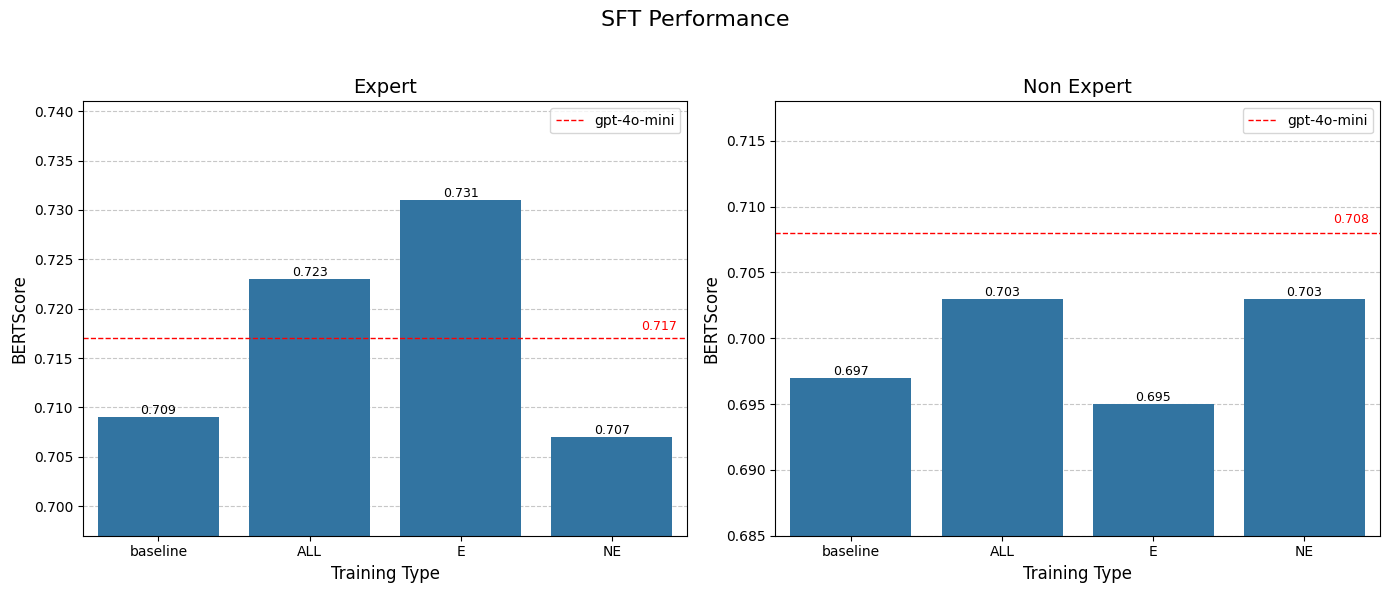

In [119]:
def plot_exaone_bertscore_comparison(data, animal_type='Dog'):
    expertise_levels = ['Expert', 'Non Expert']
    target_model_exaone = 'exaone-3.5-7.8b'
    target_model_gpt = 'gpt-4o-mini' # Model for the baseline line
    metric = 'BERTScore'
    training_types_to_compare = ['baseline', 'ALL', 'E', 'NE']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    fig.suptitle(f'SFT Performance', fontsize=16)

    for col_idx, expertise_level in enumerate(expertise_levels):
        plot_data = []
        
        # Access data for Exaone model
        if target_model_exaone in data and expertise_level in data[target_model_exaone] and \
           animal_type in data[target_model_exaone][expertise_level]:
            animal_data_exaone = data[target_model_exaone][expertise_level][animal_type]
            
            for train_type in training_types_to_compare:
                if train_type in animal_data_exaone and metric in animal_data_exaone[train_type]:
                    plot_data.append({
                        'Training Type': train_type,
                        metric: animal_data_exaone[train_type][metric]
                    })
        
        df_plot = pd.DataFrame(plot_data)
        ax = axes[col_idx]

        # Plot transparent bars
        sns.barplot(data=df_plot, x='Training Type', y=metric, ax=ax, alpha=1, zorder=2)
        
        # Add value labels on top of bars, they will still be visible
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', fontsize=9)

        # Get GPT-4o-mini baseline BERTScore for the current expertise level and animal type
        gpt_baseline_bertscore = None
        if target_model_gpt in data and expertise_level in data[target_model_gpt] and \
           animal_type in data[target_model_gpt][expertise_level] and \
           'baseline' in data[target_model_gpt][expertise_level][animal_type] and \
           metric in data[target_model_gpt][expertise_level][animal_type]['baseline']:
            
            gpt_baseline_bertscore = data[target_model_gpt][expertise_level][animal_type]['baseline'][metric]
            
            # Plot horizontal line for GPT-4o-mini baseline
            ax.axhline(y=gpt_baseline_bertscore, color='red', linestyle='--', linewidth=1, label=f'{target_model_gpt}')
            ax.text(ax.get_xlim()[1] * 0.98, gpt_baseline_bertscore + 0.0005, f'{gpt_baseline_bertscore:.3f}', 
                    color='red', ha='right', va='bottom', fontsize=9, zorder=4) # Increased zorder for text


        ax.set_title(f'{expertise_level}', fontsize=14)
        ax.set_xlabel('Training Type', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust y-axis limits to accommodate GPT-4o-mini baseline and Exaone values
        # Determine the min/max value for setting y-limits
        all_scores = df_plot[metric].tolist()
        if gpt_baseline_bertscore is not None:
            all_scores.append(gpt_baseline_bertscore)
        
        if all_scores:
            min_score = min(all_scores) - 0.01 # A bit of padding below the lowest value
            max_score = max(all_scores) + 0.01 # A bit of padding above the highest value
            ax.set_ylim(min_score, max_score)
        else:
            # Fallback if no data is found (shouldn't happen with provided data)
            if expertise_level == 'Expert':
                ax.set_ylim(0.65, 0.75)
            else: # Non Expert
                ax.set_ylim(0.65, 0.72)

        # Add legend for the horizontal line
        ax.legend(loc='best', fontsize=10) # Simplified legend title

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function for Dog category
plot_exaone_bertscore_comparison(training_results, animal_type='Dog')

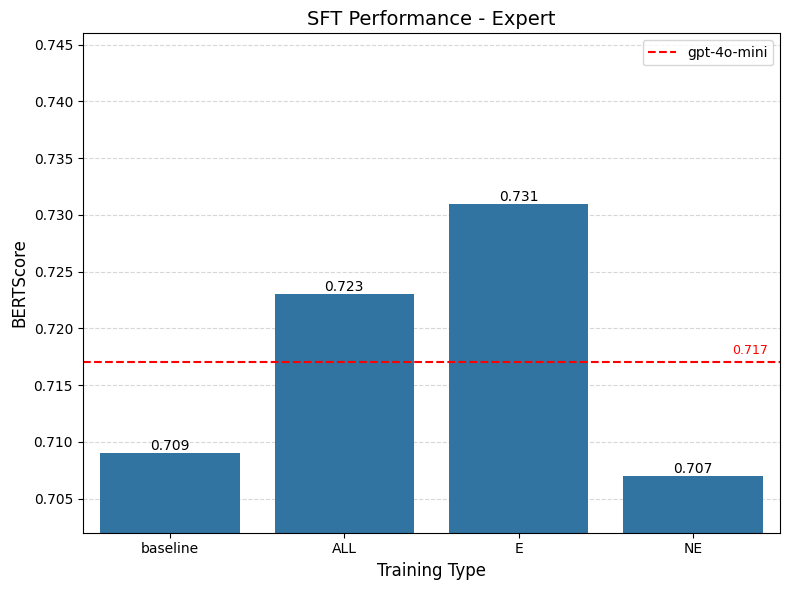

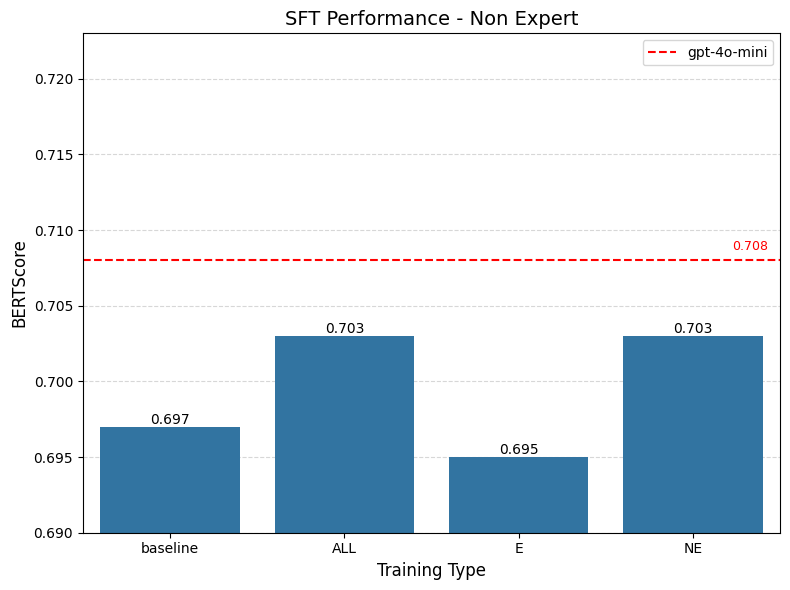

In [123]:
def plot_exaone_bertscore_comparison_individual(data, animal_type='Dog'):
    expertise_levels = ['Expert', 'Non Expert']
    target_model_exaone = 'exaone-3.5-7.8b'
    target_model_gpt = 'gpt-4o-mini' # Model for the baseline line
    metric = 'BERTScore'
    training_types_to_compare = ['baseline', 'ALL', 'E', 'NE']

    for expertise_level in expertise_levels:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # Create a new figure and axes for each plot

        plot_data = []
        
        # Access data for Exaone model
        if target_model_exaone in data and expertise_level in data[target_model_exaone] and \
           animal_type in data[target_model_exaone][expertise_level]:
            animal_data_exaone = data[target_model_exaone][expertise_level][animal_type]
            
            for train_type in training_types_to_compare:
                if train_type in animal_data_exaone and metric in animal_data_exaone[train_type]:
                    plot_data.append({
                        'Training Type': train_type,
                        metric: animal_data_exaone[train_type][metric]
                    })
        
        df_plot = pd.DataFrame(plot_data)

        # Plot bars with alpha=1 and higher zorder
        sns.barplot(data=df_plot, x='Training Type', y=metric, ax=ax, alpha=1, zorder=2)
        
        # Add value labels on top of bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', fontsize=10)

        # Get GPT-4o-mini baseline BERTScore for the current expertise level and animal type
        gpt_baseline_bertscore = None
        if target_model_gpt in data and expertise_level in data[target_model_gpt] and \
           animal_type in data[target_model_gpt][expertise_level] and \
           'baseline' in data[target_model_gpt][expertise_level][animal_type] and \
           metric in data[target_model_gpt][expertise_level][animal_type]['baseline']:
            
            gpt_baseline_bertscore = data[target_model_gpt][expertise_level][animal_type]['baseline'][metric]
            
            # Plot horizontal line for GPT-4o-mini baseline
            ax.axhline(y=gpt_baseline_bertscore, color='red', linestyle='--', linewidth=1.5, label='gpt-4o-mini', zorder=2)
            
            # Add actual value next to the red line
            ax.text(ax.get_xlim()[1] * 0.98, gpt_baseline_bertscore + 0.0005, f'{gpt_baseline_bertscore:.3f}', 
                    color='red', ha='right', va='bottom', fontsize=9, zorder=4)

        ax.set_title(f'SFT Performance - {expertise_level}', fontsize=14) # Changed title to include expertise level
        ax.set_xlabel('Training Type', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

        # Adjust y-axis limits dynamically
        all_scores = df_plot[metric].tolist()
        if gpt_baseline_bertscore is not None:
            all_scores.append(gpt_baseline_bertscore)
        
        if all_scores:
            min_score = min(all_scores) - 0.005
            max_score = max(all_scores) + 0.015
            ax.set_ylim(min_score, max_score)
        else:
            # Fallback if no data is found (shouldn't happen with provided data)
            if expertise_level == 'Expert':
                ax.set_ylim(0.70, 0.73)
            else: # Non Expert
                ax.set_ylim(0.685, 0.718)

        ax.legend(loc='upper right', fontsize=10)
        
        plt.tight_layout() # Adjust layout for current single plot
        plt.show() # Display each plot individually

# Call the function for Dog category
plot_exaone_bertscore_comparison_individual(training_results, animal_type='Dog')

In [34]:
def create_dataframe(raw_data):
    data_list = []
    for answer_type, models_data in raw_data.items():
        for model, animal_types in models_data.items():
            for animal, input_types_data in animal_types.items():
                for input_type, icl_data in input_types_data.items():
                    for icl_shot, scores in icl_data.items():
                        row = {
                            'Answer Type': answer_type,
                            'Model': model,
                            'Animal': animal,
                            'Input Type': input_type,
                            'ICL': icl_shot,
                            'ROUGE': scores['ROUGE'],
                            'BERTScore': scores['BERTScore']
                        }
                        data_list.append(row)
    df = pd.DataFrame(data_list)
    df['Category'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()
    return df

In [28]:
# 개선 fewshot examples 선정 (카테고리별)
data_raw_new = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.243, 'BERTScore': 0.717},
                    1: {'ROUGE': 0.250, 'BERTScore': 0.722},
                    3: {'ROUGE': 0.256, 'BERTScore': 0.725},
                    6: {'ROUGE': 0.260, 'BERTScore': 0.726}
                },
                'raw': {
                    0: {'ROUGE': 0.243, 'BERTScore': 0.715},
                    1: {'ROUGE': 0.250, 'BERTScore': 0.721},
                    3: {'ROUGE': 0.255, 'BERTScore': 0.724},
                    6: {'ROUGE': 0.258, 'BERTScore': 0.725}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.249, 'BERTScore': 0.719},
                    1: {'ROUGE': 0.258, 'BERTScore': 0.725},
                    3: {'ROUGE': 0.265, 'BERTScore': 0.728},
                    6: {'ROUGE': 0.267, 'BERTScore': 0.729}
                },
                'raw': {
                    0: {'ROUGE': 0.250, 'BERTScore': 0.719},
                    1: {'ROUGE': 0.257, 'BERTScore': 0.725},
                    3: {'ROUGE': 0.266, 'BERTScore': 0.729},
                    6: {'ROUGE': 0.266, 'BERTScore': 0.730}
                }
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.228, 'BERTScore': 0.709},
                    1: {'ROUGE': 0.226, 'BERTScore': 0.704},
                    3: {'ROUGE': 0.225, 'BERTScore': 0.698},
                    6: {'ROUGE': 0.223, 'BERTScore': 0.695}
                },
                'raw': {
                    0: {'ROUGE': 0.224, 'BERTScore': 0.703},
                    1: {'ROUGE': 0.224, 'BERTScore': 0.699},
                    3: {'ROUGE': 0.222, 'BERTScore': 0.695},
                    6: {'ROUGE': 0.222, 'BERTScore': 0.692}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.232, 'BERTScore': 0.710},
                    1: {'ROUGE': 0.231, 'BERTScore': 0.707},
                    3: {'ROUGE': 0.231, 'BERTScore': 0.700},
                    6: {'ROUGE': 0.227, 'BERTScore': 0.696}
                },
                'raw': {
                    0: {'ROUGE': 0.231, 'BERTScore': 0.705},
                    1: {'ROUGE': 0.228, 'BERTScore': 0.702},
                    3: {'ROUGE': 0.226, 'BERTScore': 0.697},
                    6: {'ROUGE': 0.226, 'BERTScore': 0.695}
                }
            }
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.226, 'BERTScore': 0.708},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.712},
                    3: {'ROUGE': 0.233, 'BERTScore': 0.714},
                    6: {'ROUGE': 0.234, 'BERTScore': 0.715}
                },
                'raw': {
                    0: {'ROUGE': 0.225, 'BERTScore': 0.708},
                    1: {'ROUGE': 0.229, 'BERTScore': 0.712},
                    3: {'ROUGE': 0.232, 'BERTScore': 0.714},
                    6: {'ROUGE': 0.233, 'BERTScore': 0.715}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.231, 'BERTScore': 0.710},
                    1: {'ROUGE': 0.235, 'BERTScore': 0.713},
                    3: {'ROUGE': 0.238, 'BERTScore': 0.715},
                    6: {'ROUGE': 0.238, 'BERTScore': 0.715}
                },
                'raw': {
                    0: {'ROUGE': 0.232, 'BERTScore': 0.711},
                    1: {'ROUGE': 0.235, 'BERTScore': 0.713},
                    3: {'ROUGE': 0.236, 'BERTScore': 0.715},
                    6: {'ROUGE': 0.238, 'BERTScore': 0.716}
                }
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {
                'preprocessed': {
                    0: {'ROUGE': 0.201, 'BERTScore': 0.697},
                    1: {'ROUGE': 0.199, 'BERTScore': 0.692},
                    3: {'ROUGE': 0.196, 'BERTScore': 0.687},
                    6: {'ROUGE': 0.192, 'BERTScore': 0.683}
                },
                'raw': {
                    0: {'ROUGE': 0.199, 'BERTScore': 0.693},
                    1: {'ROUGE': 0.196, 'BERTScore': 0.688},
                    3: {'ROUGE': 0.193, 'BERTScore': 0.684},
                    6: {'ROUGE': 0.191, 'BERTScore': 0.680}
                }
            },
            'Cat': {
                'preprocessed': {
                    0: {'ROUGE': 0.208, 'BERTScore': 0.699},
                    1: {'ROUGE': 0.205, 'BERTScore': 0.693},
                    3: {'ROUGE': 0.201, 'BERTScore': 0.687},
                    6: {'ROUGE': 0.197, 'BERTScore': 0.683}
                },
                'raw': {
                    0: {'ROUGE': 0.204, 'BERTScore': 0.693},
                    1: {'ROUGE': 0.201, 'BERTScore': 0.689},
                    3: {'ROUGE': 0.198, 'BERTScore': 0.684},
                    6: {'ROUGE': 0.194, 'BERTScore': 0.680}
                }
            }
        }
    }
}

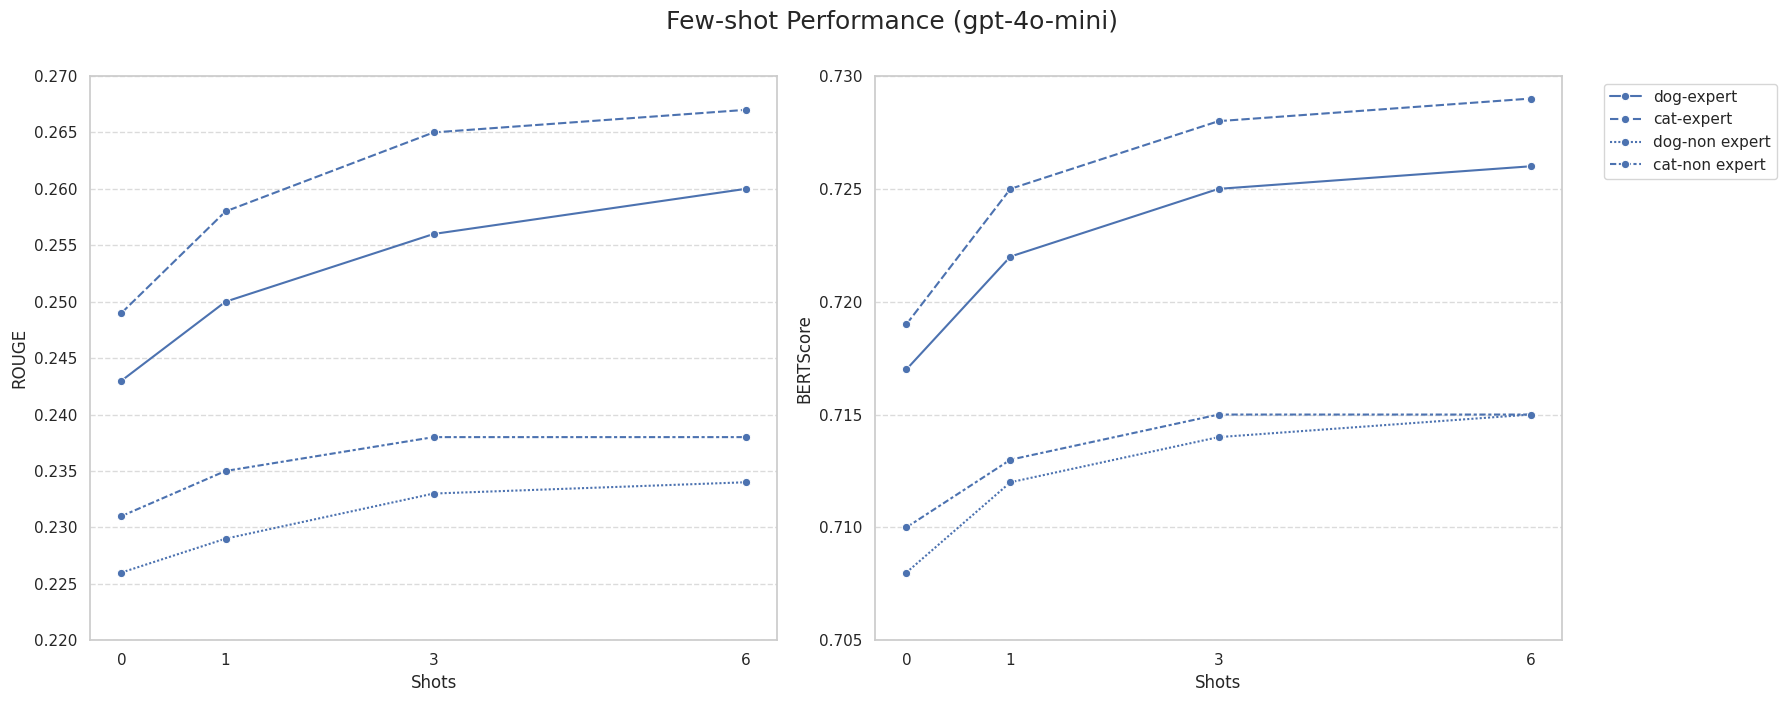

In [46]:

data_list = []
for answer_type, models_data in data_raw_new.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, icl_data in input_types_data.items():
                for icl_shot, scores in icl_data.items():
                    row = {
                        'Answer Type': answer_type,
                        'Model': model,
                        'Animal': animal,
                        'Input Type': input_type,
                        'ICL': icl_shot,
                        'ROUGE': scores['ROUGE'],
                        'BERTScore': scores['BERTScore']
                    }
                    data_list.append(row)

df = pd.DataFrame(data_list)
df = df[df['Input Type'] == 'preprocessed']
df['Category'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

MODEL_NAME = 'gpt-4o-mini'

df_model = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 가독성을 위해 figsize를 늘렸습니다.
fig.suptitle(f'Few-shot Performance ({MODEL_NAME})', fontsize=18, y=1)

# ROUGE 성능 변화 그래프
sns.lineplot(
    ax=axes[0],
    data=df_model,
    x='ICL',
    y='ROUGE',
    # hue='Category',
    style='Category', # 각 카테고리별로 다른 선 스타일 적용
    marker='o' # 데이터 포인트를 마커로 표시
)
axes[0].set_xlabel('Shots')
axes[0].set_ylabel('ROUGE')
axes[0].set_xticks(sorted(df_model['ICL'].unique())) # 모든 ICL 샷이 x축에 표시되도록 설정
axes[0].set_ylim(0.22, 0.27) # 데이터 범위에 맞춰 y축 범위 조정
axes[0].set_yticks(np.arange(0.22, 0.271, 0.005))
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# BERTScore 성능 변화 그래프
sns.lineplot(
    ax=axes[1],
    data=df_model,
    x='ICL',
    y='BERTScore',
    # hue='Category',
    style='Category',
    marker='o',
)
axes[1].set_xlabel('Shots')
axes[1].set_ylabel('BERTScore')
axes[1].set_xticks(sorted(df_model['ICL'].unique()))
axes[1].set_ylim(0.705, 0.73) # 데이터 범위에 맞춰 y축 범위 조정
axes[1].set_yticks(np.arange(0.705, 0.731, 0.005))
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].grid(False)
axes[1].grid(False)
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # 가로선만 표시
    ax.grid(axis='x', visible=False) 
axes[0].legend_.remove()

plt.tight_layout()
plt.show()

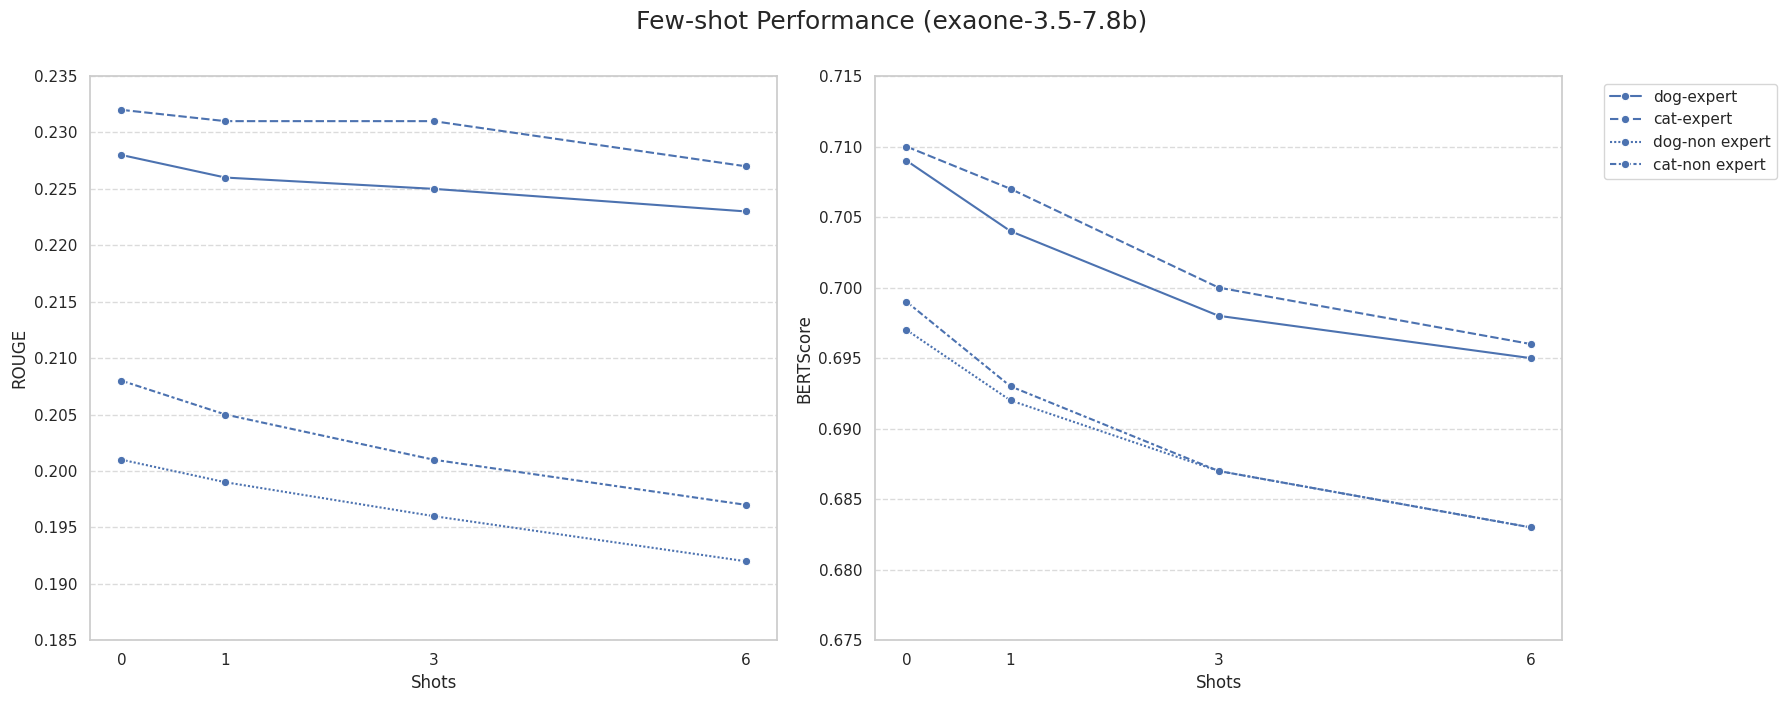

In [47]:

data_list = []
for answer_type, models_data in data_raw_new.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, icl_data in input_types_data.items():
                for icl_shot, scores in icl_data.items():
                    row = {
                        'Answer Type': answer_type,
                        'Model': model,
                        'Animal': animal,
                        'Input Type': input_type,
                        'ICL': icl_shot,
                        'ROUGE': scores['ROUGE'],
                        'BERTScore': scores['BERTScore']
                    }
                    data_list.append(row)

df = pd.DataFrame(data_list)
df = df[df['Input Type'] == 'preprocessed']
df['Category'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

MODEL_NAME = 'exaone-3.5-7.8b'

df_model = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 가독성을 위해 figsize를 늘렸습니다.
fig.suptitle(f'Few-shot Performance ({MODEL_NAME})', fontsize=18, y=1)

# ROUGE 성능 변화 그래프
sns.lineplot(
    ax=axes[0],
    data=df_model,
    x='ICL',
    y='ROUGE',
    # hue='Category',
    style='Category', # 각 카테고리별로 다른 선 스타일 적용
    marker='o' # 데이터 포인트를 마커로 표시
)
axes[0].set_xlabel('Shots')
axes[0].set_ylabel('ROUGE')
axes[0].set_xticks(sorted(df_model['ICL'].unique())) # 모든 ICL 샷이 x축에 표시되도록 설정
axes[0].set_ylim(0.185, 0.235) # 데이터 범위에 맞춰 y축 범위 조정
axes[0].set_yticks(np.arange(0.185, 0.236, 0.005))
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# BERTScore 성능 변화 그래프
sns.lineplot(
    ax=axes[1],
    data=df_model,
    x='ICL',
    y='BERTScore',
    # hue='Category',
    style='Category',
    marker='o',
)
axes[1].set_xlabel('Shots')
axes[1].set_ylabel('BERTScore')
axes[1].set_xticks(sorted(df_model['ICL'].unique()))
axes[1].set_ylim(0.675, 0.715) # 데이터 범위에 맞춰 y축 범위 조정
axes[1].set_yticks(np.arange(0.675, 0.716, 0.005))
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].grid(False)
axes[1].grid(False)
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # 가로선만 표시
    ax.grid(axis='x', visible=False) 
axes[0].legend_.remove()

plt.tight_layout()
plt.show()

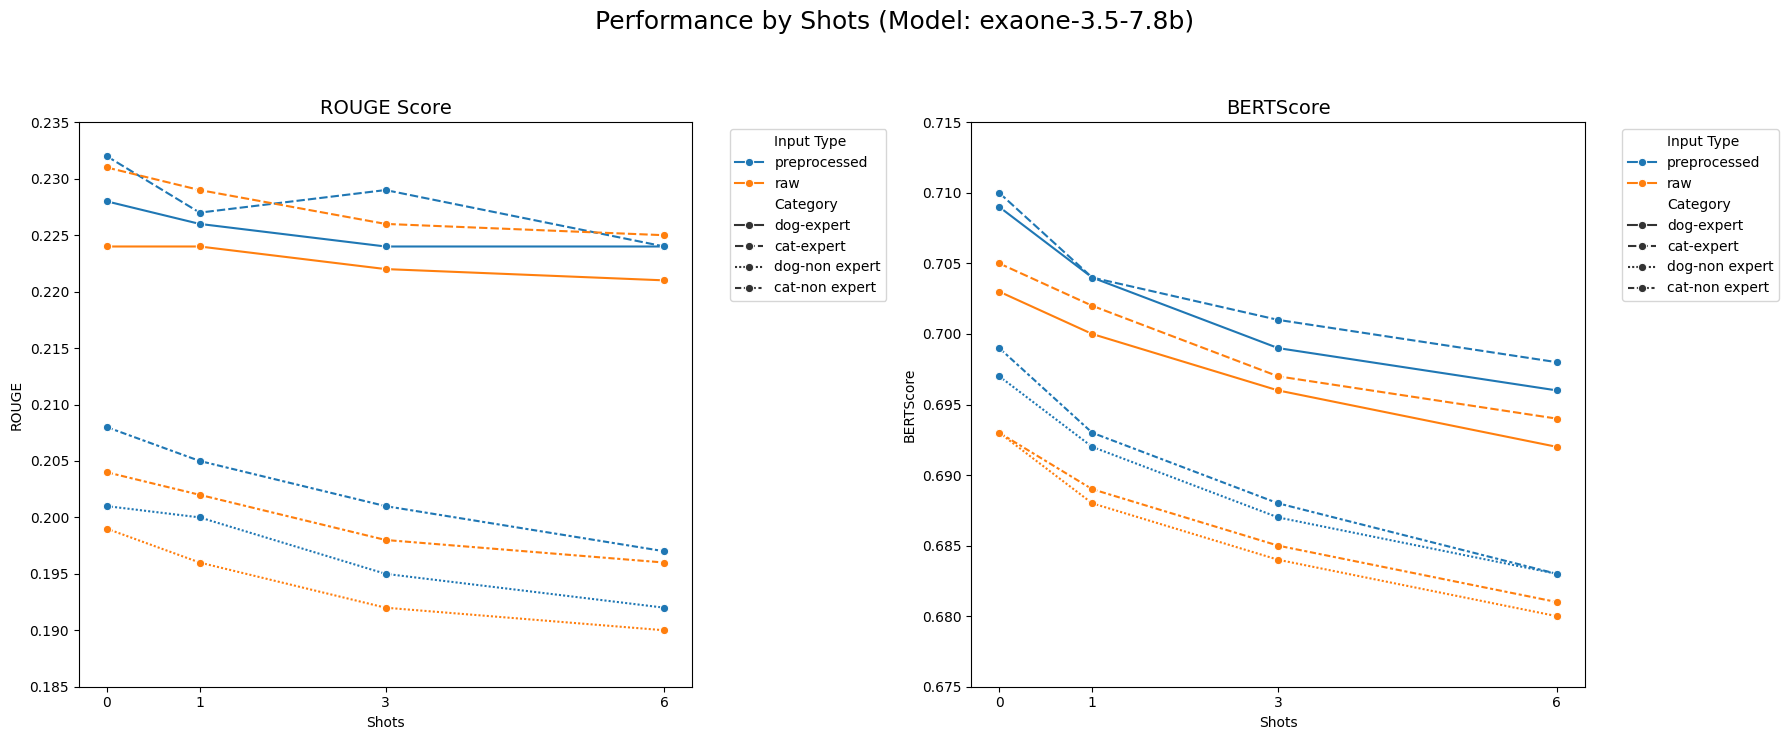

In [60]:
data_list = []
for answer_type, models_data in data_raw_original.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, icl_data in input_types_data.items():
                for icl_shot, scores in icl_data.items():
                    row = {
                        'Answer Type': answer_type,
                        'Model': model,
                        'Animal': animal,
                        'Input Type': input_type,
                        'ICL': icl_shot,
                        'ROUGE': scores['ROUGE'],
                        'BERTScore': scores['BERTScore']
                    }
                    data_list.append(row)

df = pd.DataFrame(data_list)
df['Category'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

MODEL_NAME = 'exaone-3.5-7.8b'

df_model = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 가독성을 위해 figsize를 늘렸습니다.
fig.suptitle(f'Performance by Shots (Model: {MODEL_NAME})', fontsize=18, y=1.05)

# ROUGE 성능 변화 그래프
sns.lineplot(
    ax=axes[0],
    data=df_model,
    x='ICL',
    y='ROUGE',
    hue='Input Type',
    style='Category', # 각 카테고리별로 다른 선 스타일 적용
    marker='o' # 데이터 포인트를 마커로 표시
)
axes[0].set_title('ROUGE Score', fontsize=14)
axes[0].set_xlabel('Shots')
axes[0].set_ylabel('ROUGE')
axes[0].set_xticks(sorted(df_model['ICL'].unique())) # 모든 ICL 샷이 x축에 표시되도록 설정
axes[0].set_ylim(0.185, 0.235) # 데이터 범위에 맞춰 y축 범위 조정
axes[0].set_yticks(np.arange(0.185, 0.236, 0.005))
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# BERTScore 성능 변화 그래프
sns.lineplot(
    ax=axes[1],
    data=df_model,
    x='ICL',
    y='BERTScore',
    hue='Input Type',
    style='Category',
    marker='o'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Shots')
axes[1].set_ylabel('BERTScore')
axes[1].set_xticks(sorted(df_model['ICL'].unique()))
axes[1].set_ylim(0.675, 0.715) # 데이터 범위에 맞춰 y축 범위 조정
axes[1].set_yticks(np.arange(0.675, 0.716, 0.005))
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

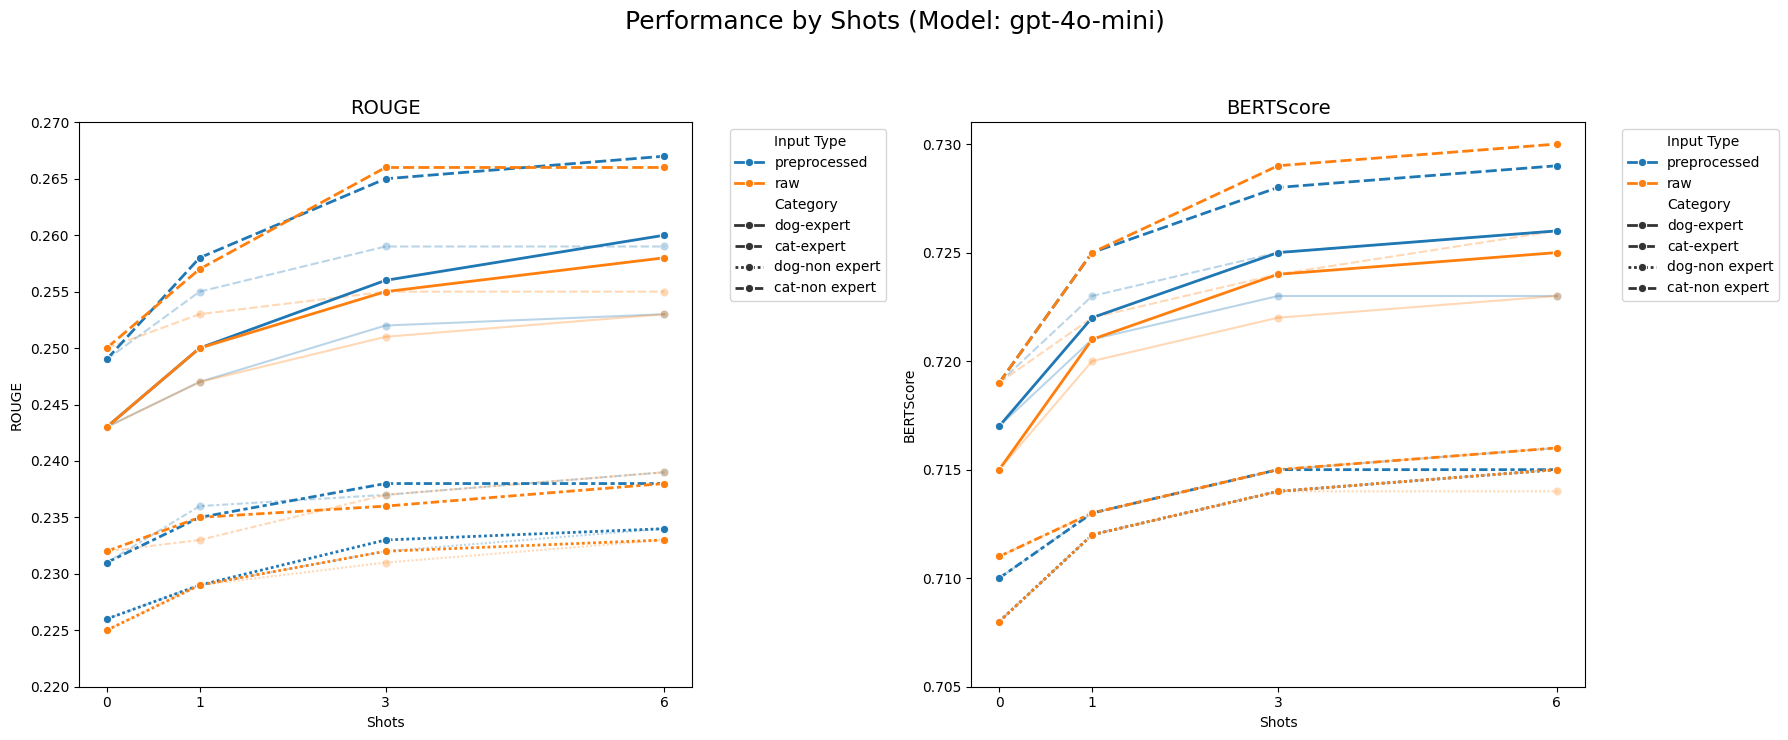

In [54]:
df_original = create_dataframe(data_raw_original)
df_improved = create_dataframe(data_raw_new)

MODEL_NAME = 'gpt-4o-mini'

df_model_original = df_original[df_original['Model'] == MODEL_NAME].copy()
df_model_improved = df_improved[df_improved['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'Performance by Shots (Model: {MODEL_NAME})', fontsize=18, y=1.05)

# ROUGE 성능 변화 그래프 (기존 데이터 희미하게, 새로운 데이터 진하게)
# 기존 데이터 (희미하게)
sns.lineplot(
    ax=axes[0],
    data=df_model_original,
    x='ICL',
    y='ROUGE',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=0.3, # 희미하게 표시
    legend=False # 기존 데이터의 범례는 표시하지 않음
)
# 새로운 데이터 (진하게)
sns.lineplot(
    ax=axes[0],
    data=df_model_improved,
    x='ICL',
    y='ROUGE',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=1.0, # 진하게 표시
    linewidth=2 # 선 두께를 좀 더 강조
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Shots')
axes[0].set_ylabel('ROUGE')
axes[0].set_xticks(sorted(df_model_original['ICL'].unique()))
axes[0].set_ylim(0.22, 0.270)
axes[0].set_yticks(np.arange(0.22, 0.271, 0.005))
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 새로운 데이터에 대한 범례만 표시

# BERTScore 성능 변화 그래프 (기존 데이터 희미하게, 새로운 데이터 진하게)
# 기존 데이터 (희미하게)
sns.lineplot(
    ax=axes[1],
    data=df_model_original,
    x='ICL',
    y='BERTScore',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=0.3, # 희미하게 표시
    legend=False # 기존 데이터의 범례는 표시하지 않음
)
# 새로운 데이터 (진하게)
sns.lineplot(
    ax=axes[1],
    data=df_model_improved,
    x='ICL',
    y='BERTScore',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=1.0, # 진하게 표시
    linewidth=2 # 선 두께를 좀 더 강조
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Shots')
axes[1].set_ylabel('BERTScore')
axes[1].set_xticks(sorted(df_model_original['ICL'].unique()))
axes[1].set_ylim(0.705, 0.731)
axes[1].set_yticks(np.arange(0.705, 0.732, 0.005))
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 새로운 데이터에 대한 범례만 표시

plt.tight_layout()
plt.show()

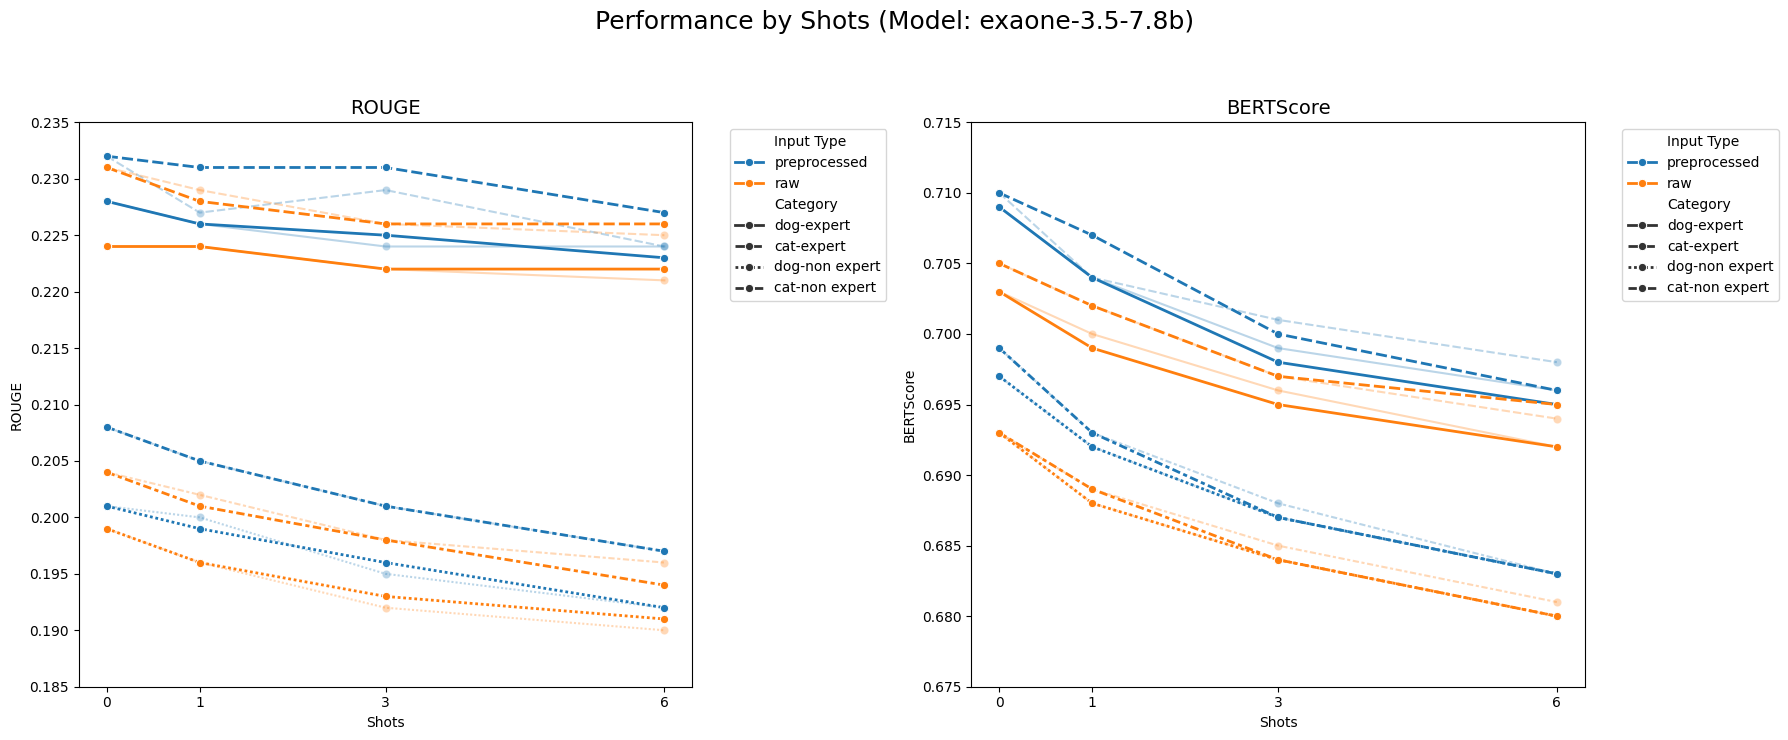

In [58]:
df_original = create_dataframe(data_raw_original)
df_improved = create_dataframe(data_raw_new)

MODEL_NAME = 'exaone-3.5-7.8b'

df_model_original = df_original[df_original['Model'] == MODEL_NAME].copy()
df_model_improved = df_improved[df_improved['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'Performance by Shots (Model: {MODEL_NAME})', fontsize=18, y=1.05)

# ROUGE 성능 변화 그래프 (기존 데이터 희미하게, 새로운 데이터 진하게)
# 기존 데이터 (희미하게)
sns.lineplot(
    ax=axes[0],
    data=df_model_original,
    x='ICL',
    y='ROUGE',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=0.3, # 희미하게 표시
    legend=False # 기존 데이터의 범례는 표시하지 않음
)
# 새로운 데이터 (진하게)
sns.lineplot(
    ax=axes[0],
    data=df_model_improved,
    x='ICL',
    y='ROUGE',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=1.0, # 진하게 표시
    linewidth=2 # 선 두께를 좀 더 강조
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Shots')
axes[0].set_ylabel('ROUGE')
axes[0].set_xticks(sorted(df_model_original['ICL'].unique()))
axes[0].set_ylim(0.185, 0.235)
axes[0].set_yticks(np.arange(0.185, 0.236, 0.005))
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 새로운 데이터에 대한 범례만 표시

# BERTScore 성능 변화 그래프 (기존 데이터 희미하게, 새로운 데이터 진하게)
# 기존 데이터 (희미하게)
sns.lineplot(
    ax=axes[1],
    data=df_model_original,
    x='ICL',
    y='BERTScore',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=0.3, # 희미하게 표시
    legend=False # 기존 데이터의 범례는 표시하지 않음
)
# 새로운 데이터 (진하게)
sns.lineplot(
    ax=axes[1],
    data=df_model_improved,
    x='ICL',
    y='BERTScore',
    hue='Input Type',
    style='Category',
    marker='o',
    alpha=1.0, # 진하게 표시
    linewidth=2 # 선 두께를 좀 더 강조
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Shots')
axes[1].set_ylabel('BERTScore')
axes[1].set_xticks(sorted(df_model_original['ICL'].unique()))
axes[1].set_ylim(0.675, 0.715)
axes[1].set_yticks(np.arange(0.675, 0.716, 0.005))
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 새로운 데이터에 대한 범례만 표시

plt.tight_layout()
plt.show()

In [2]:
data_sft_raw = {
    'ALL': {
        'Expert': {
            'Dog': {'preprocessed': {'ROUGE': 0.229, 'BERTScore': 0.723}, 'raw': {'ROUGE': 0.239, 'BERTScore': 0.728}},
            'Cat': {'preprocessed': {'ROUGE': 0.231, 'BERTScore': 0.724}, 'raw': {'ROUGE': 0.237, 'BERTScore': 0.728}}
        },
        'Non Expert': {
            'Dog': {'preprocessed': {'ROUGE': 0.166, 'BERTScore': 0.703}, 'raw': {'ROUGE': 0.167, 'BERTScore': 0.705}},
            'Cat': {'preprocessed': {'ROUGE': 0.172, 'BERTScore': 0.703}, 'raw': {'ROUGE': 0.171, 'BERTScore': 0.704}}
        }
    },
    'E': {
        'Expert': {
            'Dog': {'preprocessed': {'ROUGE': 0.244, 'BERTScore': 0.731}, 'raw': {'ROUGE': 0.244, 'BERTScore': 0.730}},
            'Cat': {'preprocessed': {'ROUGE': 0.255, 'BERTScore': 0.735}, 'raw': {'ROUGE': 0.258, 'BERTScore': 0.736}}
        },
        'Non Expert': {
            'Dog': {'preprocessed': {'ROUGE': 0.145, 'BERTScore': 0.695}, 'raw': {'ROUGE': 0.147, 'BERTScore': 0.695}},
            'Cat': {'preprocessed': {'ROUGE': 0.144, 'BERTScore': 0.693}, 'raw': {'ROUGE': 0.146, 'BERTScore': 0.692}}
        }
    },
    'NE': {
        'Expert': {
            'Dog': {'preprocessed': {'ROUGE': 0.177, 'BERTScore': 0.707}, 'raw': {'ROUGE': 0.181, 'BERTScore': 0.709}},
            'Cat': {'preprocessed': {'ROUGE': 0.184, 'BERTScore': 0.710}, 'raw': {'ROUGE': 0.182, 'BERTScore': 0.709}}
        },
        'Non Expert': {
            'Dog': {'preprocessed': {'ROUGE': 0.161, 'BERTScore': 0.703}, 'raw': {'ROUGE': 0.166, 'BERTScore': 0.706}},
            'Cat': {'preprocessed': {'ROUGE': 0.163, 'BERTScore': 0.702}, 'raw': {'ROUGE': 0.166, 'BERTScore': 0.703}}
        }
    }
}

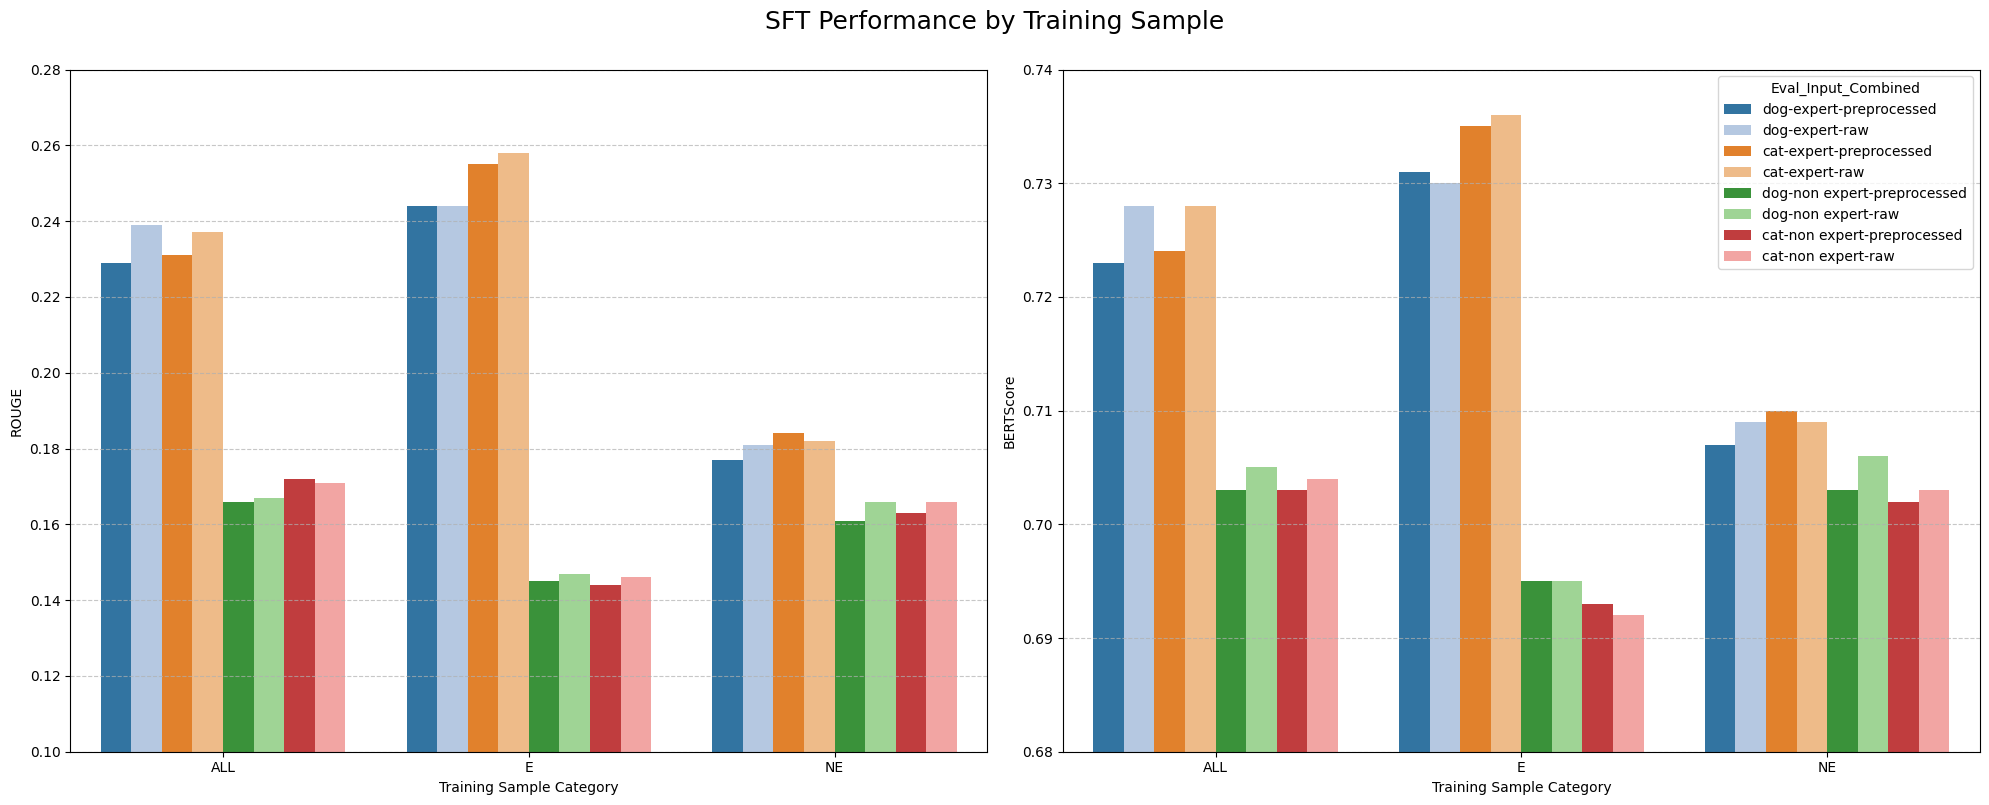

In [12]:
data_list = []
for train_category, answer_types_data in data_sft_raw.items():
    for answer_type, animal_types in answer_types_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Training Category': train_category,
                    'Answer Type': answer_type,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)

df_sft = pd.DataFrame(data_list)
df_sft['Evaluation Category'] = df_sft['Animal'].str.lower() + '-' + df_sft['Answer Type'].str.lower()

df_sft['Eval_Input_Combined'] = df_sft['Evaluation Category'] + '-' + df_sft['Input Type']

fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # figsize를 늘려 가독성을 높였습니다.
fig.suptitle('SFT Performance by Training Sample', fontsize=18, y=1)

# ROUGE Plot
sns.barplot(
    ax=axes[0],
    data=df_sft,
    x='Training Category',
    y='ROUGE',
    hue='Eval_Input_Combined', # 결합된 카테고리 + 입력 타입으로 hue 설정
    palette='tab20' # 더 많은 색상을 위해 palette 변경
)
axes[0].set_xlabel('Training Sample Category')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.1, 0.28)
axes[0].set_yticks(np.arange(0.1, 0.281, 0.02))
axes[0].tick_params(axis='x', rotation=0)
# axes[0].legend(title='Evaluation Category (Input Type)', bbox_to_anchor=(1.05, 1), loc='upper left')

# BERTScore Plot
sns.barplot(
    ax=axes[1],
    data=df_sft,
    x='Training Category',
    y='BERTScore',
    hue='Eval_Input_Combined', # 결합된 카테고리 + 입력 타입으로 hue 설정
    palette='tab20' # 더 많은 색상을 위해 palette 변경
)
axes[1].set_xlabel('Training Sample Category')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.68, 0.74)
axes[1].set_yticks(np.arange(0.68, 0.741, 0.01))
axes[1].tick_params(axis='x', rotation=0)
# axes[1].legend(title='Evaluation Category (Input Type)', bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # 가로선만 표시
    ax.grid(axis='x', visible=False) 
axes[0].legend_.remove()

plt.tight_layout()
plt.show()

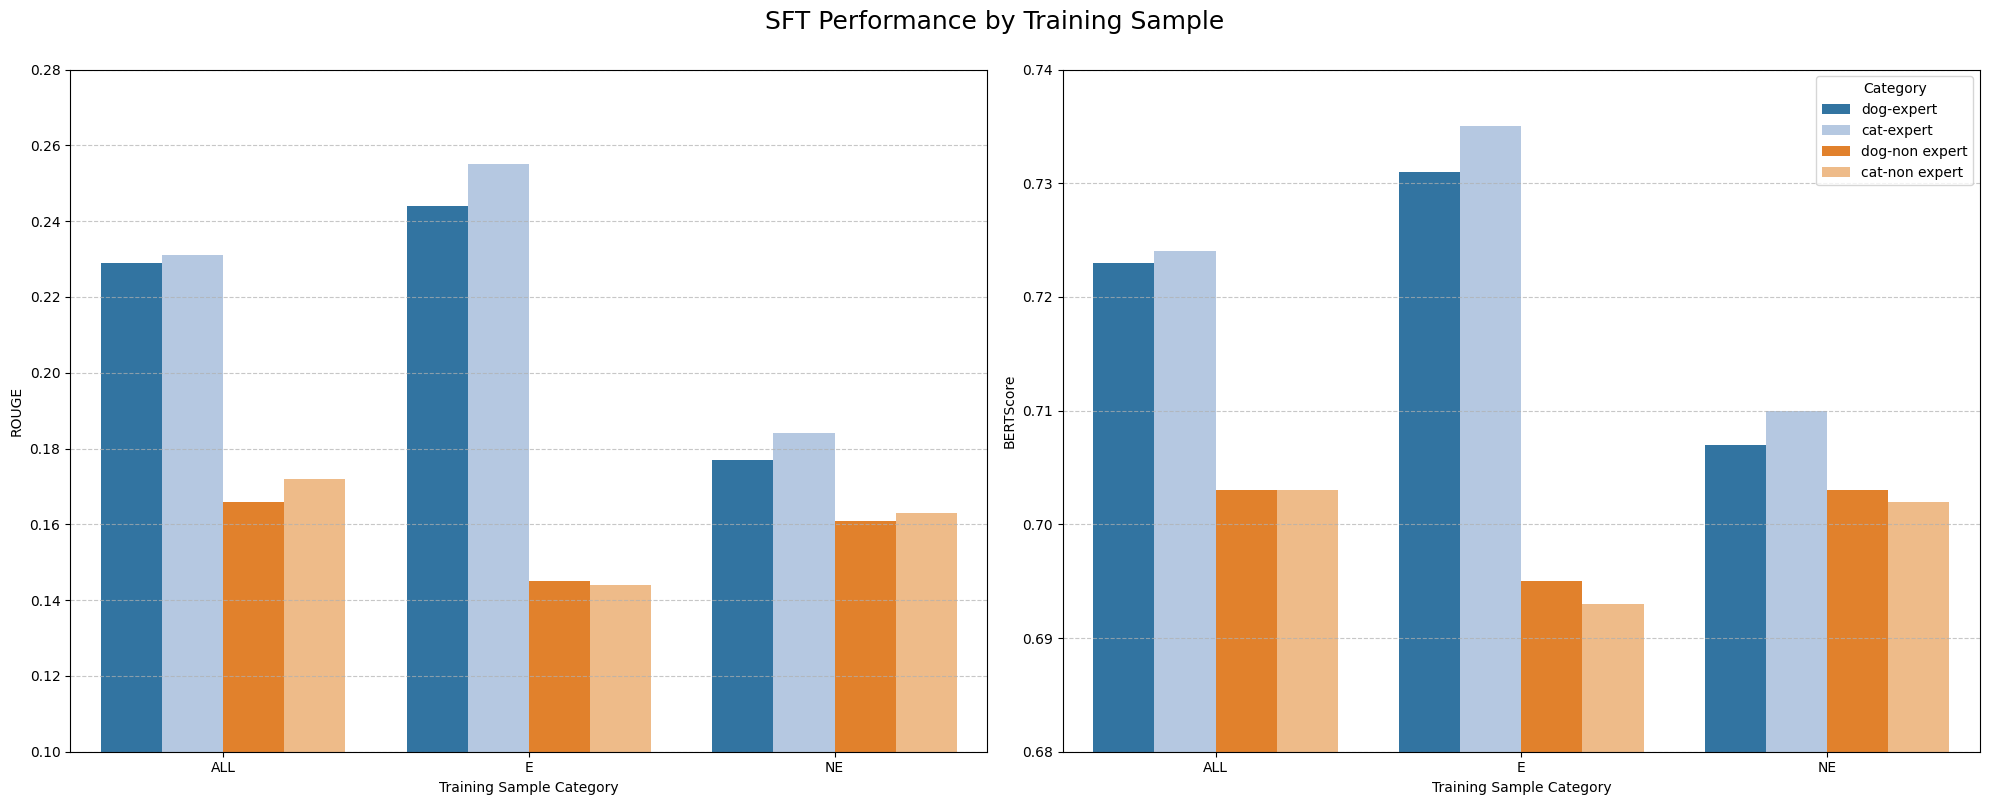

In [15]:
data_list = []
for train_category, answer_types_data in data_sft_raw.items():
    for answer_type, animal_types in answer_types_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Training Category': train_category,
                    'Answer Type': answer_type,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)

df_sft = pd.DataFrame(data_list)
df_sft = df_sft[df_sft['Input Type'] == 'preprocessed']
df_sft['Category'] = df_sft['Animal'].str.lower() + '-' + df_sft['Answer Type'].str.lower()


fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # figsize를 늘려 가독성을 높였습니다.
fig.suptitle('SFT Performance by Training Sample', fontsize=18, y=1)

# ROUGE Plot
sns.barplot(
    ax=axes[0],
    data=df_sft,
    x='Training Category',
    y='ROUGE',
    hue='Category', # 결합된 카테고리 + 입력 타입으로 hue 설정
    palette='tab20' # 더 많은 색상을 위해 palette 변경
)
axes[0].set_xlabel('Training Sample Category')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.1, 0.28)
axes[0].set_yticks(np.arange(0.1, 0.281, 0.02))
axes[0].tick_params(axis='x', rotation=0)
# axes[0].legend(title='Evaluation Category (Input Type)', bbox_to_anchor=(1.05, 1), loc='upper left')

# BERTScore Plot
sns.barplot(
    ax=axes[1],
    data=df_sft,
    x='Training Category',
    y='BERTScore',
    hue='Category', # 결합된 카테고리 + 입력 타입으로 hue 설정
    palette='tab20' # 더 많은 색상을 위해 palette 변경
)
axes[1].set_xlabel('Training Sample Category')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.68, 0.74)
axes[1].set_yticks(np.arange(0.68, 0.741, 0.01))
axes[1].tick_params(axis='x', rotation=0)
# axes[1].legend(title='Evaluation Category (Input Type)', bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # 가로선만 표시
    ax.grid(axis='x', visible=False) 
axes[0].legend_.remove()

plt.tight_layout()
plt.show()

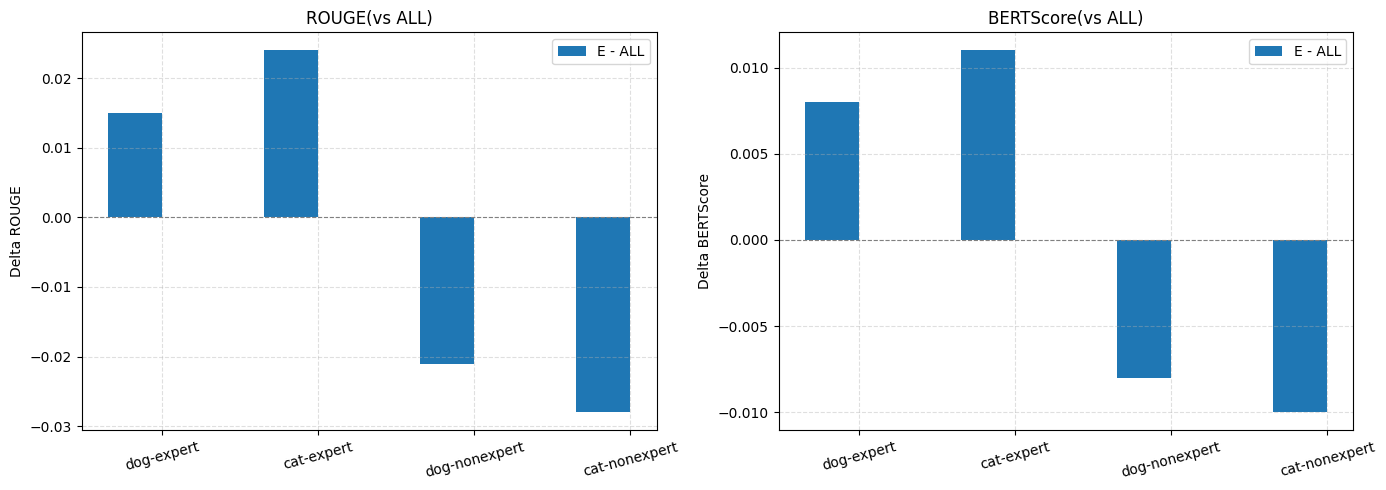

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



categories = ['dog-expert', 'cat-expert', 'dog-nonexpert', 'cat-nonexpert']

# 결과 저장용
metrics = {'ROUGE': [], 'BERTScore': []}

# baseline (ALL) 기준 값들
for category in categories:
    animal, ans_type = category.split('-')
    base = data_sft_raw['ALL']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    e = data_sft_raw['E']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    ne = data_sft_raw['NE']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']

    # 상대적 변화량 (E - ALL), (NE - ALL)
    metrics['ROUGE'].append([e['ROUGE'] - base['ROUGE'], ne['ROUGE'] - base['ROUGE']])
    metrics['BERTScore'].append([e['BERTScore'] - base['BERTScore'], ne['BERTScore'] - base['BERTScore']])

# 시각화
x = np.arange(len(categories))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric in enumerate(['ROUGE', 'BERTScore']):
    e_vals = [x[0] for x in metrics[metric]]
    ne_vals = [x[1] for x in metrics[metric]]

    axs[i].bar(x - width/2, e_vals, width, label='E - ALL')
    # axs[i].bar(x + width/2, ne_vals, width, label='NE - ALL')

    axs[i].set_ylabel(f'Delta {metric}')
    axs[i].set_title(f'{metric}(vs ALL)')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(categories, rotation=15)
    axs[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

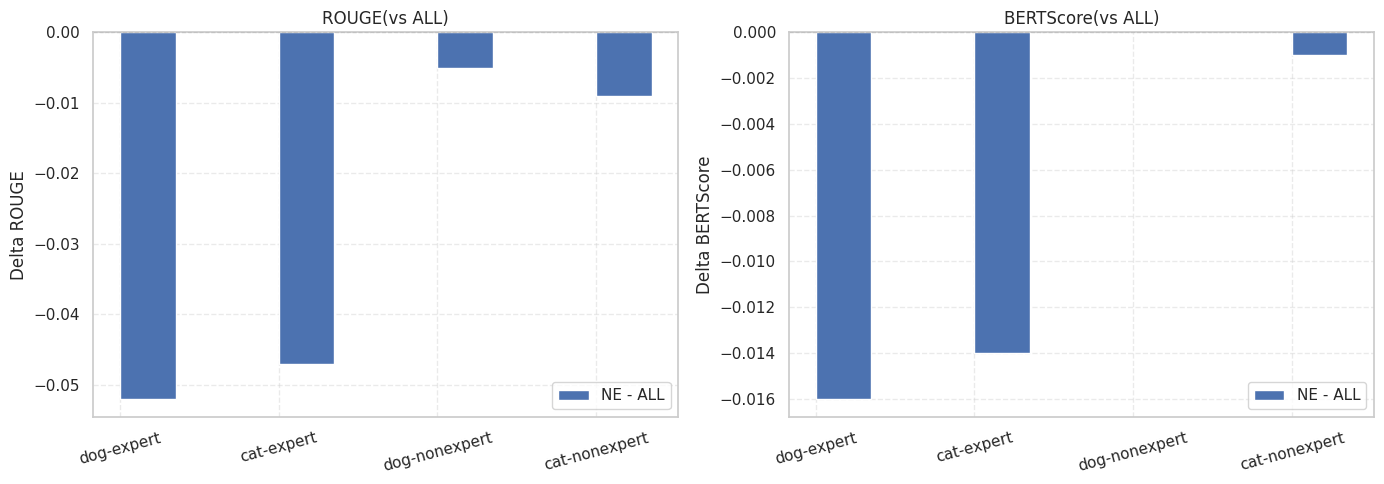

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



categories = ['dog-expert', 'cat-expert', 'dog-nonexpert', 'cat-nonexpert']

# 결과 저장용
metrics = {'ROUGE': [], 'BERTScore': []}

# baseline (ALL) 기준 값들
for category in categories:
    animal, ans_type = category.split('-')
    base = data_sft_raw['ALL']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    e = data_sft_raw['E']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']
    ne = data_sft_raw['NE']['Expert' if ans_type == 'expert' else 'Non Expert'][animal.capitalize()]['preprocessed']

    # 상대적 변화량 (E - ALL), (NE - ALL)
    metrics['ROUGE'].append([e['ROUGE'] - base['ROUGE'], ne['ROUGE'] - base['ROUGE']])
    metrics['BERTScore'].append([e['BERTScore'] - base['BERTScore'], ne['BERTScore'] - base['BERTScore']])

# 시각화
x = np.arange(len(categories))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric in enumerate(['ROUGE', 'BERTScore']):
    e_vals = [x[0] for x in metrics[metric]]
    ne_vals = [x[1] for x in metrics[metric]]

    # axs[i].bar(x - width/2, e_vals, width, label='E - ALL')
    axs[i].bar(x + width/2, ne_vals, width, label='NE - ALL')

    axs[i].set_ylabel(f'Delta {metric}')
    axs[i].set_title(f'{metric}(vs ALL)')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(categories, rotation=15)
    axs[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_raw = {
    'Expert': {
        'gpt-4o-mini': {
            'Dog': {
                'preprocessed': {'ROUGE': 0.243, 'BERTScore': 0.717},
                'raw': {'ROUGE': 0.243, 'BERTScore': 0.715}
            },
            'Cat': {
                'preprocessed': {'ROUGE': 0.249, 'BERTScore': 0.719},
                'raw': {'ROUGE': 0.250, 'BERTScore': 0.719}
            }
        },
        'exaone-3.5-7.8b': {
            'Dog': {'preprocessed': {'ROUGE': 0.228, 'BERTScore': 0.709},
                    'raw': {'ROUGE': 0.224, 'BERTScore': 0.703}},
            'Cat': {'preprocessed': {'ROUGE': 0.232, 'BERTScore': 0.710},
                    'raw': {'ROUGE': 0.231, 'BERTScore': 0.705}}
        }
    },
    'Non Expert': {
        'gpt-4o-mini': {
            'Dog': {'preprocessed': {'ROUGE': 0.226, 'BERTScore': 0.708},
                    'raw': {'ROUGE': 0.225, 'BERTScore': 0.708}},
            'Cat': {'preprocessed': {'ROUGE': 0.231, 'BERTScore': 0.710},
                    'raw': {'ROUGE': 0.232, 'BERTScore': 0.711}}
        },
        
        'exaone-3.5-7.8b': {
            'Dog': {'preprocessed': {'ROUGE': 0.201, 'BERTScore': 0.697},
                    'raw': {'ROUGE': 0.199, 'BERTScore': 0.693}},
            'Cat': {'preprocessed': {'ROUGE': 0.208, 'BERTScore': 0.699},
                    'raw': {'ROUGE': 0.204, 'BERTScore': 0.693}}
        }
    }
}

In [3]:
MODEL_NAME = 'gpt-4o-mini'
# MODEL_NAME = 'exaone-3.5-7.8b'
# MODEL_NAME = 'qwen-2.5-7b'

/tmp/ipykernel_2040133/379913673.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_2040133/379913673.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


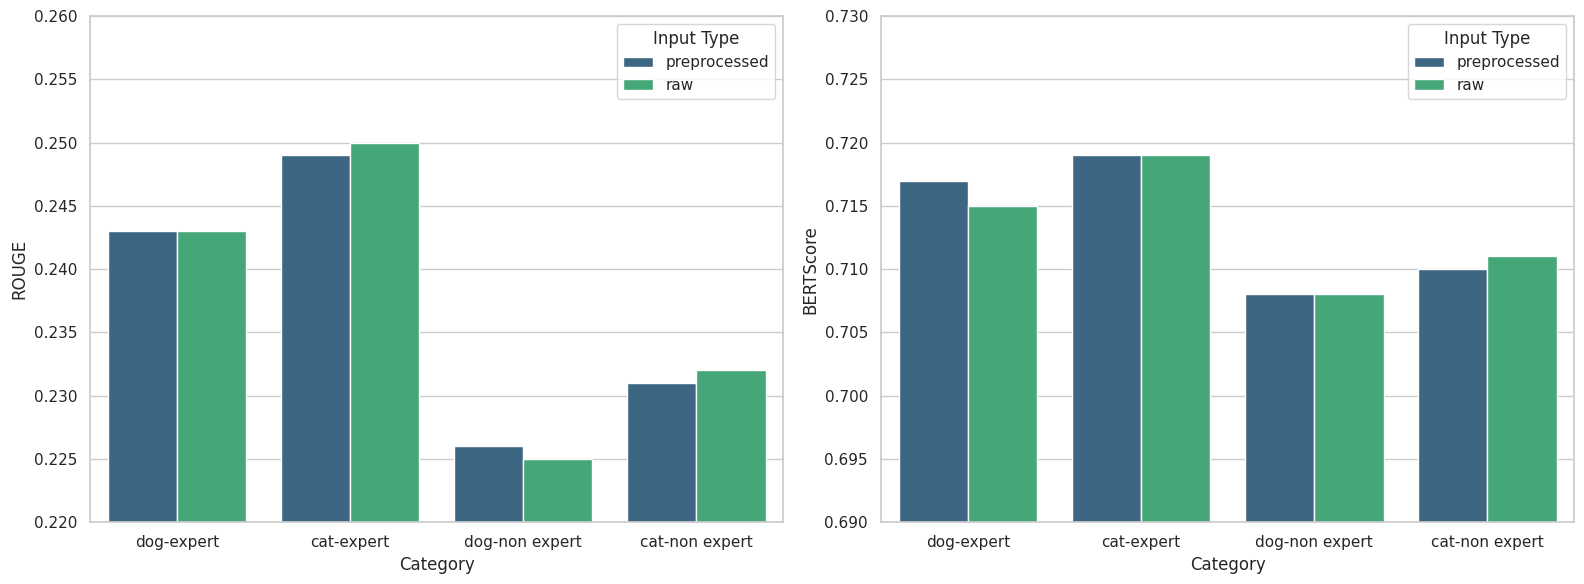

In [8]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
                
df = pd.DataFrame(data_list)

df['Combined'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

df_cell1 = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# fig.suptitle(f'Performance by Input Format (Model: {MODEL_NAME})', fontsize=18, y=1.05)
# fig.suptitle(f'Performance by Input Format', fontsize=18, y=1.05)

# ROUGE
sns.barplot(
    ax=axes[0],
    data=df_cell1,
    x='Combined',
    y='ROUGE',
    hue='Input Type',
    palette='viridis'
)
# axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Category')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005)) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# BERTScore
sns.barplot(
    ax=axes[1],
    data=df_cell1,
    x='Combined',
    y='BERTScore',
    hue='Input Type',
    palette='viridis'
)
# axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Category')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_1918069/1754115305.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_1918069/1754115305.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


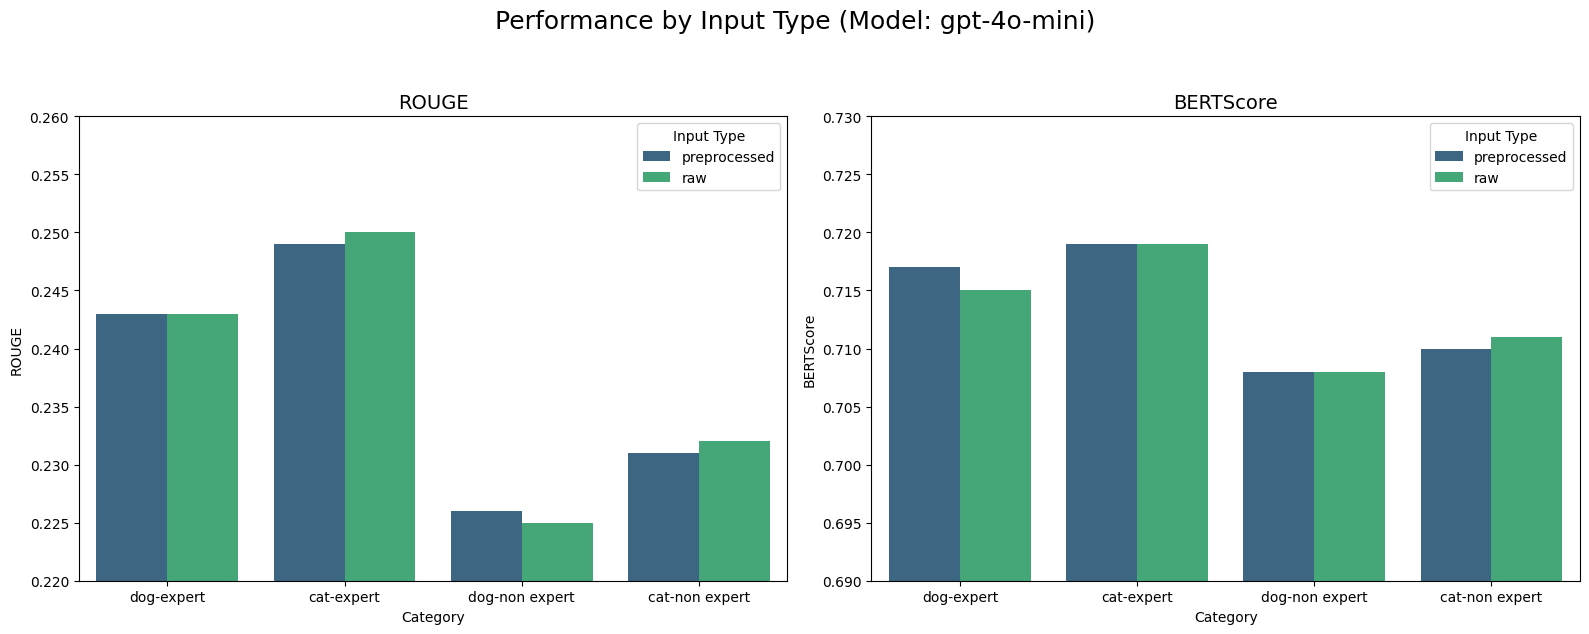

In [126]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
                
df = pd.DataFrame(data_list)

df['Combined'] = df['Animal'].str.lower() + '-' + df['Answer Type'].str.lower()

df_cell1 = df[df['Model'] == MODEL_NAME].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Performance by Input Type (Model: {MODEL_NAME})', fontsize=18, y=1.05)

# ROUGE
sns.barplot(
    ax=axes[0],
    data=df_cell1,
    x='Combined',
    y='ROUGE',
    hue='Input Type',
    palette='viridis'
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Category')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005)) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# BERTScore
sns.barplot(
    ax=axes[1],
    data=df_cell1,
    x='Combined',
    y='BERTScore',
    hue='Input Type',
    palette='viridis'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Category')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()

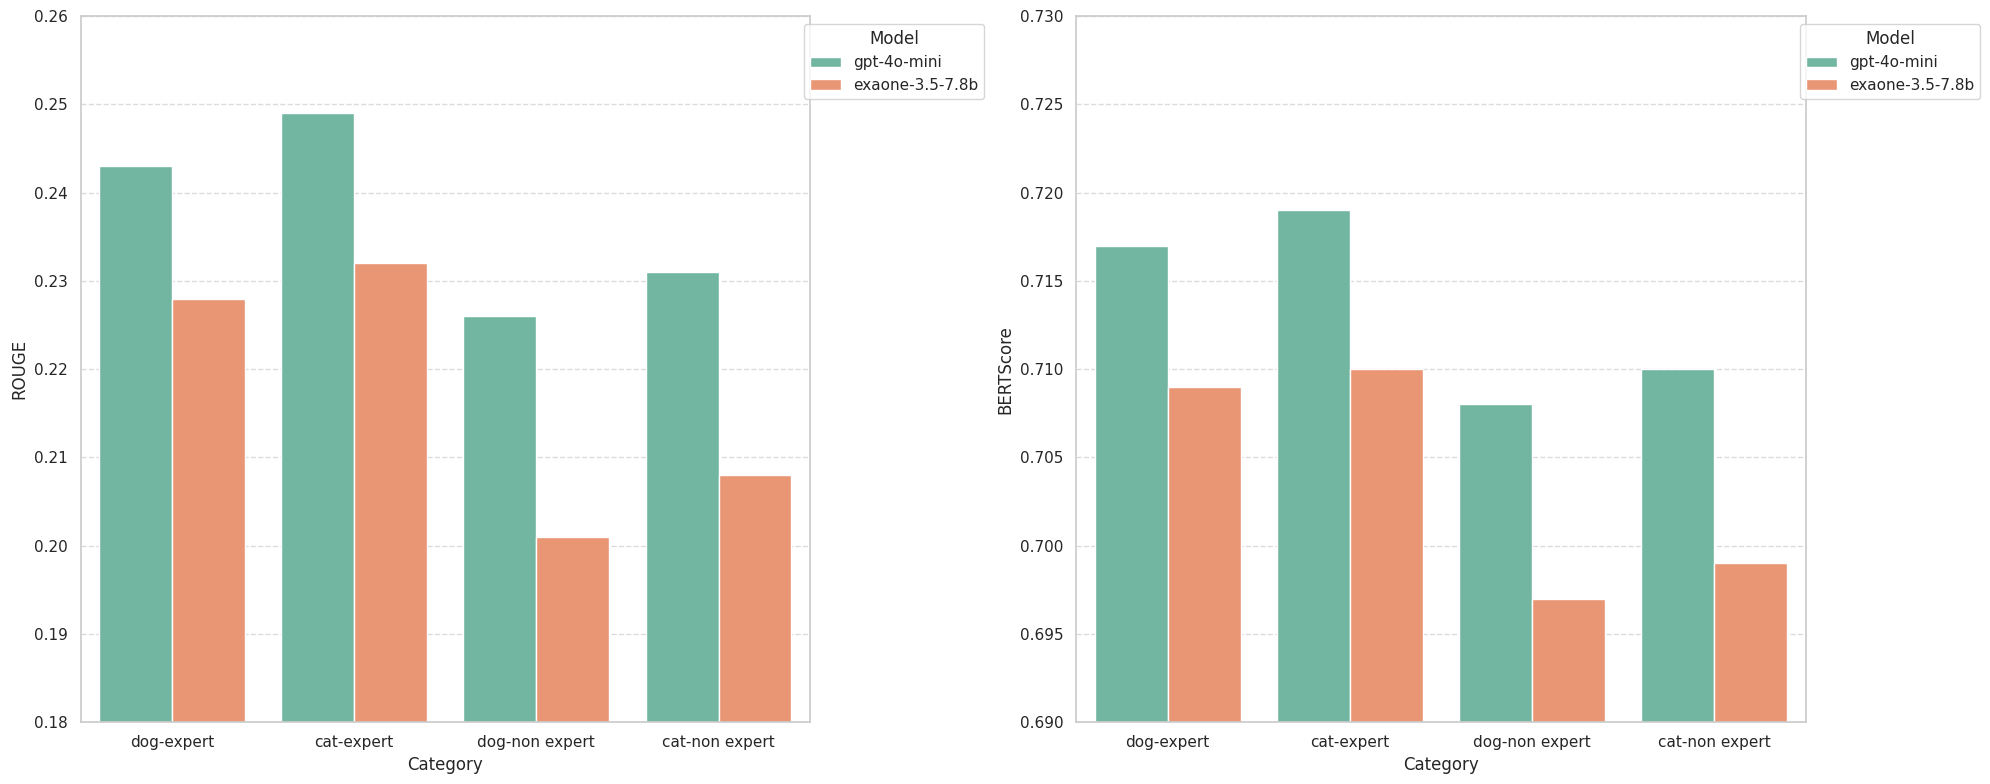

In [10]:
data_list = []
for expertise, models in data_raw.items():
    for model_name, categories in models.items():
        for category, formats in categories.items():
            for input_format, scores in formats.items():
                for score_metric, score_value in scores.items():
                    data_list.append({
                        'Expertise': expertise,
                        'Model': model_name,
                        'Category': category,
                        'Input_Format': input_format,
                        'Score_Metric': score_metric,
                        'Score_Value': score_value
                    })

df = pd.DataFrame(data_list)

# Filter for the 'preprocessed' input format as requested
df_filtered = df[df['Input_Format'] == 'preprocessed'].copy()

# Create a combined category column for the x-axis
df_filtered['Combined_Category'] = df_filtered['Category'].str.lower() + '-' +df_filtered['Expertise'].str.lower()

# Get unique score metrics
score_metrics = df_filtered['Score_Metric'].unique()

# Set up the plot style
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# fig.suptitle('Model Performance by Category (Preprocessed)', fontsize=18, y=1.02)

# Define ylim settings for each metric
ylim_settings = {
    'ROUGE': (0.18, 0.26),
    'BERTScore': (0.69, 0.73)
}

# Create plots for each metric
for i, metric in enumerate(score_metrics):
    # Filter data for the current metric
    df_metric = df_filtered[df_filtered['Score_Metric'] == metric]
    
    # Create the plot on the corresponding subplot
    sns.barplot(
        x='Combined_Category',
        y='Score_Value',
        hue='Model',
        data=df_metric,
        ax=axes[i],
        palette='Set2'
    )

    # Set titles and labels
    # axes[i].set_title(f'{metric}', fontsize=16)
    axes[i].set_xlabel('Category', fontsize=12)
    axes[i].set_ylabel(f'{metric}', fontsize=12)

    # Set different ylim for each metric
    axes[i].set_ylim(ylim_settings[metric])
    
    # Adjust legend and ticks
    axes[i].legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.close(fig)

/tmp/ipykernel_2040133/2128675626.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Combined_Category'] = df_model['Category'].str.lower() + '-' +df_model['Expertise'].str.lower()


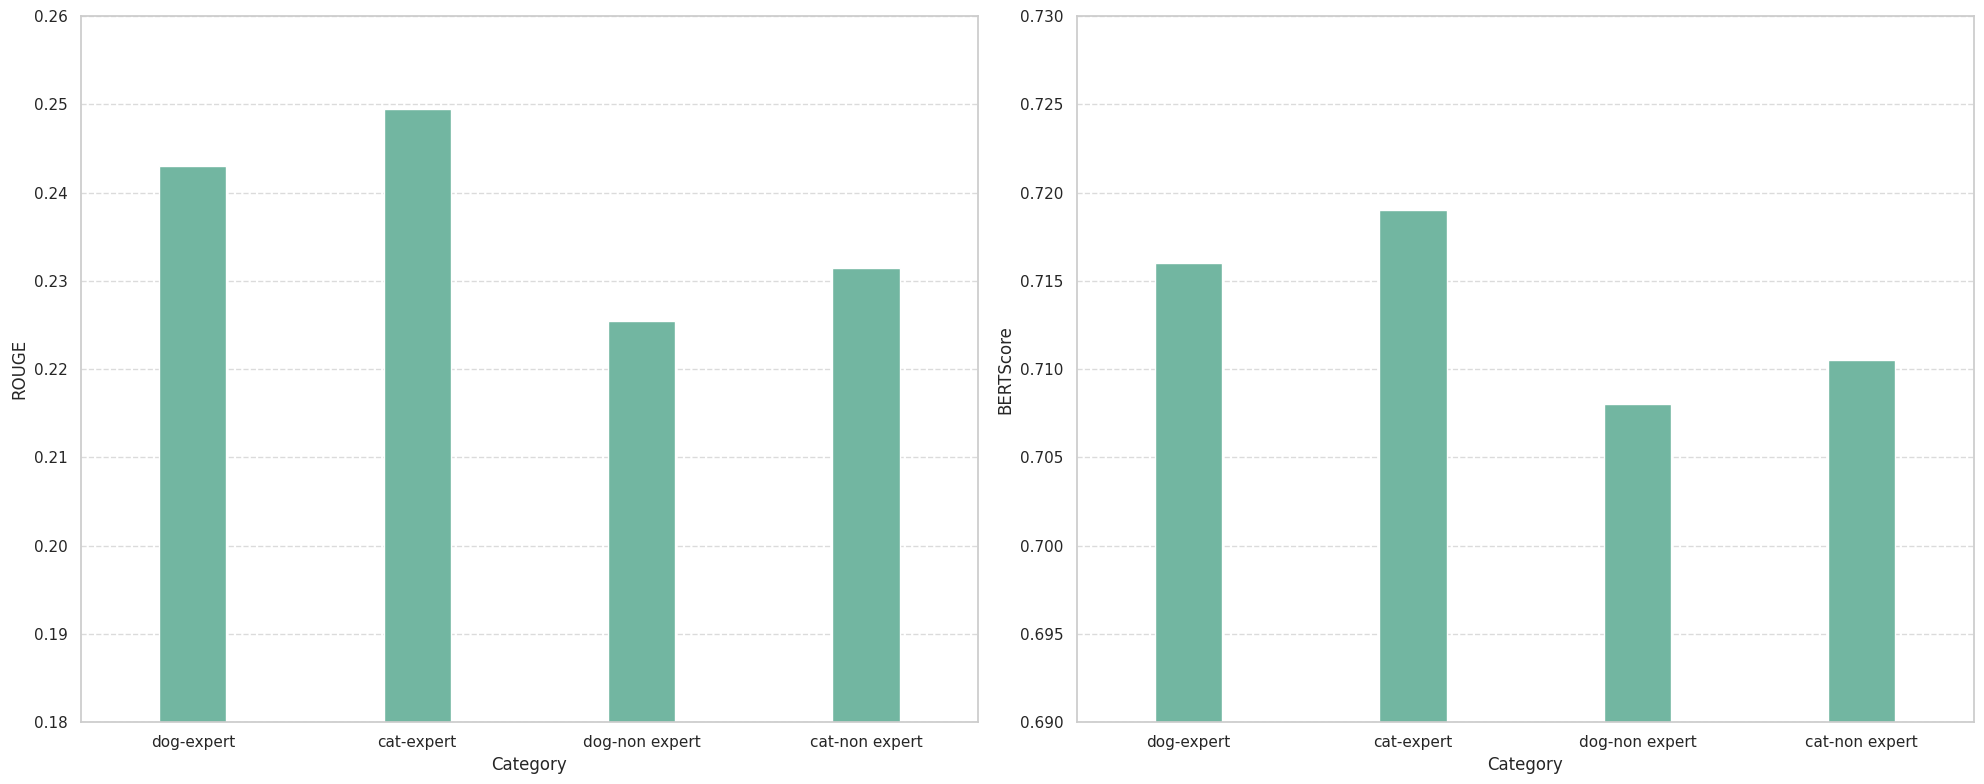

In [26]:
data_list = []
for expertise, models in data_raw.items():
    for model_name, categories in models.items():
        for category, formats in categories.items():
            for input_format, scores in formats.items():
                for score_metric, score_value in scores.items():
                    data_list.append({
                        'Expertise': expertise,
                        'Model': model_name,
                        'Category': category,
                        'Input_Format': input_format,
                        'Score_Metric': score_metric,
                        'Score_Value': score_value
                    })

df = pd.DataFrame(data_list)

target_model = "gpt-4o-mini"
df_model = df[df['Model'] == target_model]
df_model['Combined_Category'] = df_model['Category'].str.lower() + '-' +df_model['Expertise'].str.lower()


# Get unique score metrics
score_metrics = df_model['Score_Metric'].unique()

# Set up the plot style
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(1, len(score_metrics), figsize=(20, 8))

# Ensure axes is iterable
if len(score_metrics) == 1:
    axes = [axes]

# Define ylim settings for each metric (필요시 수정)
ylim_settings = {
    'ROUGE': (0.18, 0.26),
    'BERTScore': (0.69, 0.73)
}

# Create plots for each metric
for i, metric in enumerate(score_metrics):
    # Filter data for the current metric
    df_metric = df_model[df_model['Score_Metric'] == metric]

    sns.barplot(
        x='Combined_Category',
        y='Score_Value',
        data=df_metric,
        ax=axes[i],
        color='#66c2a5',
        width=0.3,
        errorbar=None
    )

    axes[i].set_xlabel('Category', fontsize=12)
    axes[i].set_ylabel(f'{metric}', fontsize=12)
    axes[i].set_ylim(ylim_settings.get(metric, (df_metric['Score_Value'].min(), df_metric['Score_Value'].max())))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.close(fig)

In [43]:
INPUT_TYPE = "preprocessed"
# INPUT_TYPE = 'raw'

/tmp/ipykernel_1918069/380963527.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_1918069/380963527.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


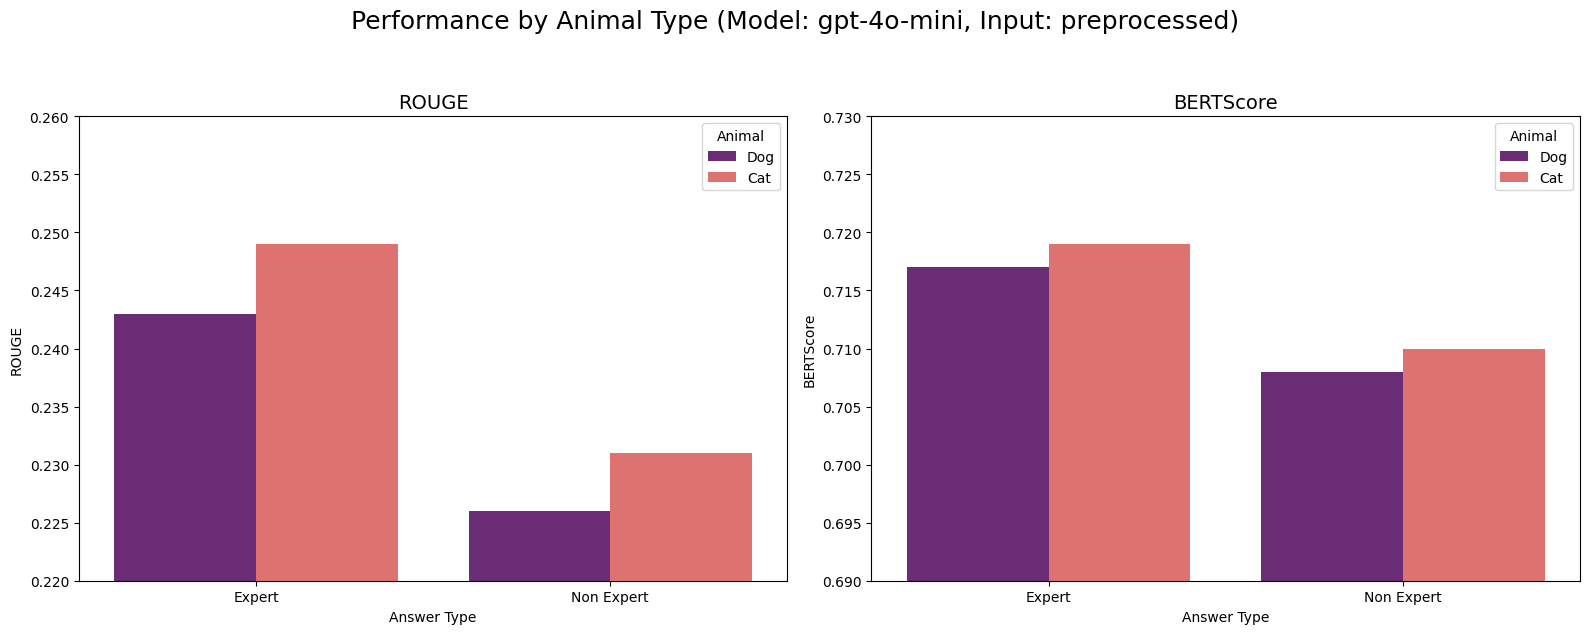

In [120]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
df = pd.DataFrame(data_list)

df_cell2 = df[(df['Model'] == MODEL_NAME) & (df['Input Type'] == INPUT_TYPE)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Performance by Animal Type (Model: {MODEL_NAME}, Input: {INPUT_TYPE})', fontsize=18, y=1.05)

sns.barplot(
    ax=axes[0],
    data=df_cell2,
    x='Answer Type',
    y='ROUGE',
    hue='Animal',
    palette='magma'
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Answer Type')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# BERTScore
sns.barplot(
    ax=axes[1],
    data=df_cell2,
    x='Answer Type',
    y='BERTScore',
    hue='Animal',
    palette='magma'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Answer Type')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_1918069/3531653155.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
/tmp/ipykernel_1918069/3531653155.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


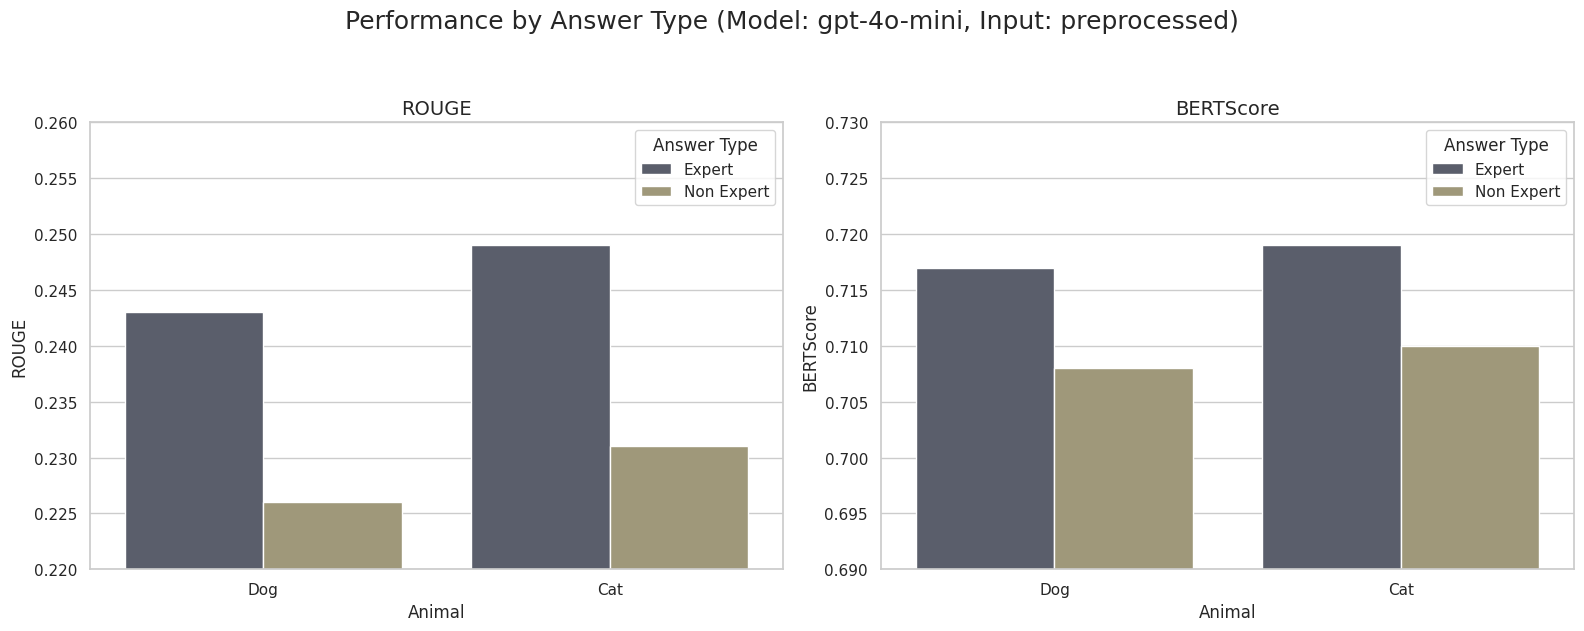

In [149]:
data_list = []
for answer_type, models_data in data_raw.items():
    for model, animal_types in models_data.items():
        for animal, input_types_data in animal_types.items():
            for input_type, scores in input_types_data.items():
                row = {
                    'Answer Type': answer_type,
                    'Model': model,
                    'Animal': animal,
                    'Input Type': input_type,
                    'ROUGE': scores['ROUGE'],
                    'BERTScore': scores['BERTScore']
                }
                data_list.append(row)
df = pd.DataFrame(data_list)

df_cell3 = df[(df['Model'] == MODEL_NAME) & (df['Input Type'] == INPUT_TYPE)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Performance by Answer Type (Model: {MODEL_NAME}, Input: {INPUT_TYPE})', fontsize=18, y=1.05)

sns.barplot(
    ax=axes[0],
    data=df_cell3,
    x='Animal',
    y='ROUGE',
    hue='Answer Type',
    palette='cividis'
)
axes[0].set_title('ROUGE', fontsize=14)
axes[0].set_xlabel('Animal')
axes[0].set_ylabel('ROUGE')
axes[0].set_ylim(0.22, 0.26)
axes[0].set_yticks(np.arange(0.22, 0.261, 0.005))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

sns.barplot(
    ax=axes[1],
    data=df_cell3,
    x='Animal',
    y='BERTScore',
    hue='Answer Type',
    palette='cividis'
)
axes[1].set_title('BERTScore', fontsize=14)
axes[1].set_xlabel('Animal')
axes[1].set_ylabel('BERTScore')
axes[1].set_ylim(0.69, 0.73)
axes[1].set_yticks(np.arange(0.69, 0.731, 0.005))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()
plt.close()